In [1]:
import itertools

import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [2]:
dfo = pd.read_csv('./data/extracted_data.csv')
dfo.head()

date  daily_confirmed_cases  daily_deaths  confirmed_cases  deaths  \
0  2020-03-20                      1             0                1       0   
1  2020-03-21                      0             0                1       0   
2  2020-03-22                      1             0                2       0   
3  2020-03-23                      0             0                2       0   
4  2020-03-24                      0             0                2       0   

  countries_and_territories geo_id country_territory_code  pop_data_2019  
0                      Chad     TD                    TCD     15946882.0  
1                      Chad     TD                    TCD     15946882.0  
2                      Chad     TD                    TCD     15946882.0  
3                      Chad     TD                    TCD     15946882.0  
4                      Chad     TD                    TCD     15946882.0

Let's say we need to forecast daily_confirmed_cases in Czechia

In [3]:
df = dfo[dfo['geo_id']=='CZ'][['date', 'daily_confirmed_cases']]\
  .copy()\
  .sort_values(by=['date'])\
  .reset_index(drop=True)
df.rename(columns={"date": "ds", "daily_confirmed_cases": "y"}, inplace=True)
df['ds'] = pd.to_datetime(df['ds'])

df.head()

ds  y
0 2019-12-31  0
1 2020-01-01  0
2 2020-01-02  0
3 2020-01-03  0
4 2020-01-04  0

Quickly examine the data

<AxesSubplot:xlabel='ds'>

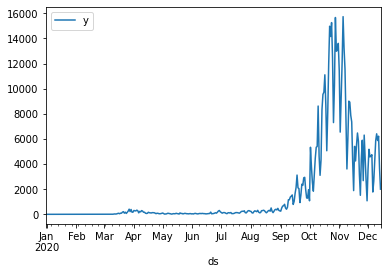

In [4]:
df.plot.line(x='ds', y='y')

In [15]:
# df = df[df['ds']>='2020-09-01']  # It looks like it's almost no cases before the September
# df

ds     y
245 2020-09-01   251
246 2020-09-02   499
247 2020-09-03   656
248 2020-09-04   679
249 2020-09-05   797
..         ...   ...
345 2020-12-10  6406
346 2020-12-11  5872
347 2020-12-12  6217
348 2020-12-13  3657
349 2020-12-14  2000

[105 rows x 2 columns]

Let's use Facebook Prophet. First, we need to find good hyperparameters of the model.

In [6]:
param_grid = {  
    'changepoint_prior_scale': [1.0, 2.0, 3.0, 4.0],
    'seasonality_prior_scale': [1.0, 2.0, 3.0, 4.0],
    'holidays_prior_scale': [1.0, 2.0, 3.0, 4.0],
}

cutoffs = pd.to_datetime(['2020-10-01', '2020-10-15', '2020-11-01'])

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here
mapes = []

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    m.add_country_holidays(country_name='CZ')
    m.fit(df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='40 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
    mapes.append(df_p['mape'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results['mape'] = mapes
print(tuning_results)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f396519c890>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       210.158    0.00990403       5.41198      0.9405      0.9405      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       211.139   0.000635065       3.12476           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       212.003    0.00104062       4.39303           1           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       212.297     0.0007115       6.74167      0.3032      0.3032      499   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       212.496   0.000956915       11.3634      0.3163      0.3163      621   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -70.7799
Iteration  1. Log joint probability =    8.59407. Improved by 79.374.
Iteration  2. Log joint probability =    38.6409. Improved by 30.0468.
Iteration  3. Log joint probability =    38.6447. Improved by 0.00385651.
Iteration  4. Log joint probability =    38.7114. Improved by 0.0666681.
Iteration  5. Log joint probability =     38.786. Improved by 0.0745743.
Iteration  6. Log joint probability =    38.8087. Improved by 0.0227082.
Iteration  7. Log joint probability =    38.9041. Improved by 0.0954259.
Iteration  8. Log joint probability =    38.9663. Improved by 0.0621797.
Iteration  9. Log joint probability =    39.0479. Improved by 0.0816134.
Iteration 10. Log joint probability =    39.0704. Improved by 0.0225351.
Iteration 11. Log joint probability =    39.0931. Improved by 0.0226496.
Iteration 12. Log joint probability =    39.1267. Improved by 0.0335737.
Iteration 13. Log joint probability =    39.1792. Improved by 0.0525509.

Initial log 

Iteration 44. Log joint probability =    80.8067. Improved by 0.291053.
Iteration 73. Log joint probability =    49.0243. Improved by 0.0246022.
Iteration 20. Log joint probability =    121.501. Improved by 0.0137184.
Iteration 45. Log joint probability =    80.9058. Improved by 0.0991799.
Iteration 74. Log joint probability =      49.08. Improved by 0.0556294.
Iteration 46. Log joint probability =    80.9711. Improved by 0.0652473.
Iteration 21. Log joint probability =    121.527. Improved by 0.0263963.
Iteration 75. Log joint probability =    49.1116. Improved by 0.0315843.
Iteration 47. Log joint probability =    81.0691. Improved by 0.0980386.
Iteration 76. Log joint probability =    49.1202. Improved by 0.00865832.
Iteration 22. Log joint probability =    121.653. Improved by 0.125527.
Iteration 48. Log joint probability =    81.1777. Improved by 0.108588.
Iteration 77. Log joint probability =    49.1784. Improved by 0.0582085.
Iteration 49. Log joint probability =    81.2646. Imp

Iteration 153. Log joint probability =     59.305. Improved by 2.88929e-07.
Iteration 102. Log joint probability =    86.0658. Improved by 0.00419007.
Iteration 62. Log joint probability =     122.22. Improved by 0.00363263.
Iteration 154. Log joint probability =     59.305. Improved by 1.15933e-06.
Iteration 103. Log joint probability =    86.0682. Improved by 0.0023539.
Iteration 155. Log joint probability =     59.305. Improved by 1.36556e-07.
Iteration 63. Log joint probability =    122.246. Improved by 0.0261333.
Iteration 104. Log joint probability =     86.074. Improved by 0.00581812.
Iteration 156. Log joint probability =     59.305. Improved by 1.89716e-07.
Iteration 105. Log joint probability =    86.1067. Improved by 0.0327317.
Iteration 64. Log joint probability =    122.249. Improved by 0.00292596.
Iteration 157. Log joint probability =     59.305. Improved by 1.92941e-07.
Iteration 106. Log joint probability =    86.1108. Improved by 0.00406392.
Iteration 158. Log joint p

Iteration 163. Log joint probability =     87.387. Improved by 0.000763433.
Iteration 107. Log joint probability =    125.463. Improved by 0.340527.
Iteration 164. Log joint probability =    87.3889. Improved by 0.00188371.
Iteration 108. Log joint probability =    125.981. Improved by 0.517412.
Iteration 165. Log joint probability =    87.3916. Improved by 0.00271432.
Iteration 166. Log joint probability =    87.4112. Improved by 0.0196121.
Iteration 109. Log joint probability =    126.268. Improved by 0.287728.
Iteration 167. Log joint probability =    87.4122. Improved by 0.00101714.
Iteration 110. Log joint probability =    126.333. Improved by 0.0646385.
Iteration 168. Log joint probability =    87.4145. Improved by 0.00228754.
Iteration 111. Log joint probability =    126.632. Improved by 0.299333.
Iteration 169. Log joint probability =    87.4151. Improved by 0.000555917.
Iteration 170. Log joint probability =    87.4152. Improved by 0.000124531.
Iteration 112. Log joint probabi

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f396518f850>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       210.625     0.0163947       14.9614      0.7142      0.7142      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       211.259    0.00476305        5.4517      0.3939      0.3939      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       212.403     0.0235442       10.5111           1           1      375   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       212.843    0.00720123       4.35408      0.7692      0.7692      491   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       213.044     0.0147237       15.2151           1           1      611   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -79.7908
Iteration  1. Log joint probability =    8.31559. Improved by 88.1064.
Iteration  2. Log joint probability =    38.4923. Improved by 30.1767.
Iteration  3. Log joint probability =    38.5432. Improved by 0.0509327.
Iteration  4. Log joint probability =    38.5829. Improved by 0.039663.
Iteration  5. Log joint probability =    38.6014. Improved by 0.0185229.
Iteration  6. Log joint probability =    38.6699. Improved by 0.0685179.
Iteration  7. Log joint probability =    38.6839. Improved by 0.0140016.
Iteration  8. Log joint probability =    38.7033. Improved by 0.0194138.
Iteration  9. Log joint probability =     38.706. Improved by 0.00266577.
Iteration 10. Log joint probability =    38.7407. Improved by 0.0347426.
Iteration 11. Log joint probability =    38.7472. Improved by 0.00651661.
Iteration 12. Log joint probability =    38.7488. Improved by 0.00153282.
Iteration 13. Log joint probability =    38.7542. Improved by 0.00541865.

Initial l

Iteration 49. Log joint probability =    80.9913. Improved by 0.0414643.
Iteration 82. Log joint probability =    58.6655. Improved by 0.0108616.
Iteration 23. Log joint probability =    118.304. Improved by 0.162463.
Iteration 83. Log joint probability =    58.6745. Improved by 0.00900554.
Iteration 50. Log joint probability =    81.1308. Improved by 0.139515.
Iteration 84. Log joint probability =    58.7512. Improved by 0.0767425.
Iteration 24. Log joint probability =    118.348. Improved by 0.044167.
Iteration 51. Log joint probability =     81.279. Improved by 0.14817.
Iteration 85. Log joint probability =    58.7526. Improved by 0.00142525.
Iteration 52. Log joint probability =    81.3105. Improved by 0.0314882.
Iteration 25. Log joint probability =    118.349. Improved by 0.000334792.
Iteration 86. Log joint probability =    58.7562. Improved by 0.00352837.
Iteration 87. Log joint probability =    58.7574. Improved by 0.00121179.
Iteration 53. Log joint probability =    81.3814. 

Iteration 110. Log joint probability =    86.9288. Improved by 0.00265294.
Iteration 65. Log joint probability =    124.991. Improved by 0.0562037.
Iteration 111. Log joint probability =    86.9325. Improved by 0.00376098.
Iteration 66. Log joint probability =    125.098. Improved by 0.106816.
Iteration 112. Log joint probability =    86.9381. Improved by 0.00559517.
Iteration 113. Log joint probability =    86.9459. Improved by 0.00772986.
Iteration 67. Log joint probability =    125.127. Improved by 0.0288306.
Iteration 114. Log joint probability =    86.9473. Improved by 0.00145458.
Iteration 68. Log joint probability =     125.26. Improved by 0.132746.
Iteration 115. Log joint probability =     86.949. Improved by 0.00170791.
Iteration 69. Log joint probability =    125.264. Improved by 0.00415119.
Iteration 116. Log joint probability =    86.9762. Improved by 0.0272305.
Iteration 117. Log joint probability =    86.9768. Improved by 0.000563617.
Iteration 70. Log joint probability 

Iteration 154. Log joint probability =    129.205. Improved by 0.000320396.
Iteration 155. Log joint probability =     129.21. Improved by 0.00494333.
Iteration 156. Log joint probability =    129.212. Improved by 0.00163075.
Iteration 157. Log joint probability =    129.213. Improved by 0.000934027.
Iteration 158. Log joint probability =    129.213. Improved by 0.000349327.
Iteration 159. Log joint probability =    129.213. Improved by 0.000106485.
Iteration 160. Log joint probability =    129.213. Improved by 2.51162e-05.
Iteration 161. Log joint probability =    129.213. Improved by 2.81515e-05.
Iteration 162. Log joint probability =    129.214. Improved by 0.000435641.
Iteration 163. Log joint probability =    129.214. Improved by 8.83919e-05.
Iteration 164. Log joint probability =    129.214. Improved by 9.52338e-05.
Iteration 165. Log joint probability =    129.214. Improved by 8.78102e-05.
Iteration 166. Log joint probability =    129.214. Improved by 7.01507e-05.
Iteration 167.

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f39649b84d0>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       210.292    0.00920761       8.64464           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       211.216   0.000809996       5.28754           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       212.131     0.0114381       5.61636           1           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     391        212.78   0.000239585       6.63756   1.712e-05       0.001      510  LS failed, Hessian reset 
     399       212.823     0.0010448       7.89816      0.7165      0.7165      519   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       213.084     0.0584754    

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -85.0618
Iteration  1. Log joint probability =    8.19815. Improved by 93.26.
Iteration  2. Log joint probability =    38.4121. Improved by 30.2139.
Iteration  3. Log joint probability =    38.4538. Improved by 0.0416965.
Iteration  4. Log joint probability =    38.4957. Improved by 0.0419686.
Iteration  5. Log joint probability =    38.4987. Improved by 0.00294637.
Iteration  6. Log joint probability =     38.512. Improved by 0.013339.
Iteration  7. Log joint probability =    38.6227. Improved by 0.110721.
Iteration  8. Log joint probability =    38.6349. Improved by 0.0121319.
Iteration  9. Log joint probability =    38.6523. Improved by 0.0173955.
Iteration 10. Log joint probability =    38.6596. Improved by 0.00730244.
Iteration 11. Log joint probability =    38.6737. Improved by 0.0141572.
Iteration 12. Log joint probability =    38.7056. Improved by 0.0319141.
Iteration 13. Log joint probability =    38.7851. Improved by 0.0794405.
Iteration 14. L

Iteration 77. Log joint probability =    57.6214. Improved by 0.292652.
Iteration 78. Log joint probability =    57.6382. Improved by 0.0167814.
Iteration 36. Log joint probability =    79.4985. Improved by 0.0963569.
Iteration 26. Log joint probability =    123.171. Improved by 0.00864683.
Iteration 79. Log joint probability =    57.7051. Improved by 0.0669017.
Iteration 37. Log joint probability =    79.5137. Improved by 0.0151323.
Iteration 80. Log joint probability =    57.7205. Improved by 0.015327.
Iteration 27. Log joint probability =    123.186. Improved by 0.0154438.
Iteration 38. Log joint probability =    79.8255. Improved by 0.311796.
Iteration 81. Log joint probability =    57.7244. Improved by 0.00398456.
Iteration 82. Log joint probability =    57.7288. Improved by 0.00436412.
Iteration 28. Log joint probability =    123.197. Improved by 0.0104556.
Iteration 39. Log joint probability =    79.8845. Improved by 0.0590544.
Iteration 83. Log joint probability =    57.7437. I

Iteration 94. Log joint probability =    87.2783. Improved by 0.00163782.
Iteration 71. Log joint probability =    126.362. Improved by 0.0362495.
Iteration 95. Log joint probability =    87.2887. Improved by 0.0104047.
Iteration 72. Log joint probability =    126.427. Improved by 0.0655236.
Iteration 96. Log joint probability =    87.2933. Improved by 0.00456109.
Iteration 73. Log joint probability =    126.563. Improved by 0.135699.
Iteration 97. Log joint probability =     87.294. Improved by 0.000709572.
Iteration 98. Log joint probability =    87.3373. Improved by 0.0433289.
Iteration 74. Log joint probability =     126.64. Improved by 0.0768255.
Iteration 99. Log joint probability =    87.3381. Improved by 0.000785329.
Iteration 75. Log joint probability =    126.675. Improved by 0.0352161.
Iteration 100. Log joint probability =    87.3385. Improved by 0.000383576.
Iteration 76. Log joint probability =    126.737. Improved by 0.0621058.
Iteration 101. Log joint probability =     

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f39649a5ad0>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       210.351     0.0213477       23.4823           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       211.236    0.00267816       6.59988       1.606      0.1606      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       212.243    0.00191538        4.4444      0.2724           1      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       212.727     0.0087538       14.8046           1           1      487   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       212.879    0.00174378       5.76985      0.5013           1      615   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -88.8017
Iteration  1. Log joint probability =    8.14531. Improved by 96.947.
Iteration  2. Log joint probability =    38.3733. Improved by 30.2279.
Iteration  3. Log joint probability =     38.399. Improved by 0.025737.
Iteration  4. Log joint probability =    38.4176. Improved by 0.0186322.
Iteration  5. Log joint probability =    38.4668. Improved by 0.0492138.
Iteration  6. Log joint probability =    38.5435. Improved by 0.0766358.
Iteration  7. Log joint probability =    38.5864. Improved by 0.0429448.
Iteration  8. Log joint probability =    38.6113. Improved by 0.0249246.
Iteration  9. Log joint probability =    38.6194. Improved by 0.0080906.
Iteration 10. Log joint probability =    38.6456. Improved by 0.026167.
Iteration 11. Log joint probability =    38.6536. Improved by 0.00798169.
Iteration 12. Log joint probability =    38.6699. Improved by 0.0163369.
Iteration 13. Log joint probability =    38.6805. Improved by 0.0105395.
Iteration 14. L

Iteration 19. Log joint probability =    122.095. Improved by 0.0189325.
Iteration 21. Log joint probability =    75.1289. Improved by 1.90267.
Iteration 78. Log joint probability =    57.6573. Improved by 0.00121924.
Iteration 20. Log joint probability =    122.114. Improved by 0.0181805.
Iteration 79. Log joint probability =    57.6579. Improved by 0.000644109.
Iteration 22. Log joint probability =    78.0497. Improved by 2.92078.
Iteration 80. Log joint probability =      57.66. Improved by 0.00209852.
Iteration 21. Log joint probability =    122.138. Improved by 0.0246239.
Iteration 23. Log joint probability =     79.307. Improved by 1.25735.
Iteration 81. Log joint probability =    57.6625. Improved by 0.00245837.
Iteration 82. Log joint probability =    58.3261. Improved by 0.663634.
Iteration 22. Log joint probability =    122.174. Improved by 0.0360224.
Iteration 24. Log joint probability =    80.1498. Improved by 0.842737.
Iteration 83. Log joint probability =    58.4249. Impr

Iteration 66. Log joint probability =    124.362. Improved by 0.00308887.
Iteration 84. Log joint probability =    85.5973. Improved by 0.0877263.
Iteration 67. Log joint probability =    124.364. Improved by 0.00231865.
Iteration 85. Log joint probability =    85.6143. Improved by 0.0169439.
Iteration 68. Log joint probability =    124.571. Improved by 0.207246.
Iteration 86. Log joint probability =    85.6224. Improved by 0.00815507.
Iteration 69. Log joint probability =    124.586. Improved by 0.015262.
Iteration 87. Log joint probability =    85.6464. Improved by 0.0239263.
Iteration 88. Log joint probability =    85.6473. Improved by 0.000906698.
Iteration 70. Log joint probability =    124.833. Improved by 0.246045.
Iteration 89. Log joint probability =    85.6782. Improved by 0.0308889.
Iteration 71. Log joint probability =    125.086. Improved by 0.253682.
Iteration 90. Log joint probability =    85.6947. Improved by 0.0165057.
Iteration 72. Log joint probability =    125.237. 

Iteration 161. Log joint probability =     129.24. Improved by 0.000624973.
Iteration 162. Log joint probability =     129.24. Improved by 0.000281.
Iteration 163. Log joint probability =     129.24. Improved by 0.000113216.
Iteration 164. Log joint probability =     129.24. Improved by 7.68595e-05.
Iteration 165. Log joint probability =     129.24. Improved by 0.000130792.
Iteration 166. Log joint probability =     129.24. Improved by 4.12907e-05.
Iteration 167. Log joint probability =    129.241. Improved by 0.000154285.
Iteration 168. Log joint probability =    129.241. Improved by 8.49977e-05.
Iteration 169. Log joint probability =    129.241. Improved by 4.75944e-05.
Iteration 170. Log joint probability =    129.241. Improved by 2.38797e-05.
Iteration 171. Log joint probability =    129.241. Improved by 4.54034e-05.
Iteration 172. Log joint probability =    129.241. Improved by 1.00717e-05.
Iteration 173. Log joint probability =    129.241. Improved by 1.82964e-05.
Iteration 174. 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f39649c0fd0>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       210.173     0.0110495        14.739           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       211.208   0.000717948       7.61453      0.5127      0.5127      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     277       212.105   0.000449358       13.5785   5.478e-05       0.001      370  LS failed, Hessian reset 
     299       212.405     0.0104935       6.60637      0.3891           1      398   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     388       212.802   0.000144047       2.89558   1.483e-05       0.001      544  LS failed, Hessian reset 
     399        212.84    0.00958831       7.65592           1           1      561   
    Iter      log pro

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -74.9388
Iteration  1. Log joint probability =    4.68279. Improved by 79.6216.
Iteration  2. Log joint probability =    5.54141. Improved by 0.858613.
Iteration  3. Log joint probability =    5.62868. Improved by 0.0872736.
Iteration  4. Log joint probability =    5.64158. Improved by 0.0128992.
Iteration  5. Log joint probability =    5.78269. Improved by 0.141115.
Iteration  6. Log joint probability =    5.83956. Improved by 0.0568643.
Iteration  7. Log joint probability =    5.86858. Improved by 0.0290165.
Iteration  8. Log joint probability =    5.90329. Improved by 0.034716.
Iteration  9. Log joint probability =     5.9066. Improved by 0.00330391.
Iteration 10. Log joint probability =    5.95827. Improved by 0.0516702.
Iteration 11. Log joint probability =    5.96316. Improved by 0.00489701.
Iteration 12. Log joint probability =    5.99779. Improved by 0.0346321.
Iteration 13. Log joint probability =    6.03174. Improved by 0.0339404.
Iteration 14

Iteration 74. Log joint probability =    39.1632. Improved by 0.843923.
Iteration 12. Log joint probability =        119. Improved by 0.0528889.
Iteration 40. Log joint probability =    52.7538. Improved by 0.952031.
Iteration 75. Log joint probability =    39.2943. Improved by 0.131101.
Iteration 13. Log joint probability =    120.289. Improved by 1.2889.
Iteration 76. Log joint probability =    39.7849. Improved by 0.490563.
Iteration 41. Log joint probability =    52.7957. Improved by 0.041847.
Iteration 77. Log joint probability =    40.2008. Improved by 0.415864.
Iteration 14. Log joint probability =    120.562. Improved by 0.272224.
Iteration 42. Log joint probability =      53.09. Improved by 0.294275.
Iteration 78. Log joint probability =    42.2232. Improved by 2.02243.
Iteration 79. Log joint probability =    43.2068. Improved by 0.983605.
Iteration 43. Log joint probability =    53.1627. Improved by 0.0727747.
Iteration 15. Log joint probability =    120.569. Improved by 0.0

Iteration 100. Log joint probability =    79.7084. Improved by 0.0810848.
Iteration 153. Log joint probability =      55.16. Improved by 0.0138354.
Iteration 58. Log joint probability =    127.097. Improved by 0.0167336.
Iteration 101. Log joint probability =    79.7243. Improved by 0.0158986.
Iteration 154. Log joint probability =    55.1724. Improved by 0.0124696.
Iteration 59. Log joint probability =    127.188. Improved by 0.0910267.
Iteration 155. Log joint probability =    55.1799. Improved by 0.00749896.
Iteration 102. Log joint probability =    79.7422. Improved by 0.0178941.
Iteration 156. Log joint probability =    55.1845. Improved by 0.00454369.
Iteration 103. Log joint probability =    80.1116. Improved by 0.369411.
Iteration 60. Log joint probability =     127.51. Improved by 0.322045.
Iteration 157. Log joint probability =    55.8877. Improved by 0.703222.
Iteration 104. Log joint probability =    80.3309. Improved by 0.219293.
Iteration 158. Log joint probability =    5

Iteration 103. Log joint probability =    128.664. Improved by 0.0176788.
Iteration 236. Log joint probability =     59.026. Improved by 6.71664e-05.
Iteration 163. Log joint probability =    86.7041. Improved by 0.0141693.
Iteration 237. Log joint probability =    59.0309. Improved by 0.00484842.
Iteration 104. Log joint probability =    128.784. Improved by 0.119416.
Iteration 164. Log joint probability =    86.7098. Improved by 0.00568165.
Iteration 238. Log joint probability =     59.048. Improved by 0.0170867.
Iteration 105. Log joint probability =    128.796. Improved by 0.0121772.
Iteration 239. Log joint probability =     59.054. Improved by 0.00603157.
Iteration 165. Log joint probability =    86.7258. Improved by 0.0160403.
Iteration 240. Log joint probability =    59.0618. Improved by 0.00775261.
Iteration 106. Log joint probability =     128.82. Improved by 0.0245215.
Iteration 166. Log joint probability =    86.7302. Improved by 0.0043384.
Iteration 241. Log joint probabil

Iteration 225. Log joint probability =    87.4225. Improved by 1.73483e-07.
Iteration 151. Log joint probability =    129.178. Improved by 1.7206e-06.
Iteration 226. Log joint probability =    87.4225. Improved by 3.68193e-08.
Iteration 152. Log joint probability =    129.178. Improved by 1.04274e-06.
Iteration 227. Log joint probability =    87.4225. Improved by 1.25557e-08.
Iteration 153. Log joint probability =    129.178. Improved by 1.33568e-06.
Iteration 228. Log joint probability =    87.4225. Improved by 4.04695e-08.
Iteration 154. Log joint probability =    129.178. Improved by 2.08184e-06.
Iteration 229. Log joint probability =    87.4225. Improved by 4.47864e-08.
Iteration 230. Log joint probability =    87.4225. Improved by 1.94239e-08.
Iteration 155. Log joint probability =    129.178. Improved by 7.81322e-07.
Iteration 231. Log joint probability =    87.4225. Improved by 2.07895e-08.
Iteration 156. Log joint probability =    129.178. Improved by 6.65685e-07.
Iteration 232

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f39649c0410>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       210.081    0.00286769       15.5525      0.2469      0.2469      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       211.083   0.000721482       10.0958      0.3012      0.3012      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       211.875    0.00668404       8.65763           1           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     355       212.395    0.00117116       10.6621   0.0003805       0.001      463  LS failed, Hessian reset 
     399       212.703    0.00374766       10.7018      0.2074      0.2074      519   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        212.91     0.0104986    

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -83.9497
Iteration  1. Log joint probability =    4.43341. Improved by 88.3831.
Iteration  2. Log joint probability =    6.01413. Improved by 1.58073.
Iteration  3. Log joint probability =    6.06146. Improved by 0.0473319.
Iteration  4. Log joint probability =    6.31228. Improved by 0.25082.
Iteration  5. Log joint probability =    6.32683. Improved by 0.014547.
Iteration  6. Log joint probability =    6.33099. Improved by 0.00415819.
Iteration  7. Log joint probability =    6.37043. Improved by 0.0394382.
Iteration  8. Log joint probability =    6.41342. Improved by 0.0429921.
Iteration  9. Log joint probability =    6.41466. Improved by 0.00123619.
Iteration 10. Log joint probability =      6.465. Improved by 0.0503483.
Iteration 11. Log joint probability =    6.47236. Improved by 0.00735974.
Iteration 12. Log joint probability =    6.50855. Improved by 0.0361859.
Iteration 13. Log joint probability =    6.56617. Improved by 0.0576176.
Iteration 14.

Iteration 51. Log joint probability =    51.6553. Improved by 0.0362406.
Iteration 20. Log joint probability =    120.186. Improved by 0.00814017.
Iteration 44. Log joint probability =    70.7072. Improved by 0.0750643.
Iteration 52. Log joint probability =    52.2671. Improved by 0.611803.
Iteration 45. Log joint probability =    70.7261. Improved by 0.0188821.
Iteration 53. Log joint probability =    52.3643. Improved by 0.0971766.
Iteration 21. Log joint probability =    120.209. Improved by 0.0222186.
Iteration 54. Log joint probability =    52.4182. Improved by 0.0539294.
Iteration 46. Log joint probability =    70.8597. Improved by 0.13361.
Iteration 55. Log joint probability =    52.5716. Improved by 0.153356.
Iteration 22. Log joint probability =    120.342. Improved by 0.13347.
Iteration 47. Log joint probability =    70.8739. Improved by 0.01413.
Iteration 56. Log joint probability =    52.6787. Improved by 0.1071.
Iteration 23. Log joint probability =    120.375. Improved by

Iteration 103. Log joint probability =    77.2535. Improved by 0.176716.
Iteration 132. Log joint probability =    58.1882. Improved by 0.00384661.
Iteration 65. Log joint probability =    122.773. Improved by 0.195972.
Iteration 104. Log joint probability =     77.298. Improved by 0.0445619.
Iteration 133. Log joint probability =    58.1959. Improved by 0.00772316.
Iteration 105. Log joint probability =    77.3902. Improved by 0.0921901.
Iteration 134. Log joint probability =    58.1973. Improved by 0.00137958.
Iteration 66. Log joint probability =     122.94. Improved by 0.167689.
Iteration 135. Log joint probability =    58.1986. Improved by 0.00132344.
Iteration 106. Log joint probability =    77.4476. Improved by 0.0573574.
Iteration 67. Log joint probability =    123.139. Improved by 0.198224.
Iteration 136. Log joint probability =    58.2153. Improved by 0.0166501.
Iteration 107. Log joint probability =    77.4619. Improved by 0.0143453.
Iteration 137. Log joint probability =   

Iteration 164. Log joint probability =    86.8267. Improved by 0.00882035.
Iteration 111. Log joint probability =    129.237. Improved by 0.00126989.
Iteration 216. Log joint probability =    59.3325. Improved by 5.2353e-07.
Iteration 165. Log joint probability =    87.0326. Improved by 0.205892.
Iteration 217. Log joint probability =    59.3325. Improved by 1.1347e-06.
Iteration 112. Log joint probability =    129.238. Improved by 0.000628121.
Iteration 166. Log joint probability =     87.181. Improved by 0.148353.
Iteration 218. Log joint probability =    59.3325. Improved by 6.19316e-08.
Iteration 219. Log joint probability =    59.3325. Improved by 5.81151e-07.
Iteration 167. Log joint probability =    87.2429. Improved by 0.0619528.
Iteration 113. Log joint probability =    129.243. Improved by 0.00470897.
Iteration 220. Log joint probability =    59.3325. Improved by 2.93943e-07.
Iteration 168. Log joint probability =    87.2757. Improved by 0.0328126.
Iteration 221. Log joint pr

Iteration 227. Log joint probability =    87.3721. Improved by 6.60657e-09.
      99       210.081    0.00286769       15.5525      0.2469      0.2469      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       211.083   0.000721482       10.0958      0.3012      0.3012      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       211.875    0.00668404       8.65763           1           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     355       212.395    0.00117116       10.6621   0.0003805       0.001      463  LS failed, Hessian reset 
     399       212.703    0.00374766       10.7018      0.2074      0.2074      519   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        212.91     0.0104986       4.94377      0.1712      0.1712      649   
    Iter  

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f396499aa10>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       210.158    0.00454574       17.9281           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       211.192    0.00479888       13.4168           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       212.011      0.123861       17.6052           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     357       212.622   0.000127533       4.56972   2.873e-05       0.001      459  LS failed, Hessian reset 
     399       212.714    0.00387728       3.38146      0.4738      0.4738      515   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       213.084     0.0102594    

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -89.2207
Iteration  1. Log joint probability =    4.32838. Improved by 93.5491.
Iteration  2. Log joint probability =    6.08426. Improved by 1.75589.
Iteration  3. Log joint probability =    6.14011. Improved by 0.055845.
Iteration  4. Log joint probability =    6.36217. Improved by 0.222059.
Iteration  5. Log joint probability =    6.37314. Improved by 0.0109762.

Initial log joint probability = -103.964
Iteration  6. Log joint probability =    6.43065. Improved by 0.0575055.
Iteration  1. Log joint probability =    28.2746. Improved by 132.239.
Iteration  7. Log joint probability =    6.44284. Improved by 0.012188.
Iteration  8. Log joint probability =     6.4594. Improved by 0.0165664.
Iteration  2. Log joint probability =     55.403. Improved by 27.1284.
Iteration  9. Log joint probability =    6.51901. Improved by 0.0596096.
Iteration  3. Log joint probability =    64.1333. Improved by 8.73032.
Iteration 10. Log joint probability =     6.5365. Imp

Iteration 57. Log joint probability =    82.8019. Improved by 0.0429344.
Iteration 80. Log joint probability =    48.2433. Improved by 0.0857119.
Iteration 29. Log joint probability =    122.054. Improved by 0.127579.
Iteration 81. Log joint probability =    48.7607. Improved by 0.517407.
Iteration 58. Log joint probability =    83.1306. Improved by 0.328704.
Iteration 82. Log joint probability =    49.0947. Improved by 0.334007.
Iteration 30. Log joint probability =    122.131. Improved by 0.0761532.
Iteration 59. Log joint probability =    83.3383. Improved by 0.207672.
Iteration 83. Log joint probability =    49.4864. Improved by 0.391609.
Iteration 60. Log joint probability =    83.3935. Improved by 0.0551766.
Iteration 84. Log joint probability =    49.8534. Improved by 0.367047.
Iteration 31. Log joint probability =    122.244. Improved by 0.11375.
Iteration 85. Log joint probability =    50.8535. Improved by 1.00015.
Iteration 61. Log joint probability =    83.4887. Improved by 

Iteration 166. Log joint probability =    55.7462. Improved by 0.00927596.
Iteration 75. Log joint probability =    126.487. Improved by 0.0105098.
Iteration 167. Log joint probability =    55.7632. Improved by 0.017.
Iteration 121. Log joint probability =     87.423. Improved by 0.000122792.
Iteration 168. Log joint probability =    55.7646. Improved by 0.00142717.
Iteration 76. Log joint probability =    126.606. Improved by 0.119595.
Iteration 122. Log joint probability =    87.4231. Improved by 6.09604e-05.
Iteration 169. Log joint probability =    55.7664. Improved by 0.00181943.
Iteration 123. Log joint probability =    87.4233. Improved by 0.000196954.
Iteration 170. Log joint probability =    55.8158. Improved by 0.0494395.
Iteration 77. Log joint probability =    126.648. Improved by 0.0420408.
Iteration 171. Log joint probability =    55.8186. Improved by 0.00277833.
Iteration 124. Log joint probability =    87.4235. Improved by 0.000193259.
Iteration 172. Log joint probabili

Iteration 253. Log joint probability =     59.333. Improved by 2.99206e-06.
Iteration 122. Log joint probability =    129.224. Improved by 0.00171561.
Iteration 254. Log joint probability =     59.333. Improved by 1.1571e-06.
Iteration 255. Log joint probability =     59.333. Improved by 5.70991e-06.
Iteration 123. Log joint probability =    129.224. Improved by 0.000610923.
Iteration 256. Log joint probability =     59.333. Improved by 1.39957e-06.
Iteration 257. Log joint probability =     59.333. Improved by 3.77548e-08.
Iteration 124. Log joint probability =    129.225. Improved by 0.0010161.
Iteration 258. Log joint probability =     59.333. Improved by 8.34622e-07.
Iteration 259. Log joint probability =     59.333. Improved by 8.28008e-07.
Iteration 125. Log joint probability =    129.226. Improved by 0.000181823.
Iteration 260. Log joint probability =     59.333. Improved by 4.96068e-07.
Iteration 261. Log joint probability =     59.333. Improved by 1.1011e-06.
Iteration 126. Lo

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f39649c0550>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       210.251    0.00414918       9.81295      0.3331      0.3331      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       211.168    0.00259235       6.24749       0.472       0.472      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       212.167    0.00537338       6.76785      0.5423      0.5423      379   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       212.812    0.00156748       5.06765      0.4098      0.4098      506   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       213.182   0.000293975       9.92073    3.18e-05       0.001      656  LS failed, Hessian reset 
    Iter      log prob        ||dx||    

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -92.9606
Iteration  1. Log joint probability =    4.28114. Improved by 97.2417.
Iteration  2. Log joint probability =    6.09512. Improved by 1.81398.
Iteration  3. Log joint probability =    6.16719. Improved by 0.0720684.
Iteration  4. Log joint probability =    6.17148. Improved by 0.00428952.
Iteration  5. Log joint probability =    6.28402. Improved by 0.112542.
Iteration  6. Log joint probability =    6.37779. Improved by 0.0937681.
Iteration  7. Log joint probability =    6.41449. Improved by 0.0366991.
Iteration  8. Log joint probability =    6.42182. Improved by 0.00732943.
Iteration  9. Log joint probability =    6.43224. Improved by 0.0104199.
Iteration 10. Log joint probability =     6.4583. Improved by 0.0260615.
Iteration 11. Log joint probability =    6.50756. Improved by 0.049259.
Iteration 12. Log joint probability =    6.51381. Improved by 0.00625814.
Iteration 13. Log joint probability =    6.52509. Improved by 0.0112761.
Iteration 14

Iteration 34. Log joint probability =    67.7725. Improved by 0.324597.
Iteration 77. Log joint probability =     47.728. Improved by 0.12696.
Iteration 17. Log joint probability =    123.918. Improved by 0.448209.
Iteration 78. Log joint probability =    47.7469. Improved by 0.0189302.
Iteration 35. Log joint probability =    71.3387. Improved by 3.56623.
Iteration 18. Log joint probability =    124.025. Improved by 0.107002.
Iteration 79. Log joint probability =    47.8797. Improved by 0.1328.
Iteration 36. Log joint probability =    73.7879. Improved by 2.44917.
Iteration 80. Log joint probability =    47.9202. Improved by 0.0404813.
Iteration 19. Log joint probability =    124.149. Improved by 0.124144.
Iteration 81. Log joint probability =    48.0504. Improved by 0.130261.
Iteration 37. Log joint probability =    74.5388. Improved by 0.750982.
Iteration 82. Log joint probability =     48.145. Improved by 0.0945457.
Iteration 20. Log joint probability =    124.225. Improved by 0.07

Iteration 160. Log joint probability =     57.888. Improved by 0.0425098.
Iteration 95. Log joint probability =    83.1802. Improved by 0.0055471.
Iteration 161. Log joint probability =    57.8912. Improved by 0.00326604.
Iteration 65. Log joint probability =    126.949. Improved by 0.0251186.
Iteration 96. Log joint probability =    83.1868. Improved by 0.00659643.
Iteration 162. Log joint probability =    57.9174. Improved by 0.0261892.
Iteration 163. Log joint probability =    57.9467. Improved by 0.0292344.
Iteration 66. Log joint probability =    126.983. Improved by 0.0342908.
Iteration 97. Log joint probability =    83.2468. Improved by 0.0600453.
Iteration 164. Log joint probability =    57.9569. Improved by 0.0102138.
Iteration 98. Log joint probability =    83.3734. Improved by 0.126599.
Iteration 165. Log joint probability =     58.002. Improved by 0.0451215.
Iteration 67. Log joint probability =    126.998. Improved by 0.0143268.
Iteration 166. Log joint probability =    58

Iteration 111. Log joint probability =    129.107. Improved by 7.76072e-05.
Iteration 156. Log joint probability =    87.4024. Improved by 0.000218716.
Iteration 157. Log joint probability =     87.403. Improved by 0.000676006.
Iteration 112. Log joint probability =    129.109. Improved by 0.00141893.
Iteration 158. Log joint probability =    87.4126. Improved by 0.00958194.
Iteration 113. Log joint probability =    129.128. Improved by 0.0188477.
Iteration 159. Log joint probability =    87.4172. Improved by 0.00457849.
Iteration 114. Log joint probability =     129.13. Improved by 0.00215135.
Iteration 160. Log joint probability =    87.4183. Improved by 0.00111748.
Iteration 161. Log joint probability =    87.4199. Improved by 0.00160376.
Iteration 115. Log joint probability =    129.235. Improved by 0.10547.
Iteration 162. Log joint probability =    87.4202. Improved by 0.000276078.
Iteration 116. Log joint probability =    129.237. Improved by 0.00174219.
Iteration 163. Log joint 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a089750>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       210.299     0.0207382       7.68979           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       211.213    0.00799754       4.66019           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     295       212.406   0.000492514       10.3404   7.558e-05       0.001      391  LS failed, Hessian reset 
     299       212.417    0.00245589       19.0808           1           1      395   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       212.819    0.00190237        5.1664      0.4402           1      516   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     460       213.001    0.00253945    

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -77.3716
Iteration  1. Log joint probability =    3.79221. Improved by 81.1638.
Iteration  2. Log joint probability =    8.80669. Improved by 5.01448.
Iteration  3. Log joint probability =    8.86459. Improved by 0.0579027.
Iteration  4. Log joint probability =    8.88347. Improved by 0.0188802.
Iteration  5. Log joint probability =    8.90946. Improved by 0.0259832.
Iteration  6. Log joint probability =    8.96904. Improved by 0.0595815.
Iteration  7. Log joint probability =    8.97957. Improved by 0.010531.
Iteration  8. Log joint probability =    9.00976. Improved by 0.0301908.
Iteration  9. Log joint probability =    9.07264. Improved by 0.0628785.
Iteration 10. Log joint probability =     9.1278. Improved by 0.0551576.
Iteration 11. Log joint probability =    9.14749. Improved by 0.0196889.
Iteration 12. Log joint probability =    9.17501. Improved by 0.0275268.
Iteration 13. Log joint probability =    9.24075. Improved by 0.0657418.
Iteration 14. 

Iteration 79. Log joint probability =    35.8591. Improved by 0.142676.
Iteration 33. Log joint probability =    79.8843. Improved by 0.193462.
Iteration 13. Log joint probability =    117.603. Improved by 0.174901.
Iteration 80. Log joint probability =    35.9688. Improved by 0.109664.
Iteration 34. Log joint probability =     80.101. Improved by 0.216703.
Iteration 81. Log joint probability =    36.1931. Improved by 0.224291.
Iteration 14. Log joint probability =     117.75. Improved by 0.147332.
Iteration 35. Log joint probability =    80.3024. Improved by 0.20145.
Iteration 82. Log joint probability =    36.4499. Improved by 0.256853.
Iteration 15. Log joint probability =    118.132. Improved by 0.381776.
Iteration 83. Log joint probability =     36.997. Improved by 0.547086.
Iteration 36. Log joint probability =     80.466. Improved by 0.163543.
Iteration 84. Log joint probability =    37.1107. Improved by 0.113683.
Iteration 37. Log joint probability =    80.5765. Improved by 0.1

Iteration 95. Log joint probability =    85.5578. Improved by 0.0271014.
Iteration 59. Log joint probability =    127.185. Improved by 0.191611.
Iteration 162. Log joint probability =    56.2189. Improved by 0.0326603.
Iteration 96. Log joint probability =    85.5987. Improved by 0.0409493.
Iteration 163. Log joint probability =    56.2348. Improved by 0.0158945.
Iteration 60. Log joint probability =    127.223. Improved by 0.0380551.
Iteration 164. Log joint probability =    56.2375. Improved by 0.00271917.
Iteration 97. Log joint probability =    85.6503. Improved by 0.0515407.
Iteration 165. Log joint probability =    56.2402. Improved by 0.00266063.
Iteration 61. Log joint probability =    127.298. Improved by 0.0743689.
Iteration 98. Log joint probability =    85.6659. Improved by 0.0156006.
Iteration 166. Log joint probability =    56.2436. Improved by 0.00339494.
Iteration 99. Log joint probability =    85.6673. Improved by 0.00148696.
Iteration 167. Log joint probability =    5

Iteration 105. Log joint probability =    129.105. Improved by 0.00566719.
Iteration 247. Log joint probability =    59.3333. Improved by 5.62327e-05.
Iteration 248. Log joint probability =    59.3333. Improved by 2.08342e-05.
Iteration 159. Log joint probability =    87.4236. Improved by 7.3804e-07.
Iteration 106. Log joint probability =    129.105. Improved by 0.000815318.
Iteration 249. Log joint probability =    59.3334. Improved by 1.7128e-05.
Iteration 160. Log joint probability =    87.4236. Improved by 3.56136e-07.
Iteration 250. Log joint probability =    59.3334. Improved by 5.01153e-06.
Iteration 107. Log joint probability =    129.109. Improved by 0.00319925.
Iteration 161. Log joint probability =    87.4236. Improved by 5.28886e-07.
Iteration 251. Log joint probability =    59.3334. Improved by 1.17775e-05.
Iteration 252. Log joint probability =    59.3334. Improved by 9.88044e-06.
Iteration 108. Log joint probability =     129.16. Improved by 0.0516818.
Iteration 162. Log

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f39649b8690>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       210.253     0.0225571        16.927           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       211.114   0.000131854       4.19136   2.063e-05       0.001      281  LS failed, Hessian reset 
     199       211.179   0.000254039        8.1572      0.3811      0.3811      308   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       211.192   0.000496996       8.04741   9.968e-05       0.001      349  LS failed, Hessian reset 
     299       212.085    0.00535385       16.3686      0.1631      0.9423      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       212.559     0.0018542       12.2801      0.5427           1      594   
    Iter      log pro

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -86.3825
Iteration  1. Log joint probability =    3.55015. Improved by 89.9326.
Iteration  2. Log joint probability =    9.21037. Improved by 5.66022.
Iteration  3. Log joint probability =    9.21202. Improved by 0.00165564.
Iteration  4. Log joint probability =    9.29892. Improved by 0.0868988.
Iteration  5. Log joint probability =    9.50222. Improved by 0.203298.
Iteration  6. Log joint probability =    9.52112. Improved by 0.0189009.
Iteration  7. Log joint probability =    9.55033. Improved by 0.029209.
Iteration  8. Log joint probability =    9.55816. Improved by 0.00783011.

Initial log joint probability = -101.126
Iteration  9. Log joint probability =    9.58895. Improved by 0.0307862.
Iteration 10. Log joint probability =    9.63181. Improved by 0.0428648.
Iteration  1. Log joint probability =    28.3163. Improved by 129.442.
Iteration 11. Log joint probability =    9.66022. Improved by 0.0284138.
Iteration  2. Log joint probability =    56.28

Iteration 78. Log joint probability =     38.783. Improved by 0.141971.
Iteration 31. Log joint probability =     122.71. Improved by 0.0664164.
Iteration 79. Log joint probability =    38.9075. Improved by 0.124495.
Iteration 53. Log joint probability =     79.133. Improved by 0.0314801.
Iteration 80. Log joint probability =    38.9622. Improved by 0.0547635.
Iteration 32. Log joint probability =    122.718. Improved by 0.00790395.
Iteration 54. Log joint probability =    79.3152. Improved by 0.18216.
Iteration 81. Log joint probability =    39.2571. Improved by 0.294904.
Iteration 55. Log joint probability =    79.3806. Improved by 0.0654622.
Iteration 82. Log joint probability =    39.4108. Improved by 0.153643.
Iteration 33. Log joint probability =    122.743. Improved by 0.0245115.
Iteration 83. Log joint probability =    39.7174. Improved by 0.306598.
Iteration 56. Log joint probability =    79.4192. Improved by 0.0385571.
Iteration 34. Log joint probability =    122.762. Improve

Iteration 161. Log joint probability =    56.9582. Improved by 0.0041114.
Iteration 77. Log joint probability =    128.606. Improved by 0.0053718.
Iteration 162. Log joint probability =    56.9647. Improved by 0.00646494.
Iteration 115. Log joint probability =    86.6705. Improved by 0.00921059.
Iteration 163. Log joint probability =    56.9674. Improved by 0.00274724.
Iteration 78. Log joint probability =    128.637. Improved by 0.0315586.
Iteration 116. Log joint probability =    86.7463. Improved by 0.0758471.
Iteration 164. Log joint probability =      56.97. Improved by 0.00255058.
Iteration 79. Log joint probability =    128.716. Improved by 0.0789816.
Iteration 117. Log joint probability =    86.7475. Improved by 0.00113041.
Iteration 165. Log joint probability =    56.9716. Improved by 0.00165105.
Iteration 166. Log joint probability =    56.9787. Improved by 0.00704432.
Iteration 118. Log joint probability =    87.0541. Improved by 0.306616.
Iteration 80. Log joint probability

Iteration 177. Log joint probability =    87.4246. Improved by 2.41355e-08.
Iteration 126. Log joint probability =    129.227. Improved by 1.69635e-06.
Iteration 178. Log joint probability =    87.4246. Improved by 5.23658e-08.
Iteration 127. Log joint probability =    129.227. Improved by 1.49174e-06.
Iteration 179. Log joint probability =    87.4246. Improved by 4.01521e-09.
Iteration 128. Log joint probability =    129.227. Improved by 1.11229e-06.
Iteration 129. Log joint probability =    129.227. Improved by 1.18029e-06.
Iteration 130. Log joint probability =    129.227. Improved by 1.19746e-06.
Iteration 131. Log joint probability =    129.227. Improved by 2.87762e-07.
Iteration 132. Log joint probability =    129.227. Improved by 4.66618e-07.
Iteration 133. Log joint probability =    129.227. Improved by 7.26289e-07.
Iteration 134. Log joint probability =    129.227. Improved by 8.23616e-07.
Iteration 135. Log joint probability =    129.227. Improved by 6.53516e-07.
Iteration 13

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f39649a5b50>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       210.386     0.0220135       15.1723           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        211.24    0.00141839       3.03461           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       212.445     0.0066368        14.398           1           1      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       212.977   0.000850223       5.62143      0.6724      0.6724      480   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     441       213.031   0.000453064       6.19329   0.0001227       0.001      559  LS failed, Hessian reset 
     499       213.123    0.00542366    

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -91.6535
Iteration  1. Log joint probability =     3.4482. Improved by 95.1017.
Iteration  2. Log joint probability =    9.26888. Improved by 5.82068.
Iteration  3. Log joint probability =    9.35857. Improved by 0.0896876.
Iteration  4. Log joint probability =    9.39739. Improved by 0.0388197.
Iteration  5. Log joint probability =    9.42302. Improved by 0.025631.
Iteration  6. Log joint probability =    9.47597. Improved by 0.0529511.
Iteration  7. Log joint probability =    9.50431. Improved by 0.0283398.
Iteration  8. Log joint probability =    9.50899. Improved by 0.00467655.
Iteration  9. Log joint probability =    9.52833. Improved by 0.0193406.
Iteration 10. Log joint probability =     9.5369. Improved by 0.00856487.
Iteration 11. Log joint probability =    9.54714. Improved by 0.0102406.
Iteration 12. Log joint probability =    9.56091. Improved by 0.0137749.
Iteration 13. Log joint probability =    15.1231. Improved by 5.5622.
Iteration 14. L

Iteration 30. Log joint probability =    81.0296. Improved by 4.87081.
Iteration 71. Log joint probability =    36.4353. Improved by 0.0111263.
Iteration 31. Log joint probability =    81.1965. Improved by 0.166969.
Iteration 18. Log joint probability =    120.908. Improved by 0.118987.
Iteration 72. Log joint probability =    36.5336. Improved by 0.0982618.
Iteration 32. Log joint probability =    81.2444. Improved by 0.0478125.
Iteration 73. Log joint probability =    36.9323. Improved by 0.398772.
Iteration 19. Log joint probability =    120.958. Improved by 0.0507064.
Iteration 33. Log joint probability =    81.3127. Improved by 0.0683185.
Iteration 74. Log joint probability =     36.952. Improved by 0.0196617.
Iteration 75. Log joint probability =    37.1553. Improved by 0.203333.
Iteration 34. Log joint probability =    81.4214. Improved by 0.108774.
Iteration 20. Log joint probability =    120.985. Improved by 0.0269083.
Iteration 76. Log joint probability =    37.2055. Improved

Iteration 150. Log joint probability =    55.9544. Improved by 0.012682.
Iteration 92. Log joint probability =    87.3127. Improved by 0.00994093.
Iteration 151. Log joint probability =    55.9672. Improved by 0.0128384.
Iteration 62. Log joint probability =    124.423. Improved by 0.229887.
Iteration 93. Log joint probability =    87.3151. Improved by 0.00232895.
Iteration 152. Log joint probability =    56.0017. Improved by 0.0344305.
Iteration 94. Log joint probability =    87.3156. Improved by 0.000578444.
Iteration 153. Log joint probability =    56.0043. Improved by 0.00267512.
Iteration 63. Log joint probability =    124.448. Improved by 0.0252548.
Iteration 154. Log joint probability =    56.0151. Improved by 0.0107973.
Iteration 95. Log joint probability =    87.3176. Improved by 0.00197022.
Iteration 64. Log joint probability =    124.496. Improved by 0.0474609.
Iteration 155. Log joint probability =    56.0651. Improved by 0.0499602.
Iteration 96. Log joint probability =    

Iteration 234. Log joint probability =    59.3343. Improved by 0.000246548.
Iteration 235. Log joint probability =    59.3346. Improved by 0.000313048.
Iteration 106. Log joint probability =    127.601. Improved by 0.00126444.
Iteration 236. Log joint probability =    59.3347. Improved by 0.000124756.
Iteration 237. Log joint probability =    59.3347. Improved by 3.46304e-05.
Iteration 107. Log joint probability =    127.609. Improved by 0.0073825.
Iteration 238. Log joint probability =     59.335. Improved by 0.000214229.
Iteration 239. Log joint probability =    59.3351. Improved by 0.000104645.
Iteration 108. Log joint probability =    127.611. Improved by 0.00234331.
Iteration 240. Log joint probability =    59.3351. Improved by 6.4142e-05.
Iteration 241. Log joint probability =    59.3352. Improved by 2.84224e-05.
Iteration 109. Log joint probability =    127.617. Improved by 0.00626107.
Iteration 242. Log joint probability =    59.3353. Improved by 0.000164167.
Iteration 243. Log

Iteration 198. Log joint probability =    129.246. Improved by 6.11416e-07.
Iteration 199. Log joint probability =    129.246. Improved by 5.43804e-08.
Iteration 200. Log joint probability =    129.246. Improved by 1.57127e-09.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f39649aa990>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        210.21     0.0187355       18.3812           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       211.272    0.00330487       6.51221       0.309           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       212.349    0.00678971       8.18406      0.2756           1      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     306       212.379   0.000403852       10.1833   7.288e-05       0.001      407  LS failed, Hessian reset 
     382       212.531   0.000677619       5.51906   0.0001554       0.001      540  LS failed, Hessian reset 
     399       212.547   0.000400237       2.82077       0.177           1      563   
    Iter      log pro

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -95.3934
Iteration  1. Log joint probability =    3.40235. Improved by 98.7957.
Iteration  2. Log joint probability =    9.27721. Improved by 5.87487.
Iteration  3. Log joint probability =    9.28503. Improved by 0.00782265.
Iteration  4. Log joint probability =    9.34844. Improved by 0.0634094.
Iteration  5. Log joint probability =    9.35228. Improved by 0.00383683.
Iteration  6. Log joint probability =    9.36029. Improved by 0.00800925.
Iteration  7. Log joint probability =    9.55414. Improved by 0.193852.
Iteration  8. Log joint probability =    9.58659. Improved by 0.0324449.
Iteration  9. Log joint probability =    9.64615. Improved by 0.0595635.
Iteration 10. Log joint probability =    9.68115. Improved by 0.0350051.
Iteration 11. Log joint probability =    9.68377. Improved by 0.00261599.
Iteration 12. Log joint probability =    9.68392. Improved by 0.000144471.
Iteration 13. Log joint probability =    9.74413. Improved by 0.0602118.
Iteratio

Iteration 68. Log joint probability =    34.0209. Improved by 1.17613.
Iteration 27. Log joint probability =    123.463. Improved by 0.049491.
Iteration 23. Log joint probability =    62.1337. Improved by 0.0189186.
Iteration 69. Log joint probability =    34.4331. Improved by 0.412152.
Iteration 24. Log joint probability =    62.2716. Improved by 0.137907.
Iteration 70. Log joint probability =    35.6638. Improved by 1.23071.
Iteration 28. Log joint probability =    123.499. Improved by 0.0368289.
Iteration 71. Log joint probability =    36.5929. Improved by 0.929124.
Iteration 25. Log joint probability =    62.3386. Improved by 0.0670301.
Iteration 29. Log joint probability =    123.573. Improved by 0.0737049.
Iteration 72. Log joint probability =    37.0789. Improved by 0.485987.
Iteration 26. Log joint probability =    62.3658. Improved by 0.0272182.
Iteration 73. Log joint probability =    38.6017. Improved by 1.52285.
Iteration 30. Log joint probability =    123.632. Improved by 

Iteration 73. Log joint probability =     126.79. Improved by 0.0105528.
Iteration 82. Log joint probability =    76.7765. Improved by 0.266215.
Iteration 151. Log joint probability =    52.3747. Improved by 0.0287674.
Iteration 74. Log joint probability =    126.803. Improved by 0.0122638.
Iteration 152. Log joint probability =    52.4272. Improved by 0.0525221.
Iteration 83. Log joint probability =    76.8389. Improved by 0.0624674.
Iteration 153. Log joint probability =    52.4391. Improved by 0.0118765.
Iteration 84. Log joint probability =    76.9971. Improved by 0.158206.
Iteration 75. Log joint probability =     126.82. Improved by 0.0172113.
Iteration 154. Log joint probability =    52.4574. Improved by 0.0183185.
Iteration 85. Log joint probability =    77.0239. Improved by 0.0267857.
Iteration 155. Log joint probability =    52.4807. Improved by 0.0232657.
Iteration 76. Log joint probability =    126.839. Improved by 0.0188707.
Iteration 156. Log joint probability =    52.661

Iteration 120. Log joint probability =    129.232. Improved by 0.000186891.
Iteration 235. Log joint probability =    59.3313. Improved by 0.000667006.
Iteration 142. Log joint probability =    81.5489. Improved by 0.0748302.
Iteration 121. Log joint probability =    129.232. Improved by 4.62006e-05.
Iteration 236. Log joint probability =    59.3331. Improved by 0.00179422.
Iteration 143. Log joint probability =     81.584. Improved by 0.0350958.
Iteration 237. Log joint probability =    59.3339. Improved by 0.000742877.
Iteration 122. Log joint probability =    129.232. Improved by 2.28883e-05.
Iteration 238. Log joint probability =    59.3342. Improved by 0.000338295.
Iteration 144. Log joint probability =     81.586. Improved by 0.00195177.
Iteration 239. Log joint probability =    59.3346. Improved by 0.00045977.
Iteration 145. Log joint probability =    81.6796. Improved by 0.0935736.
Iteration 123. Log joint probability =    129.232. Improved by 2.64368e-05.
Iteration 240. Log jo

Iteration 202. Log joint probability =    87.4217. Improved by 0.0032475.
Iteration 203. Log joint probability =    87.4234. Improved by 0.00166812.
Iteration 204. Log joint probability =    87.4238. Improved by 0.000387956.
Iteration 205. Log joint probability =    87.4241. Improved by 0.000267008.
Iteration 206. Log joint probability =    87.4246. Improved by 0.000492035.
Iteration 207. Log joint probability =    87.4247. Improved by 0.000107105.
Iteration 208. Log joint probability =    87.4248. Improved by 0.000110339.
Iteration 209. Log joint probability =    87.4249. Improved by 8.11518e-05.
Iteration 210. Log joint probability =    87.4249. Improved by 8.46596e-06.
Iteration 211. Log joint probability =    87.4249. Improved by 4.13716e-05.
Iteration 212. Log joint probability =     87.425. Improved by 0.000118175.
Iteration 213. Log joint probability =    87.4251. Improved by 9.71666e-05.
Iteration 214. Log joint probability =    87.4252. Improved by 3.32235e-05.
Iteration 215. 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a092dd0>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       210.088     0.0237922       34.0927           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        211.06    0.00552859       5.94732           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        211.65      0.056295       16.6403           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        212.76    0.00596151       8.40945           1           1      476   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     469       213.409   0.000120616       4.41102    2.66e-05       0.001      597  LS failed, Hessian reset 
     499       213.452     0.0622221    

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -79.0976
Iteration  1. Log joint probability =    3.46581. Improved by 82.5635.
Iteration  2. Log joint probability =    9.89606. Improved by 6.43026.
Iteration  3. Log joint probability =    9.94398. Improved by 0.0479225.
Iteration  4. Log joint probability =     9.9653. Improved by 0.0213129.
Iteration  5. Log joint probability =    9.98906. Improved by 0.0237665.
Iteration  6. Log joint probability =    10.0516. Improved by 0.0625339.
Iteration  7. Log joint probability =    10.1417. Improved by 0.0901282.
Iteration  8. Log joint probability =    10.1908. Improved by 0.0491136.
Iteration  9. Log joint probability =    10.2182. Improved by 0.0273407.
Iteration 10. Log joint probability =    10.2384. Improved by 0.0202303.
Iteration 11. Log joint probability =    10.2481. Improved by 0.00968599.
Iteration 12. Log joint probability =    10.2537. Improved by 0.00555938.
Iteration 13. Log joint probability =    10.2712. Improved by 0.0175001.
Iteration 1

Iteration 25. Log joint probability =    119.287. Improved by 0.00357219.
Iteration 77. Log joint probability =    38.4883. Improved by 0.111323.
Iteration 46. Log joint probability =    81.2936. Improved by 0.0405617.
Iteration 78. Log joint probability =    38.5343. Improved by 0.0459852.
Iteration 26. Log joint probability =    119.388. Improved by 0.101403.
Iteration 47. Log joint probability =    81.5279. Improved by 0.234245.
Iteration 79. Log joint probability =    38.6525. Improved by 0.118201.
Iteration 48. Log joint probability =    81.5366. Improved by 0.00869816.
Iteration 80. Log joint probability =    38.7723. Improved by 0.119768.
Iteration 27. Log joint probability =    119.433. Improved by 0.044593.
Iteration 81. Log joint probability =    38.7881. Improved by 0.0158043.
Iteration 49. Log joint probability =     81.543. Improved by 0.00642347.
Iteration 28. Log joint probability =    119.456. Improved by 0.0235792.
Iteration 82. Log joint probability =    38.8882. Impr

Iteration 107. Log joint probability =    86.5931. Improved by 1.45152.
Iteration 157. Log joint probability =    57.5124. Improved by 0.00795497.
Iteration 158. Log joint probability =     57.588. Improved by 0.0756071.
Iteration 70. Log joint probability =     127.96. Improved by 0.00617544.
Iteration 108. Log joint probability =    86.6403. Improved by 0.0471287.
Iteration 159. Log joint probability =    57.7749. Improved by 0.18691.
Iteration 109. Log joint probability =    86.6739. Improved by 0.0336772.
Iteration 160. Log joint probability =    57.7768. Improved by 0.0018706.
Iteration 71. Log joint probability =    128.013. Improved by 0.0530498.
Iteration 161. Log joint probability =    57.7841. Improved by 0.00731908.
Iteration 110. Log joint probability =    86.6762. Improved by 0.00225726.
Iteration 162. Log joint probability =    57.7864. Improved by 0.0022545.
Iteration 72. Log joint probability =    128.024. Improved by 0.0113222.
Iteration 111. Log joint probability =   

Iteration 242. Log joint probability =    59.3329. Improved by 0.000255812.
Iteration 115. Log joint probability =    128.972. Improved by 0.000213943.
Iteration 243. Log joint probability =    59.3331. Improved by 0.000127307.
Iteration 244. Log joint probability =    59.3337. Improved by 0.0006001.
Iteration 116. Log joint probability =    128.975. Improved by 0.00389263.
Iteration 245. Log joint probability =    59.3337. Improved by 7.0768e-05.
Iteration 246. Log joint probability =     59.334. Improved by 0.000228096.
Iteration 117. Log joint probability =     128.98. Improved by 0.00501966.
Iteration 247. Log joint probability =     59.334. Improved by 1.49368e-05.
Iteration 248. Log joint probability =     59.334. Improved by 4.66033e-05.
Iteration 118. Log joint probability =    128.983. Improved by 0.00228118.
Iteration 249. Log joint probability =    59.3341. Improved by 9.63115e-05.
Iteration 250. Log joint probability =    59.3342. Improved by 9.29401e-05.
Iteration 119. Log

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a07c790>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       210.334     0.0313612       13.0461           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        211.17   9.42536e-05       10.0348      0.1979      0.1979      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       212.008    0.00206351       7.46525      0.3544           1      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       212.298    0.00112675       5.79433      0.7844      0.7844      490   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       212.547    0.00067562       2.82601      0.8343      0.8343      607   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -88.1086
Iteration  1. Log joint probability =    3.22646. Improved by 91.335.
Iteration  2. Log joint probability =    10.2776. Improved by 7.05117.
Iteration  3. Log joint probability =    10.3632. Improved by 0.0855904.
Iteration  4. Log joint probability =    10.4063. Improved by 0.043109.
Iteration  5. Log joint probability =    10.4252. Improved by 0.0188606.
Iteration  6. Log joint probability =    10.4819. Improved by 0.0567135.
Iteration  7. Log joint probability =    10.5062. Improved by 0.0242475.
Iteration  8. Log joint probability =    10.5226. Improved by 0.0164685.
Iteration  9. Log joint probability =    10.5291. Improved by 0.00645611.
Iteration 10. Log joint probability =    10.5383. Improved by 0.00924598.
Iteration 11. Log joint probability =    11.0146. Improved by 0.476304.
Iteration 12. Log joint probability =    14.1211. Improved by 3.10644.
Iteration 13. Log joint probability =     17.877. Improved by 3.75593.
Iteration 14. Log 

Iteration 27. Log joint probability =    123.294. Improved by 0.0156956.
Iteration 42. Log joint probability =    73.4958. Improved by 0.0233051.
Iteration 81. Log joint probability =    41.7528. Improved by 0.245811.
Iteration 82. Log joint probability =    45.5552. Improved by 3.80239.
Iteration 28. Log joint probability =    123.342. Improved by 0.0478428.
Iteration 43. Log joint probability =    74.6486. Improved by 1.15279.
Iteration 83. Log joint probability =    48.6346. Improved by 3.07942.
Iteration 44. Log joint probability =    76.6151. Improved by 1.96656.
Iteration 29. Log joint probability =    123.376. Improved by 0.0333891.
Iteration 84. Log joint probability =    50.2181. Improved by 1.58348.
Iteration 45. Log joint probability =    76.9787. Improved by 0.363538.
Iteration 85. Log joint probability =    50.9614. Improved by 0.743328.
Iteration 30. Log joint probability =    123.378. Improved by 0.0027528.
Iteration 86. Log joint probability =    52.0934. Improved by 1.

Iteration 72. Log joint probability =    128.478. Improved by 0.745338.
Iteration 103. Log joint probability =    82.9716. Improved by 0.113654.
Iteration 164. Log joint probability =    58.1393. Improved by 0.0774202.
Iteration 104. Log joint probability =    83.0662. Improved by 0.0945202.
Iteration 165. Log joint probability =    58.9662. Improved by 0.826911.
Iteration 73. Log joint probability =    128.687. Improved by 0.209393.
Iteration 166. Log joint probability =    59.1342. Improved by 0.168012.
Iteration 105. Log joint probability =    83.1203. Improved by 0.0541597.
Iteration 167. Log joint probability =    59.1397. Improved by 0.00549878.
Iteration 74. Log joint probability =    128.777. Improved by 0.0895748.
Iteration 106. Log joint probability =    83.1576. Improved by 0.0372958.
Iteration 168. Log joint probability =    59.1416. Improved by 0.00188423.
Iteration 169. Log joint probability =    59.2105. Improved by 0.0688791.
Iteration 75. Log joint probability =    128

Iteration 167. Log joint probability =    87.4248. Improved by 0.000109618.
Iteration 168. Log joint probability =    87.4249. Improved by 9.00914e-05.
Iteration 121. Log joint probability =     129.25. Improved by 1.72899e-07.
Iteration 169. Log joint probability =     87.425. Improved by 0.000116236.
Iteration 122. Log joint probability =     129.25. Improved by 1.17654e-07.
Iteration 170. Log joint probability =    87.4252. Improved by 0.00018773.
Iteration 171. Log joint probability =    87.4252. Improved by 1.94701e-05.
Iteration 123. Log joint probability =     129.25. Improved by 2.24164e-07.
Iteration 172. Log joint probability =    87.4253. Improved by 8.67027e-05.
Iteration 124. Log joint probability =     129.25. Improved by 7.9585e-08.
Iteration 173. Log joint probability =    87.4253. Improved by 2.04699e-05.
Iteration 125. Log joint probability =     129.25. Improved by 1.12995e-07.
Iteration 174. Log joint probability =    87.4254. Improved by 5.64392e-05.
Iteration 175.

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a0a07d0>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       210.354    0.00716091       22.9157      0.5144      0.5144      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       211.195     0.0016561       4.14418           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     292       212.168   0.000374025       7.79496   1.578e-05       0.001      398  LS failed, Hessian reset 
     299       212.238     0.0153612       18.6456      0.5298     0.05298      407   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       212.664   0.000405018       3.71706      0.4155           1      537   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       213.101    0.00896664    

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -93.3796
Iteration  1. Log joint probability =    3.12566. Improved by 96.5053.
Iteration  2. Log joint probability =    10.3325. Improved by 7.2068.
Iteration  3. Log joint probability =    10.4117. Improved by 0.0792775.
Iteration  4. Log joint probability =    10.4564. Improved by 0.0447019.
Iteration  5. Log joint probability =    10.4806. Improved by 0.0241748.
Iteration  6. Log joint probability =    10.5348. Improved by 0.0541941.
Iteration  7. Log joint probability =    10.5614. Improved by 0.0265427.
Iteration  8. Log joint probability =    10.5671. Improved by 0.00578244.
Iteration  9. Log joint probability =     10.585. Improved by 0.0179028.
Iteration 10. Log joint probability =    10.5948. Improved by 0.00971668.
Iteration 11. Log joint probability =    10.6035. Improved by 0.00873626.
Iteration 12. Log joint probability =    10.6182. Improved by 0.0146749.
Iteration 13. Log joint probability =    15.5417. Improved by 4.92356.

Initial log 

Iteration 38. Log joint probability =     123.04. Improved by 0.013364.
Iteration 51. Log joint probability =    79.7647. Improved by 0.235504.
Iteration 80. Log joint probability =    44.9996. Improved by 0.702812.
Iteration 81. Log joint probability =    45.6415. Improved by 0.6419.
Iteration 52. Log joint probability =    79.8308. Improved by 0.0661439.
Iteration 39. Log joint probability =    123.055. Improved by 0.0145247.
Iteration 82. Log joint probability =    46.2751. Improved by 0.633597.
Iteration 53. Log joint probability =    81.1628. Improved by 1.33193.
Iteration 40. Log joint probability =    123.059. Improved by 0.00383398.
Iteration 83. Log joint probability =    49.0183. Improved by 2.74325.
Iteration 54. Log joint probability =    81.6996. Improved by 0.536867.
Iteration 84. Log joint probability =    52.0069. Improved by 2.98854.
Iteration 41. Log joint probability =    123.065. Improved by 0.00633685.
Iteration 85. Log joint probability =     52.123. Improved by 0

Iteration 161. Log joint probability =    58.9624. Improved by 0.196308.
Iteration 83. Log joint probability =    127.237. Improved by 0.213368.
Iteration 111. Log joint probability =    87.0802. Improved by 0.0077754.
Iteration 162. Log joint probability =    58.9774. Improved by 0.0150688.
Iteration 112. Log joint probability =    87.1459. Improved by 0.0656659.
Iteration 84. Log joint probability =    127.382. Improved by 0.14472.
Iteration 163. Log joint probability =     59.138. Improved by 0.160535.
Iteration 164. Log joint probability =    59.1484. Improved by 0.010435.
Iteration 113. Log joint probability =    87.1813. Improved by 0.0354571.
Iteration 85. Log joint probability =    127.474. Improved by 0.0923302.
Iteration 165. Log joint probability =    59.1815. Improved by 0.0331111.
Iteration 114. Log joint probability =    87.2018. Improved by 0.0204604.
Iteration 166. Log joint probability =    59.1829. Improved by 0.00141508.
Iteration 86. Log joint probability =    127.5

Iteration 130. Log joint probability =    129.212. Improved by 2.27938e-05.
Iteration 131. Log joint probability =    129.212. Improved by 4.93127e-06.
Iteration 132. Log joint probability =    129.212. Improved by 8.11702e-06.
Iteration 133. Log joint probability =    129.212. Improved by 6.0422e-05.
Iteration 134. Log joint probability =    129.212. Improved by 1.0276e-05.
Iteration 135. Log joint probability =    129.212. Improved by 2.68765e-05.
Iteration 136. Log joint probability =    129.212. Improved by 2.53992e-05.
Iteration 137. Log joint probability =    129.212. Improved by 1.89303e-05.
Iteration 138. Log joint probability =    129.212. Improved by 1.64307e-05.
Iteration 139. Log joint probability =    129.212. Improved by 2.28779e-05.
Iteration 140. Log joint probability =    129.212. Improved by 2.43808e-06.
Iteration 141. Log joint probability =    129.212. Improved by 2.55754e-06.
Iteration 142. Log joint probability =    129.212. Improved by 5.39532e-06.
Iteration 143.

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f39649a5910>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        210.42    0.00606421       12.1317      0.1616      0.1616      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       211.298    0.00550883        4.2697           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       212.213    0.00704679       4.60295           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     333       212.401   0.000241829       6.81647   4.739e-05       0.001      473  LS failed, Hessian reset 
     399       212.523    0.00248382       2.96597           1           1      555   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     402       212.524   0.000129681    

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -97.1195
Iteration  1. Log joint probability =    3.08032. Improved by 100.2.
Iteration  2. Log joint probability =      10.34. Improved by 7.25969.
Iteration  3. Log joint probability =    10.4205. Improved by 0.080538.
Iteration  4. Log joint probability =    10.4572. Improved by 0.0366841.
Iteration  5. Log joint probability =    10.4635. Improved by 0.00626677.
Iteration  6. Log joint probability =     10.489. Improved by 0.0255261.
Iteration  7. Log joint probability =    10.5422. Improved by 0.0532054.
Iteration  8. Log joint probability =    10.5689. Improved by 0.0266478.
Iteration  9. Log joint probability =    10.5746. Improved by 0.00567551.
Iteration 10. Log joint probability =    10.5926. Improved by 0.0180149.
Iteration 11. Log joint probability =    10.6022. Improved by 0.00960072.
Iteration 12. Log joint probability =     10.611. Improved by 0.00885135.
Iteration 13. Log joint probability =    10.6255. Improved by 0.0144748.
Iteration 14

Iteration 76. Log joint probability =    51.5915. Improved by 1.64095.
Iteration  9. Log joint probability =    117.047. Improved by 0.091861.
Iteration 35. Log joint probability =    62.6805. Improved by 0.0874821.
Iteration 77. Log joint probability =    51.7922. Improved by 0.200734.
Iteration 78. Log joint probability =    53.5324. Improved by 1.74016.
Iteration 36. Log joint probability =    62.6863. Improved by 0.00573796.
Iteration 10. Log joint probability =    117.121. Improved by 0.0739398.
Iteration 79. Log joint probability =    53.8301. Improved by 0.297754.
Iteration 37. Log joint probability =    62.8332. Improved by 0.146936.
Iteration 80. Log joint probability =    54.6879. Improved by 0.857749.
Iteration 11. Log joint probability =    117.255. Improved by 0.134331.
Iteration 81. Log joint probability =    54.7662. Improved by 0.0783931.
Iteration 38. Log joint probability =    62.8612. Improved by 0.0279604.
Iteration 82. Log joint probability =    54.8411. Improved b

Iteration 93. Log joint probability =    82.8133. Improved by 0.00105392.
Iteration 158. Log joint probability =    58.3814. Improved by 0.00527987.
Iteration 159. Log joint probability =     58.384. Improved by 0.00262617.
Iteration 94. Log joint probability =    82.8289. Improved by 0.0155737.
Iteration 54. Log joint probability =    126.581. Improved by 0.113115.
Iteration 160. Log joint probability =    58.3896. Improved by 0.00558516.
Iteration 95. Log joint probability =     82.831. Improved by 0.00207579.
Iteration 161. Log joint probability =    58.3919. Improved by 0.00227551.
Iteration 55. Log joint probability =    126.634. Improved by 0.0526635.
Iteration 96. Log joint probability =    82.8455. Improved by 0.01449.
Iteration 162. Log joint probability =    58.3978. Improved by 0.00590439.
Iteration 56. Log joint probability =    126.793. Improved by 0.158748.
Iteration 163. Log joint probability =    58.3997. Improved by 0.00191198.
Iteration 97. Log joint probability =    

Iteration 153. Log joint probability =     86.877. Improved by 0.0090424.
Iteration 240. Log joint probability =     59.199. Improved by 2.82606e-06.
Iteration 99. Log joint probability =    129.223. Improved by 0.000563402.
Iteration 154. Log joint probability =    86.8786. Improved by 0.00152084.
Iteration 241. Log joint probability =     59.199. Improved by 1.04216e-06.
Iteration 242. Log joint probability =     59.199. Improved by 1.24726e-06.
Iteration 155. Log joint probability =    86.8885. Improved by 0.00997922.
Iteration 100. Log joint probability =    129.241. Improved by 0.0182259.
Iteration 243. Log joint probability =     59.199. Improved by 4.2454e-07.
Iteration 156. Log joint probability =     86.949. Improved by 0.0604115.
Iteration 244. Log joint probability =     59.199. Improved by 2.1987e-07.
Iteration 101. Log joint probability =    129.242. Improved by 0.000395158.
Iteration 245. Log joint probability =     59.199. Improved by 9.57456e-07.
Iteration 157. Log join

Iteration 217. Log joint probability =    87.4258. Improved by 3.69126e-07.
Iteration 218. Log joint probability =    87.4258. Improved by 9.40642e-08.
Iteration 219. Log joint probability =    87.4258. Improved by 2.04807e-07.
Iteration 220. Log joint probability =    87.4258. Improved by 2.34508e-07.
Iteration 221. Log joint probability =    87.4258. Improved by 2.52667e-07.
Iteration 222. Log joint probability =    87.4258. Improved by 7.22721e-08.
Iteration 223. Log joint probability =    87.4258. Improved by 3.20438e-07.
Iteration 224. Log joint probability =    87.4258. Improved by 4.04996e-07.
Iteration 225. Log joint probability =    87.4258. Improved by 6.02649e-08.
Iteration 226. Log joint probability =    87.4258. Improved by 6.15533e-08.
Iteration 227. Log joint probability =    87.4258. Improved by 3.20755e-08.
Iteration 228. Log joint probability =    87.4258. Improved by 1.94511e-08.
Iteration 229. Log joint probability =    87.4258. Improved by 4.47013e-08.
Iteration 23

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a06cc90>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       217.373     0.0106737       39.6753      0.1912      0.7249      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       218.604     0.0604549       17.9766           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       220.162   0.000950568       12.1657      0.2471      0.2471      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       220.374    0.00426645       1.95142           1           1      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       220.765    0.00386952       3.73588           1           1      574   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -86.7223
Iteration  1. Log joint probability =    8.56946. Improved by 95.2917.
Iteration  2. Log joint probability =    39.4143. Improved by 30.8448.
Iteration  3. Log joint probability =    45.3499. Improved by 5.93557.
Iteration  4. Log joint probability =     45.616. Improved by 0.266121.
Iteration  5. Log joint probability =    46.0685. Improved by 0.452509.
Iteration  6. Log joint probability =     46.123. Improved by 0.0544874.
Iteration  7. Log joint probability =    46.7477. Improved by 0.624745.
Iteration  8. Log joint probability =    47.9291. Improved by 1.18135.
Iteration  9. Log joint probability =    48.5189. Improved by 0.589767.
Iteration 10. Log joint probability =    48.6509. Improved by 0.132088.
Iteration 11. Log joint probability =    48.9064. Improved by 0.255459.
Iteration 12. Log joint probability =    48.9073. Improved by 0.000867694.
Iteration 13. Log joint probability =    49.2882. Improved by 0.38096.
Iteration 14. Log joint

Iteration 33. Log joint probability =    82.8359. Improved by 0.00685089.
Iteration 78. Log joint probability =    60.6819. Improved by 0.0477253.
Iteration 22. Log joint probability =    120.996. Improved by 0.181535.
Iteration 79. Log joint probability =     60.708. Improved by 0.0261212.
Iteration 34. Log joint probability =    82.8686. Improved by 0.032739.
Iteration 80. Log joint probability =    60.7245. Improved by 0.0164509.
Iteration 23. Log joint probability =    121.116. Improved by 0.11977.
Iteration 35. Log joint probability =    82.8722. Improved by 0.00360777.
Iteration 81. Log joint probability =    60.8123. Improved by 0.0878408.
Iteration 82. Log joint probability =    60.8546. Improved by 0.0423011.
Iteration 36. Log joint probability =    82.9009. Improved by 0.0286266.
Iteration 24. Log joint probability =    121.174. Improved by 0.0581471.
Iteration 83. Log joint probability =    60.8808. Improved by 0.0261888.
Iteration 37. Log joint probability =    82.9117. Imp

Iteration 88. Log joint probability =    84.9264. Improved by 0.00536147.
Iteration 160. Log joint probability =    63.6552. Improved by 7.6213e-06.
Iteration 89. Log joint probability =    84.9484. Improved by 0.0219722.
Iteration 161. Log joint probability =    63.6552. Improved by 4.98942e-06.
Iteration 66. Log joint probability =    124.142. Improved by 0.106018.
Iteration 162. Log joint probability =    63.6552. Improved by 2.8622e-06.
Iteration 90. Log joint probability =     84.991. Improved by 0.0425762.
Iteration 67. Log joint probability =    124.162. Improved by 0.0201654.
Iteration 163. Log joint probability =    63.6552. Improved by 8.92462e-06.
Iteration 91. Log joint probability =    85.0287. Improved by 0.0377262.
Iteration 164. Log joint probability =    63.6552. Improved by 5.67934e-06.
Iteration 68. Log joint probability =    124.274. Improved by 0.112355.
Iteration 165. Log joint probability =    63.6552. Improved by 1.05942e-06.
Iteration 92. Log joint probability 

Iteration 109. Log joint probability =    130.447. Improved by 0.180546.
Iteration 144. Log joint probability =     88.271. Improved by 0.187383.
Iteration 145. Log joint probability =    88.2918. Improved by 0.0208211.
Iteration 110. Log joint probability =    130.483. Improved by 0.0353585.
Iteration 146. Log joint probability =    88.2963. Improved by 0.00455118.
Iteration 111. Log joint probability =    130.719. Improved by 0.236485.
Iteration 147. Log joint probability =    88.3004. Improved by 0.00405498.
Iteration 112. Log joint probability =    130.759. Improved by 0.0402131.
Iteration 148. Log joint probability =    88.3181. Improved by 0.0176629.
Iteration 113. Log joint probability =    130.881. Improved by 0.121702.
Iteration 149. Log joint probability =    88.3258. Improved by 0.00777934.
Iteration 150. Log joint probability =    88.3464. Improved by 0.0205131.
Iteration 114. Log joint probability =    131.035. Improved by 0.154468.
Iteration 115. Log joint probability =  

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f39649aa2d0>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        217.39    0.00361136        14.535       0.325       0.325      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       218.595     0.0289193       10.9439           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       219.798    0.00478704       5.14389           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       220.386    0.00244784       4.50984           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        220.81   0.000471291       6.29257      0.5722      0.5722      589   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -95.7332
Iteration  1. Log joint probability =    8.29125. Improved by 104.024.
Iteration  2. Log joint probability =    39.2698. Improved by 30.9786.
Iteration  3. Log joint probability =    40.8038. Improved by 1.53394.
Iteration  4. Log joint probability =    40.8557. Improved by 0.051877.
Iteration  5. Log joint probability =    40.9924. Improved by 0.136744.
Iteration  6. Log joint probability =    41.2494. Improved by 0.25699.
Iteration  7. Log joint probability =    41.2597. Improved by 0.0103245.
Iteration  8. Log joint probability =     41.264. Improved by 0.00431587.
Iteration  9. Log joint probability =    41.2766. Improved by 0.0125964.
Iteration 10. Log joint probability =    41.2787. Improved by 0.00204537.
Iteration 11. Log joint probability =    41.2935. Improved by 0.0148681.
Iteration 12. Log joint probability =    41.3027. Improved by 0.00920382.
Iteration 13. Log joint probability =    41.3067. Improved by 0.0039678.
Iteration 14. Lo

Iteration 75. Log joint probability =    62.2292. Improved by 0.00377397.
Iteration 40. Log joint probability =    84.3405. Improved by 0.00380367.
Iteration 76. Log joint probability =    62.2295. Improved by 0.000241177.
Iteration 16. Log joint probability =    85.8596. Improved by 0.274924.
Iteration 77. Log joint probability =     62.242. Improved by 0.0125042.
Iteration 41. Log joint probability =    84.3441. Improved by 0.00352522.
Iteration 78. Log joint probability =    62.2435. Improved by 0.00150276.
Iteration 17. Log joint probability =    85.8603. Improved by 0.000738431.
Iteration 42. Log joint probability =    84.3507. Improved by 0.00666611.
Iteration 79. Log joint probability =    62.2473. Improved by 0.00380945.
Iteration 80. Log joint probability =    62.2496. Improved by 0.00227997.
Iteration 43. Log joint probability =    84.3806. Improved by 0.0298408.
Iteration 18. Log joint probability =    85.8941. Improved by 0.0337835.
Iteration 81. Log joint probability =    

Iteration 96. Log joint probability =    86.6635. Improved by 0.0479251.
Iteration 58. Log joint probability =    127.125. Improved by 0.024731.
Iteration 156. Log joint probability =    63.6553. Improved by 2.21217e-05.
Iteration 157. Log joint probability =    63.6553. Improved by 3.99329e-06.
Iteration 97. Log joint probability =    86.6676. Improved by 0.00418855.
Iteration 59. Log joint probability =    127.142. Improved by 0.0171782.
Iteration 158. Log joint probability =    63.6553. Improved by 2.42926e-05.
Iteration 98. Log joint probability =    86.6825. Improved by 0.0148468.
Iteration 159. Log joint probability =    63.6554. Improved by 1.95128e-06.
Iteration 60. Log joint probability =    127.144. Improved by 0.00212575.
Iteration 99. Log joint probability =    86.7251. Improved by 0.0426196.
Iteration 160. Log joint probability =    63.6554. Improved by 4.41821e-06.
Iteration 161. Log joint probability =    63.6554. Improved by 7.69281e-06.
Iteration 100. Log joint probabi

Iteration 156. Log joint probability =    88.1018. Improved by 0.0211206.
Iteration 103. Log joint probability =    128.945. Improved by 0.00821644.
Iteration 157. Log joint probability =    88.1021. Improved by 0.000365705.
Iteration 104. Log joint probability =    128.955. Improved by 0.0098432.
Iteration 158. Log joint probability =    88.1221. Improved by 0.0200068.
Iteration 105. Log joint probability =    128.998. Improved by 0.0430613.
Iteration 159. Log joint probability =    88.1311. Improved by 0.00898277.
Iteration 160. Log joint probability =    88.1376. Improved by 0.00644992.
Iteration 106. Log joint probability =    129.031. Improved by 0.0326478.
Iteration 161. Log joint probability =    88.1712. Improved by 0.0336667.
Iteration 107. Log joint probability =    129.049. Improved by 0.0184458.
Iteration 162. Log joint probability =    88.1814. Improved by 0.0101774.
Iteration 108. Log joint probability =    129.098. Improved by 0.0487579.
Iteration 163. Log joint probabil

Iteration 195. Log joint probability =    131.364. Improved by 2.4293e-06.
Iteration 196. Log joint probability =    131.364. Improved by 1.12265e-05.
Iteration 197. Log joint probability =    131.364. Improved by 7.07427e-06.
Iteration 198. Log joint probability =    131.364. Improved by 1.75149e-06.
Iteration 199. Log joint probability =    131.364. Improved by 9.1462e-06.
Iteration 200. Log joint probability =    131.364. Improved by 1.20295e-06.
Iteration 201. Log joint probability =    131.364. Improved by 3.90229e-06.
Iteration 202. Log joint probability =    131.364. Improved by 1.31169e-06.
Iteration 203. Log joint probability =    131.364. Improved by 3.78236e-06.
Iteration 204. Log joint probability =    131.364. Improved by 2.14967e-06.
Iteration 205. Log joint probability =    131.364. Improved by 5.16625e-07.
Iteration 206. Log joint probability =    131.364. Improved by 1.86789e-06.
Iteration 207. Log joint probability =    131.364. Improved by 2.12642e-06.
Iteration 208.

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f396499a690>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       217.374     0.0209602        14.677           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        218.55     0.0603731       6.88132           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       220.038     0.0198326        65.355      0.5125      0.5125      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       220.461     0.0035545       14.0372           1           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     493       220.765    8.8901e-05       2.66916   1.633e-05       0.001      620  LS failed, Hessian reset 
     499       220.771   0.000794576    

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -101.004
Iteration  1. Log joint probability =    8.17395. Improved by 109.178.
Iteration  2. Log joint probability =    39.1901. Improved by 31.0162.
Iteration  3. Log joint probability =    41.7463. Improved by 2.55621.
Iteration  4. Log joint probability =    41.8008. Improved by 0.0544733.
Iteration  5. Log joint probability =    41.8101. Improved by 0.00924966.
Iteration  6. Log joint probability =    41.8735. Improved by 0.0634632.
Iteration  7. Log joint probability =    41.8738. Improved by 0.000282916.
Iteration  8. Log joint probability =    41.9463. Improved by 0.0724498.
Iteration  9. Log joint probability =    41.9946. Improved by 0.0483169.
Iteration 10. Log joint probability =    42.0111. Improved by 0.0165572.
Iteration 11. Log joint probability =    42.0248. Improved by 0.0136362.
Iteration 12. Log joint probability =    42.0273. Improved by 0.00258258.
Iteration 13. Log joint probability =    42.0287. Improved by 0.00140394.
Iteration 

Iteration 44. Log joint probability =    84.9902. Improved by 0.0612003.
Iteration 80. Log joint probability =     62.542. Improved by 0.00583745.
Iteration 13. Log joint probability =    85.2885. Improved by 0.0588003.
Iteration 45. Log joint probability =    85.0481. Improved by 0.0579301.
Iteration 81. Log joint probability =    62.6108. Improved by 0.0688012.
Iteration 46. Log joint probability =    85.0675. Improved by 0.0193907.
Iteration 82. Log joint probability =     62.632. Improved by 0.0212103.
Iteration 14. Log joint probability =    85.3398. Improved by 0.0512757.
Iteration 83. Log joint probability =    62.7662. Improved by 0.134274.
Iteration 47. Log joint probability =      85.07. Improved by 0.00243752.
Iteration 84. Log joint probability =    62.7698. Improved by 0.0035107.
Iteration 15. Log joint probability =     85.407. Improved by 0.0671669.
Iteration 48. Log joint probability =    85.1557. Improved by 0.0857549.
Iteration 85. Log joint probability =    62.7966. 

Iteration 56. Log joint probability =    127.482. Improved by 0.136694.
Iteration 104. Log joint probability =    88.5434. Improved by 0.0123718.
Iteration 105. Log joint probability =    88.5698. Improved by 0.0263352.
Iteration 57. Log joint probability =    127.766. Improved by 0.284771.
Iteration 106. Log joint probability =    88.5761. Improved by 0.00630818.
Iteration 58. Log joint probability =    127.846. Improved by 0.0793416.
Iteration 107. Log joint probability =    88.5762. Improved by 0.000119795.
Iteration 108. Log joint probability =    88.5948. Improved by 0.0185838.
Iteration 59. Log joint probability =    127.875. Improved by 0.0289304.
Iteration 109. Log joint probability =    88.5978. Improved by 0.00304805.
Iteration 60. Log joint probability =    127.946. Improved by 0.0714521.
Iteration 110. Log joint probability =    88.5989. Improved by 0.00105146.
Iteration 61. Log joint probability =     127.96. Improved by 0.01411.
Iteration 111. Log joint probability =     

Iteration 150. Log joint probability =    131.072. Improved by 0.0436848.
Iteration 151. Log joint probability =    131.075. Improved by 0.00285849.
Iteration 152. Log joint probability =    131.089. Improved by 0.0137425.
Iteration 153. Log joint probability =    131.093. Improved by 0.00371105.
Iteration 154. Log joint probability =    131.099. Improved by 0.00656904.
Iteration 155. Log joint probability =    131.115. Improved by 0.0155571.
Iteration 156. Log joint probability =    131.116. Improved by 0.00166529.
Iteration 157. Log joint probability =    131.118. Improved by 0.00179634.
Iteration 158. Log joint probability =    131.132. Improved by 0.0134763.
Iteration 159. Log joint probability =    131.138. Improved by 0.00627837.
Iteration 160. Log joint probability =    131.288. Improved by 0.150394.
Iteration 161. Log joint probability =    131.291. Improved by 0.00275532.
Iteration 162. Log joint probability =    131.321. Improved by 0.0301107.
Iteration 163. Log joint probabi

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a07cc10>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       217.208     0.0132557       8.24552      0.8792      0.8792      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       218.265      0.106532       51.4061           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       219.912     0.0410445       37.7538           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       220.395   0.000547406       2.99923      0.3996      0.3996      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       220.672    0.00681528       9.85531           1           1      577   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -104.744
Iteration  1. Log joint probability =    8.12118. Improved by 112.865.
Iteration  2. Log joint probability =    39.1513. Improved by 31.0301.
Iteration  3. Log joint probability =    41.6415. Improved by 2.49018.
Iteration  4. Log joint probability =    41.7403. Improved by 0.0988315.
Iteration  5. Log joint probability =    41.7725. Improved by 0.0321839.
Iteration  6. Log joint probability =    41.9507. Improved by 0.178139.
Iteration  7. Log joint probability =     42.373. Improved by 0.422348.
Iteration  8. Log joint probability =    42.3847. Improved by 0.0117233.
Iteration  9. Log joint probability =    42.3918. Improved by 0.00711282.

Initial log joint probability = -120.874
Iteration 10. Log joint probability =    42.4014. Improved by 0.00951931.
Iteration  1. Log joint probability =    27.9907. Improved by 148.865.
Iteration 11. Log joint probability =    42.4107. Improved by 0.00931804.
Iteration 12. Log joint probability =     42.41

Iteration 22. Log joint probability =    85.9498. Improved by 0.00885273.
Iteration 78. Log joint probability =    62.2506. Improved by 0.00041011.
Iteration 53. Log joint probability =    85.9352. Improved by 0.0289773.
Iteration 79. Log joint probability =    62.2605. Improved by 0.00988121.
Iteration 23. Log joint probability =    86.3295. Improved by 0.379706.
Iteration 54. Log joint probability =    86.0118. Improved by 0.076651.
Iteration 80. Log joint probability =    62.2675. Improved by 0.00702315.
Iteration 55. Log joint probability =    86.0335. Improved by 0.0216273.
Iteration 81. Log joint probability =    62.2873. Improved by 0.0197505.
Iteration 24. Log joint probability =    86.5465. Improved by 0.216963.
Iteration 82. Log joint probability =    62.2894. Improved by 0.00210688.
Iteration 56. Log joint probability =    86.0378. Improved by 0.00430882.
Iteration 83. Log joint probability =    62.2931. Improved by 0.00371378.
Iteration 25. Log joint probability =    86.806

Iteration 114. Log joint probability =    88.3127. Improved by 0.0277975.
Iteration 67. Log joint probability =    127.654. Improved by 0.00303516.
Iteration 163. Log joint probability =    63.6553. Improved by 1.92004e-07.
Iteration 115. Log joint probability =    88.3227. Improved by 0.0100117.
Iteration 164. Log joint probability =    63.6553. Improved by 7.73224e-07.
Iteration 68. Log joint probability =    127.743. Improved by 0.0896555.
Iteration 165. Log joint probability =    63.6553. Improved by 7.51914e-07.
Iteration 116. Log joint probability =    88.3263. Improved by 0.00357396.
Iteration 166. Log joint probability =    63.6553. Improved by 1.99012e-07.
Iteration 69. Log joint probability =    127.746. Improved by 0.00298793.
Iteration 117. Log joint probability =    88.3338. Improved by 0.0075434.
Iteration 167. Log joint probability =    63.6553. Improved by 3.95224e-07.
Iteration 168. Log joint probability =    63.6553. Improved by 7.02031e-07.
Iteration 118. Log joint p

Iteration 176. Log joint probability =    88.6399. Improved by 8.8636e-05.
Iteration 177. Log joint probability =      88.64. Improved by 7.45041e-05.
Iteration 115. Log joint probability =    129.734. Improved by 0.0101665.
Iteration 178. Log joint probability =    88.6401. Improved by 7.74126e-05.
Iteration 116. Log joint probability =    129.758. Improved by 0.0243194.
Iteration 179. Log joint probability =    88.6402. Improved by 7.66853e-05.
Iteration 117. Log joint probability =    129.812. Improved by 0.0542683.
Iteration 180. Log joint probability =    88.6402. Improved by 6.23737e-05.
Iteration 181. Log joint probability =    88.6403. Improved by 6.19242e-05.
Iteration 118. Log joint probability =    129.814. Improved by 0.00191651.
Iteration 182. Log joint probability =    88.6403. Improved by 3.2856e-05.
Iteration 119. Log joint probability =    129.825. Improved by 0.0107774.
Iteration 183. Log joint probability =    88.6403. Improved by 1.28572e-05.
Iteration 120. Log join

Iteration 212. Log joint probability =    131.385. Improved by 8.66055e-08.
Iteration 213. Log joint probability =    131.385. Improved by 5.51332e-08.
Iteration 214. Log joint probability =    131.385. Improved by 1.33871e-07.
Iteration 215. Log joint probability =    131.385. Improved by 2.45834e-07.
Iteration 216. Log joint probability =    131.385. Improved by 1.02204e-07.
Iteration 217. Log joint probability =    131.385. Improved by 7.49246e-08.
Iteration 218. Log joint probability =    131.385. Improved by 1.01684e-07.
Iteration 219. Log joint probability =    131.385. Improved by 1.45954e-07.
Iteration 220. Log joint probability =    131.385. Improved by 7.64748e-08.
Iteration 221. Log joint probability =    131.385. Improved by 4.91472e-08.
Iteration 222. Log joint probability =    131.385. Improved by 1.50952e-08.
Iteration 223. Log joint probability =    131.385. Improved by 5.70262e-08.
Iteration 224. Log joint probability =    131.385. Improved by 3.84101e-08.
Iteration 22

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a0929d0>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       217.355      0.010594       6.91041       2.514      0.2514      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       218.268    0.00354355       5.18103           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       219.322    0.00287133       13.4657      0.2704      0.2704      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       220.458     0.0149221       7.51027       2.247      0.2247      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       220.651     0.0108977       3.41752           1           1      596   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -107.011

Initial log joint probability = -90.8811
Iteration  1. Log joint probability =    28.2234. Improved by 135.235.
Iteration  1. Log joint probability =    4.65013. Improved by 95.5313.
Iteration  2. Log joint probability =    38.0082. Improved by 33.3581.
Iteration  2. Log joint probability =    32.9984. Improved by 4.77499.
Iteration  3. Log joint probability =    40.4596. Improved by 2.45141.
Iteration  3. Log joint probability =    56.5621. Improved by 23.5637.
Iteration  4. Log joint probability =    40.7999. Improved by 0.340302.
Iteration  4. Log joint probability =    63.6128. Improved by 7.05068.
Iteration  5. Log joint probability =    41.7267. Improved by 0.926762.
Iteration  6. Log joint probability =    42.1855. Improved by 0.458839.
Iteration  5. Log joint probability =    72.0301. Improved by 8.41724.
Iteration  7. Log joint probability =    42.3419. Improved by 0.156342.
Iteration  6. Log joint probability =    75.2559. Improved b

Iteration 77. Log joint probability =    61.5777. Improved by 0.0163997.
Iteration 58. Log joint probability =    83.3149. Improved by 0.0380981.
Iteration 78. Log joint probability =    61.5928. Improved by 0.0151307.
Iteration 21. Log joint probability =    87.7781. Improved by 0.272528.
Iteration 79. Log joint probability =     61.636. Improved by 0.0432233.
Iteration 59. Log joint probability =    83.3329. Improved by 0.0180145.
Iteration 80. Log joint probability =    61.6527. Improved by 0.0166743.
Iteration 22. Log joint probability =    90.2609. Improved by 2.48286.
Iteration 60. Log joint probability =    83.3494. Improved by 0.0164923.
Iteration 81. Log joint probability =     61.727. Improved by 0.0742707.
Iteration 61. Log joint probability =    83.4071. Improved by 0.0577115.
Iteration 82. Log joint probability =    61.7578. Improved by 0.0308391.
Iteration 23. Log joint probability =    91.3011. Improved by 1.04014.
Iteration 83. Log joint probability =    61.8485. Improv

Iteration 116. Log joint probability =    87.9327. Improved by 0.231405.
Iteration 160. Log joint probability =    63.6649. Improved by 2.8919e-07.
Iteration 66. Log joint probability =    130.667. Improved by 0.0166332.
Iteration 161. Log joint probability =    63.6649. Improved by 1.84071e-07.
Iteration 117. Log joint probability =    87.9747. Improved by 0.0420056.
Iteration 162. Log joint probability =    63.6649. Improved by 2.97462e-10.
Iteration 67. Log joint probability =    130.667. Improved by 0.000351901.
Iteration 118. Log joint probability =    88.0174. Improved by 0.0426561.
Iteration 119. Log joint probability =    88.0271. Improved by 0.00967188.
Iteration 68. Log joint probability =    130.671. Improved by 0.00407505.
Iteration 120. Log joint probability =    88.0484. Improved by 0.0213509.
Iteration 69. Log joint probability =    130.686. Improved by 0.0144604.
Iteration 121. Log joint probability =    88.0499. Improved by 0.00143833.
Iteration 70. Log joint probabili

Iteration 159. Log joint probability =    131.364. Improved by 5.53949e-07.
Iteration 160. Log joint probability =    131.364. Improved by 1.60709e-06.
Iteration 161. Log joint probability =    131.364. Improved by 4.33754e-07.
Iteration 162. Log joint probability =    131.364. Improved by 1.02836e-06.
Iteration 163. Log joint probability =    131.364. Improved by 8.58775e-08.
Iteration 164. Log joint probability =    131.364. Improved by 2.1457e-06.
Iteration 165. Log joint probability =    131.364. Improved by 9.42139e-07.
Iteration 166. Log joint probability =    131.364. Improved by 1.42266e-06.
Iteration 167. Log joint probability =    131.364. Improved by 6.26925e-08.
Iteration 168. Log joint probability =    131.364. Improved by 7.13361e-07.
Iteration 169. Log joint probability =    131.364. Improved by 4.13989e-07.
Iteration 170. Log joint probability =    131.364. Improved by 7.58079e-08.
Iteration 171. Log joint probability =    131.364. Improved by 3.0237e-07.
Iteration 172.

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a09ed10>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        217.26     0.0120684       18.2346      0.5198           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       218.225    0.00276325       14.1631      0.8058      0.8058      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     285       219.565    0.00053429       12.5167   6.472e-05       0.001      364  LS failed, Hessian reset 
     299       219.647    0.00621062       4.96523      0.9547     0.09547      380   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       220.389     0.0141789       4.09209           1           1      499   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     475       220.658    0.00044433    

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -99.8921
Iteration  1. Log joint probability =    4.40117. Improved by 104.293.
Iteration  2. Log joint probability =    37.8891. Improved by 33.488.
Iteration  3. Log joint probability =    39.8141. Improved by 1.92492.
Iteration  4. Log joint probability =    40.5255. Improved by 0.711441.
Iteration  5. Log joint probability =    40.5814. Improved by 0.0559278.
Iteration  6. Log joint probability =    40.5852. Improved by 0.00372519.
Iteration  7. Log joint probability =    40.6377. Improved by 0.0525144.
Iteration  8. Log joint probability =    40.6448. Improved by 0.00715457.
Iteration  9. Log joint probability =    40.6939. Improved by 0.0490992.

Initial log joint probability = -116.022
Iteration 10. Log joint probability =    40.7045. Improved by 0.0105858.
Iteration 11. Log joint probability =    40.7502. Improved by 0.0456821.
Iteration  1. Log joint probability =    28.2754. Improved by 144.297.
Iteration 12. Log joint probability =    40.7642

Iteration 74. Log joint probability =    59.1948. Improved by 0.116424.
Iteration 50. Log joint probability =    84.0807. Improved by 0.000768209.
Iteration 23. Log joint probability =    86.5017. Improved by 0.225213.
Iteration 75. Log joint probability =    59.4039. Improved by 0.209082.
Iteration 51. Log joint probability =    84.1237. Improved by 0.0429736.
Iteration 76. Log joint probability =    59.4113. Improved by 0.00745507.
Iteration 24. Log joint probability =    86.7424. Improved by 0.240675.
Iteration 52. Log joint probability =    84.1554. Improved by 0.0316506.
Iteration 77. Log joint probability =    59.4626. Improved by 0.0512583.
Iteration 78. Log joint probability =     59.516. Improved by 0.0533785.
Iteration 53. Log joint probability =    84.4836. Improved by 0.328196.
Iteration 25. Log joint probability =    86.8958. Improved by 0.153444.
Iteration 79. Log joint probability =    59.5883. Improved by 0.0723556.
Iteration 54. Log joint probability =    84.5175. Impr

Iteration 154. Log joint probability =    63.6647. Improved by 8.22633e-05.
Iteration 108. Log joint probability =    88.0634. Improved by 0.00841396.
Iteration 155. Log joint probability =    63.6647. Improved by 2.19113e-05.
Iteration 68. Log joint probability =    130.915. Improved by 0.176403.
Iteration 156. Log joint probability =    63.6647. Improved by 2.47897e-05.
Iteration 109. Log joint probability =    88.1466. Improved by 0.0832228.
Iteration 157. Log joint probability =    63.6647. Improved by 3.59695e-05.
Iteration 69. Log joint probability =    130.962. Improved by 0.046895.
Iteration 110. Log joint probability =    88.1548. Improved by 0.00822112.
Iteration 158. Log joint probability =    63.6648. Improved by 4.84335e-05.
Iteration 159. Log joint probability =    63.6648. Improved by 2.62531e-05.
Iteration 111. Log joint probability =    88.1558. Improved by 0.000958836.
Iteration 70. Log joint probability =    130.993. Improved by 0.0307722.
Iteration 160. Log joint pr

Iteration 167. Log joint probability =    88.6508. Improved by 1.75967e-05.
Iteration 113. Log joint probability =    131.321. Improved by 0.00983823.
Iteration 168. Log joint probability =    88.6509. Improved by 2.63187e-05.
Iteration 114. Log joint probability =    131.323. Improved by 0.00177424.
Iteration 169. Log joint probability =    88.6509. Improved by 2.36944e-05.
Iteration 115. Log joint probability =    131.325. Improved by 0.00199956.
Iteration 170. Log joint probability =    88.6509. Improved by 1.71841e-05.
Iteration 171. Log joint probability =    88.6509. Improved by 1.35844e-05.
Iteration 116. Log joint probability =    131.325. Improved by 0.000412246.
Iteration 172. Log joint probability =    88.6509. Improved by 1.0008e-05.
Iteration 117. Log joint probability =    131.326. Improved by 0.000245947.
Iteration 173. Log joint probability =    88.6509. Improved by 5.83754e-06.
Iteration 118. Log joint probability =    131.327. Improved by 0.00111294.
Iteration 174. Lo

      99        217.26     0.0120684       18.2346      0.5198           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       218.225    0.00276325       14.1631      0.8058      0.8058      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     285       219.565    0.00053429       12.5167   6.472e-05       0.001      364  LS failed, Hessian reset 
     299       219.647    0.00621062       4.96523      0.9547     0.09547      380   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       220.389     0.0141789       4.09209           1           1      499   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     475       220.658    0.00044433       7.74701   0.0001502       0.001      631  LS failed, Hessian reset 
     499        220.69    0.00335161       1.75672           1

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a099850>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       217.319     0.0102813        10.599           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       218.509     0.0633674       11.5002           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       219.994    0.00562651       9.23493      0.5541      0.5541      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       220.678     0.0137666       4.18978       1.113      0.1113      482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       221.144    0.00604373       2.29982           1           1      607   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -105.163
Iteration  1. Log joint probability =    4.29633. Improved by 109.459.
Iteration  2. Log joint probability =    37.8268. Improved by 33.5304.
Iteration  3. Log joint probability =    39.9374. Improved by 2.11067.
Iteration  4. Log joint probability =    40.0318. Improved by 0.0943667.
Iteration  5. Log joint probability =    40.1088. Improved by 0.0769958.
Iteration  6. Log joint probability =    40.1525. Improved by 0.043694.
Iteration  7. Log joint probability =    40.2803. Improved by 0.12776.
Iteration  8. Log joint probability =     40.649. Improved by 0.368754.
Iteration  9. Log joint probability =    40.6921. Improved by 0.0430915.
Iteration 10. Log joint probability =    40.7105. Improved by 0.0184038.

Initial log joint probability = -121.293
Iteration 11. Log joint probability =    40.7219. Improved by 0.0113852.
Iteration 12. Log joint probability =    40.7259. Improved by 0.00398903.
Iteration  1. Log joint probability =    28.2934.

Iteration 49. Log joint probability =    85.5811. Improved by 0.00829682.
Iteration 24. Log joint probability =    84.0703. Improved by 0.0203696.
Iteration 76. Log joint probability =    56.9541. Improved by 0.0207252.
Iteration 77. Log joint probability =     57.269. Improved by 0.314829.
Iteration 50. Log joint probability =    85.6293. Improved by 0.0481911.
Iteration 25. Log joint probability =    84.2592. Improved by 0.188885.
Iteration 78. Log joint probability =    57.3838. Improved by 0.114866.
Iteration 51. Log joint probability =     85.634. Improved by 0.00466376.
Iteration 79. Log joint probability =    57.9493. Improved by 0.565464.
Iteration 26. Log joint probability =     84.309. Improved by 0.0498207.
Iteration 52. Log joint probability =    85.6396. Improved by 0.00558618.
Iteration 80. Log joint probability =    58.0868. Improved by 0.13752.
Iteration 27. Log joint probability =    84.6793. Improved by 0.370285.
Iteration 81. Log joint probability =    58.6648. Impro

Iteration 108. Log joint probability =    88.0551. Improved by 0.00370347.
Iteration 69. Log joint probability =    128.398. Improved by 0.0475308.
Iteration 157. Log joint probability =     63.279. Improved by 0.00148697.
Iteration 109. Log joint probability =    88.0622. Improved by 0.00714944.
Iteration 158. Log joint probability =    63.2796. Improved by 0.00056047.
Iteration 70. Log joint probability =    128.462. Improved by 0.0642649.
Iteration 110. Log joint probability =    88.1194. Improved by 0.0571872.
Iteration 159. Log joint probability =    63.2925. Improved by 0.0129028.
Iteration 160. Log joint probability =    63.3201. Improved by 0.0276635.
Iteration 111. Log joint probability =    88.1263. Improved by 0.0068754.
Iteration 71. Log joint probability =    128.464. Improved by 0.00177355.
Iteration 161. Log joint probability =    63.4138. Improved by 0.0936932.
Iteration 112. Log joint probability =    88.1463. Improved by 0.0200127.
Iteration 162. Log joint probability

Iteration 169. Log joint probability =    88.6195. Improved by 6.92488e-07.
Iteration 115. Log joint probability =    131.141. Improved by 0.0581845.
Iteration 170. Log joint probability =    88.6195. Improved by 1.39083e-07.
Iteration 116. Log joint probability =    131.227. Improved by 0.0853133.
Iteration 171. Log joint probability =    88.6195. Improved by 1.85912e-07.
Iteration 117. Log joint probability =    131.234. Improved by 0.00768804.
Iteration 172. Log joint probability =    88.6195. Improved by 5.10223e-07.
Iteration 173. Log joint probability =    88.6195. Improved by 1.94766e-08.
Iteration 118. Log joint probability =    131.239. Improved by 0.00502764.
Iteration 174. Log joint probability =    88.6195. Improved by 3.6498e-07.
Iteration 119. Log joint probability =    131.281. Improved by 0.0413888.
Iteration 175. Log joint probability =    88.6195. Improved by 6.32489e-07.
Iteration 120. Log joint probability =    131.292. Improved by 0.011275.
Iteration 176. Log joint

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a092990>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       217.284    0.00154402        4.2401      0.4222           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        218.52     0.0247638       9.84803           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       219.685     0.0207141       13.2525           1           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       220.586     0.0124779       3.98451           1           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       221.022    0.00621465       4.24845      0.6967      0.6967      589   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -108.903
Iteration  1. Log joint probability =    4.24918. Improved by 113.152.
Iteration  2. Log joint probability =    37.7968. Improved by 33.5476.
Iteration  3. Log joint probability =    40.0886. Improved by 2.29182.
Iteration  4. Log joint probability =    40.1503. Improved by 0.06173.
Iteration  5. Log joint probability =    40.1513. Improved by 0.000947216.
Iteration  6. Log joint probability =    40.2001. Improved by 0.0488465.
Iteration  7. Log joint probability =    40.2951. Improved by 0.0949932.
Iteration  8. Log joint probability =    40.2964. Improved by 0.00133509.
Iteration  9. Log joint probability =    40.3029. Improved by 0.00650235.
Iteration 10. Log joint probability =    40.3037. Improved by 0.000779961.
Iteration 11. Log joint probability =    40.3108. Improved by 0.00705776.
Iteration 12. Log joint probability =     40.311. Improved by 0.000224817.
Iteration 13. Log joint probability =    40.3186. Improved by 0.00761319.

Initia

Iteration 22. Log joint probability =    81.0171. Improved by 0.0982357.
Iteration 75. Log joint probability =    60.4151. Improved by 0.0130559.
Iteration 46. Log joint probability =     81.188. Improved by 0.113465.
Iteration 76. Log joint probability =    60.4244. Improved by 0.0092771.
Iteration 47. Log joint probability =    81.2595. Improved by 0.0714431.
Iteration 23. Log joint probability =    81.2596. Improved by 0.242514.
Iteration 77. Log joint probability =    60.4267. Improved by 0.00233159.
Iteration 48. Log joint probability =    81.3397. Improved by 0.0801902.
Iteration 78. Log joint probability =    60.4279. Improved by 0.00124561.
Iteration 24. Log joint probability =    81.3588. Improved by 0.0991763.
Iteration 79. Log joint probability =     60.428. Improved by 0.000101508.
Iteration 49. Log joint probability =    81.3701. Improved by 0.0304539.
Iteration 80. Log joint probability =    60.4305. Improved by 0.00246032.
Iteration 25. Log joint probability =    81.3624

Iteration 65. Log joint probability =    97.7861. Improved by 5.10016.
Iteration 154. Log joint probability =    63.4517. Improved by 0.00641115.
Iteration 103. Log joint probability =    86.8432. Improved by 0.0254257.
Iteration 155. Log joint probability =    63.4595. Improved by 0.00773256.
Iteration 66. Log joint probability =     102.15. Improved by 4.36381.
Iteration 104. Log joint probability =     86.891. Improved by 0.0477963.
Iteration 156. Log joint probability =    63.4638. Improved by 0.00432587.
Iteration 157. Log joint probability =    63.4682. Improved by 0.00438229.
Iteration 105. Log joint probability =    86.8951. Improved by 0.00405791.
Iteration 67. Log joint probability =    113.076. Improved by 10.9262.
Iteration 158. Log joint probability =    63.4712. Improved by 0.00308175.
Iteration 106. Log joint probability =    86.9092. Improved by 0.0141903.
Iteration 159. Log joint probability =    63.5321. Improved by 0.0608058.
Iteration 68. Log joint probability =    

Iteration 110. Log joint probability =    130.024. Improved by 0.0799961.
Iteration 162. Log joint probability =    88.6513. Improved by 2.77181e-05.
Iteration 111. Log joint probability =    130.025. Improved by 0.000957568.
Iteration 163. Log joint probability =    88.6514. Improved by 1.48993e-05.
Iteration 164. Log joint probability =    88.6514. Improved by 2.57749e-05.
Iteration 112. Log joint probability =    130.053. Improved by 0.0282095.
Iteration 165. Log joint probability =    88.6514. Improved by 2.38668e-05.
Iteration 113. Log joint probability =     130.06. Improved by 0.00703928.
Iteration 166. Log joint probability =    88.6514. Improved by 2.07906e-05.
Iteration 114. Log joint probability =    130.105. Improved by 0.0446113.
Iteration 167. Log joint probability =    88.6514. Improved by 8.34307e-06.
Iteration 168. Log joint probability =    88.6514. Improved by 4.08044e-06.
Iteration 115. Log joint probability =    130.183. Improved by 0.0783372.
Iteration 169. Log jo

Iteration 205. Log joint probability =     131.39. Improved by 2.21655e-05.
Iteration 206. Log joint probability =     131.39. Improved by 6.0398e-06.
Iteration 207. Log joint probability =     131.39. Improved by 5.17814e-05.
Iteration 208. Log joint probability =     131.39. Improved by 7.42879e-05.
Iteration 209. Log joint probability =     131.39. Improved by 2.90534e-05.
Iteration 210. Log joint probability =     131.39. Improved by 2.84535e-05.
Iteration 211. Log joint probability =     131.39. Improved by 2.43759e-05.
Iteration 212. Log joint probability =     131.39. Improved by 3.5098e-05.
Iteration 213. Log joint probability =     131.39. Improved by 4.73177e-06.
Iteration 214. Log joint probability =     131.39. Improved by 2.11063e-05.
Iteration 215. Log joint probability =     131.39. Improved by 1.20836e-05.
Iteration 216. Log joint probability =     131.39. Improved by 5.94755e-06.
Iteration 217. Log joint probability =     131.39. Improved by 2.44675e-05.
Iteration 218.

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a0257d0>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       217.283    0.00877112       16.4749      0.1004           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       217.956    0.00496631       17.9999      0.3992      0.3992      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       219.144     0.0735602       17.0298           1           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        220.24    0.00570816       9.66128      0.8678     0.08678      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     478       220.604   0.000255538       7.21223   4.386e-05       0.001      589  LS failed, Hessian reset 
     499       220.642     0.0025689    

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -93.3139
Iteration  1. Log joint probability =    3.75771. Improved by 97.0716.
Iteration  2. Log joint probability =    4.08343. Improved by 0.32572.
Iteration  3. Log joint probability =    23.8772. Improved by 19.7938.
Iteration  4. Log joint probability =    25.4616. Improved by 1.58433.
Iteration  5. Log joint probability =     25.999. Improved by 0.537455.
Iteration  6. Log joint probability =    26.9881. Improved by 0.98911.
Iteration  7. Log joint probability =    27.7024. Improved by 0.714296.
Iteration  8. Log joint probability =     28.329. Improved by 0.626606.
Iteration  9. Log joint probability =     29.279. Improved by 0.949965.
Iteration 10. Log joint probability =    29.6339. Improved by 0.354937.
Iteration 11. Log joint probability =    30.7912. Improved by 1.15725.
Iteration 12. Log joint probability =     30.842. Improved by 0.0508096.
Iteration 13. Log joint probability =    32.0721. Improved by 1.23005.
Iteration 14. Log joint prob

Iteration 20. Log joint probability =    85.5972. Improved by 0.00488478.
Iteration 69. Log joint probability =    44.4544. Improved by 0.00125115.
Iteration 38. Log joint probability =    82.4578. Improved by 0.150551.
Iteration 70. Log joint probability =    44.4551. Improved by 0.000646558.
Iteration 21. Log joint probability =    85.6406. Improved by 0.0434191.
Iteration 39. Log joint probability =    82.5402. Improved by 0.0824221.
Iteration 71. Log joint probability =     44.456. Improved by 0.000885641.
Iteration 72. Log joint probability =     44.457. Improved by 0.00101206.
Iteration 40. Log joint probability =    82.5492. Improved by 0.00899455.
Iteration 22. Log joint probability =    86.0545. Improved by 0.413903.
Iteration 73. Log joint probability =    44.4575. Improved by 0.000520148.
Iteration 41. Log joint probability =    82.6969. Improved by 0.147687.
Iteration 74. Log joint probability =    44.4589. Improved by 0.00137755.
Iteration 23. Log joint probability =    86

Iteration 147. Log joint probability =    61.8968. Improved by 0.000849738.
Iteration 66. Log joint probability =    129.572. Improved by 0.0296541.
Iteration 98. Log joint probability =    88.6383. Improved by 0.029435.
Iteration 148. Log joint probability =    61.9036. Improved by 0.0068082.
Iteration 99. Log joint probability =    88.6394. Improved by 0.00111104.
Iteration 67. Log joint probability =    129.576. Improved by 0.0041685.
Iteration 149. Log joint probability =    61.9056. Improved by 0.00197544.
Iteration 150. Log joint probability =     61.924. Improved by 0.0184027.
Iteration 100. Log joint probability =    88.6401. Improved by 0.000740245.
Iteration 68. Log joint probability =    129.626. Improved by 0.0496601.
Iteration 151. Log joint probability =    61.9277. Improved by 0.00365217.
Iteration 101. Log joint probability =    88.6453. Improved by 0.00515951.
Iteration 152. Log joint probability =    61.9367. Improved by 0.00906655.
Iteration 69. Log joint probability

Iteration 231. Log joint probability =    63.6666. Improved by 2.74564e-06.
Iteration 232. Log joint probability =    63.6666. Improved by 3.00805e-06.
Iteration 113. Log joint probability =    130.721. Improved by 0.00470047.
Iteration 233. Log joint probability =    63.6666. Improved by 8.20436e-06.
Iteration 234. Log joint probability =    63.6666. Improved by 1.15476e-06.
Iteration 114. Log joint probability =    130.723. Improved by 0.00167208.
Iteration 235. Log joint probability =    63.6666. Improved by 1.07178e-05.
Iteration 236. Log joint probability =    63.6666. Improved by 3.11604e-06.
Iteration 115. Log joint probability =    130.727. Improved by 0.0047262.
Iteration 237. Log joint probability =    63.6666. Improved by 1.23711e-07.
Iteration 238. Log joint probability =    63.6667. Improved by 4.23835e-06.
Iteration 116. Log joint probability =    130.729. Improved by 0.0015954.
Iteration 239. Log joint probability =    63.6667. Improved by 3.61508e-06.
Iteration 240. Log

Iteration 205. Log joint probability =    131.365. Improved by 1.35674e-07.
Iteration 206. Log joint probability =    131.365. Improved by 2.82823e-07.
Iteration 207. Log joint probability =    131.365. Improved by 2.89189e-07.
Iteration 208. Log joint probability =    131.365. Improved by 1.06404e-07.
Iteration 209. Log joint probability =    131.365. Improved by 1.27448e-07.
Iteration 210. Log joint probability =    131.365. Improved by 7.72302e-08.
Iteration 211. Log joint probability =    131.365. Improved by 1.70636e-07.
Iteration 212. Log joint probability =    131.365. Improved by 4.73565e-08.
Iteration 213. Log joint probability =    131.365. Improved by 9.65738e-09.
      99       217.283    0.00877112       16.4749      0.1004           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       217.956    0.00496631       17.9999      0.3992      0.3992      228   
    Iter      log prob        ||dx||      ||grad||

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f39649a5b50>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       217.384     0.0219452       12.7745           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       218.647     0.0449446        4.1829           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        220.04      0.092107       11.2545           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       220.707   0.000148623       4.78969   3.735e-05       0.001      533  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     453       220.843   0.000130315       4.46386   3.335e-05       0.001      632  LS failed, Hessian reset 
     499       2

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -102.325
Iteration  1. Log joint probability =     3.5161. Improved by 105.841.
Iteration  2. Log joint probability =    4.51327. Improved by 0.997168.
Iteration  3. Log joint probability =    19.5031. Improved by 14.9898.
Iteration  4. Log joint probability =    24.8024. Improved by 5.29933.
Iteration  5. Log joint probability =    24.9472. Improved by 0.144859.
Iteration  6. Log joint probability =    25.6668. Improved by 0.719602.
Iteration  7. Log joint probability =    25.7133. Improved by 0.0464088.
Iteration  8. Log joint probability =      26.36. Improved by 0.646764.
Iteration  9. Log joint probability =    26.5765. Improved by 0.2165.
Iteration 10. Log joint probability =    26.6871. Improved by 0.110589.
Iteration 11. Log joint probability =    26.8981. Improved by 0.211028.
Iteration 12. Log joint probability =    27.0139. Improved by 0.115733.
Iteration 13. Log joint probability =    27.2195. Improved by 0.205626.
Iteration 14. Log joint pr

Iteration 73. Log joint probability =    39.6958. Improved by 0.177587.
Iteration 27. Log joint probability =    84.6426. Improved by 0.127306.
Iteration 17. Log joint probability =    85.9508. Improved by 0.284936.
Iteration 74. Log joint probability =    39.9142. Improved by 0.218402.
Iteration 28. Log joint probability =    84.7389. Improved by 0.0962751.
Iteration 75. Log joint probability =    40.2179. Improved by 0.303671.
Iteration 18. Log joint probability =    86.0068. Improved by 0.0559905.
Iteration 76. Log joint probability =    40.5836. Improved by 0.36568.
Iteration 29. Log joint probability =    84.7783. Improved by 0.0394473.
Iteration 77. Log joint probability =    41.4584. Improved by 0.874792.
Iteration 19. Log joint probability =    86.1264. Improved by 0.119641.
Iteration 30. Log joint probability =    84.7909. Improved by 0.0125413.
Iteration 78. Log joint probability =    42.1064. Improved by 0.64801.
Iteration 31. Log joint probability =     84.801. Improved by 

Iteration 150. Log joint probability =    62.2515. Improved by 0.0455371.
Iteration 61. Log joint probability =    128.613. Improved by 0.0384735.
Iteration 84. Log joint probability =    87.9909. Improved by 0.00389192.
Iteration 151. Log joint probability =    62.2778. Improved by 0.0262735.
Iteration 62. Log joint probability =    128.631. Improved by 0.017418.
Iteration 152. Log joint probability =    62.2977. Improved by 0.0199772.
Iteration 85. Log joint probability =    87.9923. Improved by 0.00134494.
Iteration 153. Log joint probability =    62.3176. Improved by 0.0198327.
Iteration 86. Log joint probability =    87.9987. Improved by 0.00644041.
Iteration 63. Log joint probability =    128.918. Improved by 0.287384.
Iteration 154. Log joint probability =    62.3619. Improved by 0.0443265.
Iteration 87. Log joint probability =    87.9998. Improved by 0.00114475.
Iteration 155. Log joint probability =    62.4124. Improved by 0.0505007.
Iteration 64. Log joint probability =    12

Iteration 104. Log joint probability =    129.662. Improved by 0.0245377.
Iteration 231. Log joint probability =    63.6667. Improved by 4.9935e-07.
Iteration 142. Log joint probability =    88.6465. Improved by 1.24661e-05.
Iteration 105. Log joint probability =    129.682. Improved by 0.0201422.
Iteration 232. Log joint probability =    63.6667. Improved by 1.95308e-07.
Iteration 143. Log joint probability =    88.6465. Improved by 1.47387e-06.
Iteration 233. Log joint probability =    63.6667. Improved by 4.85876e-08.
Iteration 144. Log joint probability =    88.6465. Improved by 6.38904e-06.
Iteration 106. Log joint probability =    129.715. Improved by 0.0324854.
Iteration 234. Log joint probability =    63.6667. Improved by 7.74311e-08.
Iteration 235. Log joint probability =    63.6667. Improved by 8.73181e-08.
Iteration 145. Log joint probability =    88.6465. Improved by 1.40676e-07.
Iteration 107. Log joint probability =    129.721. Improved by 0.00619514.
Iteration 236. Log j

Iteration 195. Log joint probability =    131.386. Improved by 1.08201e-05.
Iteration 196. Log joint probability =    131.386. Improved by 7.79762e-06.
Iteration 197. Log joint probability =    131.386. Improved by 2.20723e-06.
Iteration 198. Log joint probability =    131.386. Improved by 1.21212e-06.
Iteration 199. Log joint probability =    131.386. Improved by 2.41297e-06.
Iteration 200. Log joint probability =    131.386. Improved by 1.59103e-06.
Iteration 201. Log joint probability =    131.386. Improved by 6.95758e-06.
Iteration 202. Log joint probability =    131.386. Improved by 3.99824e-06.
Iteration 203. Log joint probability =    131.386. Improved by 9.50917e-07.
Iteration 204. Log joint probability =    131.386. Improved by 5.3658e-07.
Iteration 205. Log joint probability =    131.386. Improved by 3.17996e-06.
Iteration 206. Log joint probability =    131.386. Improved by 2.09764e-07.
Iteration 207. Log joint probability =    131.386. Improved by 3.40017e-07.
Iteration 208

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a06cdd0>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        217.28    0.00236563       4.82837           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       218.397     0.0120659       9.48323           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       218.936     0.0463136       15.1089           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       220.384     0.0811978       25.6068      0.1974           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499         220.9    0.00127373       4.10936      0.3454      0.3454      592   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -107.596
Iteration  1. Log joint probability =    3.41436. Improved by 111.01.
Iteration  2. Log joint probability =    4.57372. Improved by 1.15936.
Iteration  3. Log joint probability =    18.9451. Improved by 14.3714.
Iteration  4. Log joint probability =    24.4199. Improved by 5.47476.
Iteration  5. Log joint probability =    24.5186. Improved by 0.0987576.
Iteration  6. Log joint probability =    24.5411. Improved by 0.0225114.
Iteration  7. Log joint probability =    24.6389. Improved by 0.0977836.
Iteration  8. Log joint probability =    24.6624. Improved by 0.0234498.
Iteration  9. Log joint probability =    24.7592. Improved by 0.0968154.
Iteration 10. Log joint probability =    24.7836. Improved by 0.0243831.
Iteration 11. Log joint probability =    24.8794. Improved by 0.0958526.
Iteration 12. Log joint probability =    24.9047. Improved by 0.0253104.
Iteration 13. Log joint probability =    24.9954. Improved by 0.0906361.
Iteration 14. Log 

Iteration 145. Log joint probability =    57.4798. Improved by 0.0237822.
Iteration 76. Log joint probability =    86.2151. Improved by 0.0546799.
Iteration 146. Log joint probability =    57.5037. Improved by 0.0238649.
Iteration 61. Log joint probability =    92.4896. Improved by 0.645798.
Iteration 77. Log joint probability =    86.3771. Improved by 0.162055.
Iteration 147. Log joint probability =    57.6266. Improved by 0.122873.
Iteration 148. Log joint probability =    57.8182. Improved by 0.19159.
Iteration 78. Log joint probability =    86.4006. Improved by 0.0234536.
Iteration 62. Log joint probability =    93.7399. Improved by 1.25038.
Iteration 149. Log joint probability =    58.1254. Improved by 0.30727.
Iteration 79. Log joint probability =    86.4273. Improved by 0.0267432.
Iteration 63. Log joint probability =    94.1096. Improved by 0.369627.
Iteration 150. Log joint probability =    58.1461. Improved by 0.0206714.
Iteration 80. Log joint probability =    86.4413. Impro

Iteration 223. Log joint probability =    63.6647. Improved by 0.00140086.
Iteration 130. Log joint probability =    88.5359. Improved by 0.00807652.
Iteration 224. Log joint probability =    63.6658. Improved by 0.00110691.
Iteration 104. Log joint probability =    129.092. Improved by 0.0486663.
Iteration 225. Log joint probability =    63.6659. Improved by 7.01828e-05.
Iteration 131. Log joint probability =    88.5558. Improved by 0.0199394.
Iteration 226. Log joint probability =    63.6659. Improved by 3.40814e-05.
Iteration 105. Log joint probability =    129.096. Improved by 0.00370462.
Iteration 227. Log joint probability =    63.6662. Improved by 0.000313275.
Iteration 132. Log joint probability =    88.5626. Improved by 0.00678837.
Iteration 228. Log joint probability =    63.6663. Improved by 6.74458e-05.
Iteration 106. Log joint probability =    129.099. Improved by 0.00290812.
Iteration 229. Log joint probability =    63.6663. Improved by 1.95065e-05.
Iteration 133. Log joi

Iteration 147. Log joint probability =    130.195. Improved by 0.0648897.
Iteration 148. Log joint probability =    130.196. Improved by 0.00123082.
Iteration 149. Log joint probability =    130.207. Improved by 0.0113399.
Iteration 150. Log joint probability =    130.214. Improved by 0.00667011.
Iteration 151. Log joint probability =    130.235. Improved by 0.0213735.
Iteration 152. Log joint probability =    130.242. Improved by 0.00715124.
Iteration 153. Log joint probability =    130.279. Improved by 0.0368486.
Iteration 154. Log joint probability =    130.315. Improved by 0.0359473.
Iteration 155. Log joint probability =    130.335. Improved by 0.0197163.
Iteration 156. Log joint probability =     130.34. Improved by 0.00556863.
Iteration 157. Log joint probability =    130.355. Improved by 0.0143229.
Iteration 158. Log joint probability =    130.381. Improved by 0.0264404.
Iteration 159. Log joint probability =    130.393. Improved by 0.0122172.
Iteration 160. Log joint probabili

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a092210>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       217.271    0.00567459       6.02659           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       218.323    0.00697387       7.18259      0.9197      0.9197      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       219.358     0.0515096       15.4202           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     328       219.864    0.00117953       15.5624   0.0001455       0.001      418  LS failed, Hessian reset 
     399        220.52    0.00240221       4.37549      0.8089      0.8089      501   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       220.775     0.0173476    

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -111.336
Iteration  1. Log joint probability =     3.3686. Improved by 114.704.
Iteration  2. Log joint probability =    4.58147. Improved by 1.21287.
Iteration  3. Log joint probability =    19.8097. Improved by 15.2282.
Iteration  4. Log joint probability =    24.2084. Improved by 4.39875.
Iteration  5. Log joint probability =    24.2609. Improved by 0.0524568.

Initial log joint probability = -127.466
Iteration  6. Log joint probability =    24.2687. Improved by 0.00777043.
Iteration  7. Log joint probability =    24.3215. Improved by 0.0528232.
Iteration  1. Log joint probability =      28.36. Improved by 155.826.
Iteration  8. Log joint probability =    24.3289. Improved by 0.00739658.
Iteration  2. Log joint probability =    57.4045. Improved by 29.0445.
Iteration  9. Log joint probability =    24.3821. Improved by 0.0531879.
Iteration  3. Log joint probability =    69.1637. Improved by 11.7592.
Iteration 10. Log joint probability =    24.3891. Im

Iteration 53. Log joint probability =    84.8001. Improved by 0.204447.
Iteration 19. Log joint probability =    78.2306. Improved by 0.143693.
Iteration 75. Log joint probability =    25.0107. Improved by 0.00109377.
Iteration 54. Log joint probability =    84.9222. Improved by 0.122098.
Iteration 76. Log joint probability =    25.0127. Improved by 0.00198592.
Iteration 20. Log joint probability =    78.3826. Improved by 0.151999.
Iteration 77. Log joint probability =    25.0138. Improved by 0.00111811.
Iteration 55. Log joint probability =    84.9991. Improved by 0.0769268.
Iteration 78. Log joint probability =    25.0158. Improved by 0.00196155.
Iteration 21. Log joint probability =    78.4135. Improved by 0.0308558.
Iteration 56. Log joint probability =    85.2007. Improved by 0.201621.
Iteration 79. Log joint probability =    25.0169. Improved by 0.00114246.
Iteration 57. Log joint probability =    85.2031. Improved by 0.00234947.
Iteration 80. Log joint probability =    25.0189. 

Iteration 112. Log joint probability =    88.6216. Improved by 0.000242652.
Iteration 151. Log joint probability =    25.1287. Improved by 0.00201575.
Iteration 64. Log joint probability =     127.91. Improved by 0.694778.
Iteration 113. Log joint probability =    88.6219. Improved by 0.000264778.
Iteration 152. Log joint probability =    25.1297. Improved by 0.00106306.
Iteration 153. Log joint probability =    25.1318. Improved by 0.00203992.
Iteration 114. Log joint probability =    88.6222. Improved by 0.000379415.
Iteration 65. Log joint probability =      128.4. Improved by 0.489669.
Iteration 154. Log joint probability =    25.1328. Improved by 0.00103888.
Iteration 115. Log joint probability =    88.6225. Improved by 0.000229191.
Iteration 66. Log joint probability =    129.044. Improved by 0.644601.
Iteration 155. Log joint probability =    25.1349. Improved by 0.00206406.
Iteration 116. Log joint probability =    88.6226. Improved by 0.00015792.
Iteration 156. Log joint proba

Iteration 110. Log joint probability =    130.324. Improved by 0.02009.
Iteration 227. Log joint probability =    25.2466. Improved by 0.00293091.
Iteration 228. Log joint probability =    25.2467. Improved by 0.000147013.
Iteration 111. Log joint probability =    130.335. Improved by 0.0111519.
Iteration 229. Log joint probability =    25.2497. Improved by 0.00295493.
Iteration 230. Log joint probability =    25.2498. Improved by 0.000122974.
Iteration 112. Log joint probability =    130.335. Improved by 2.58416e-05.
Iteration 231. Log joint probability =    25.2528. Improved by 0.00297893.
Iteration 113. Log joint probability =    130.337. Improved by 0.00163477.
Iteration 232. Log joint probability =    25.2529. Improved by 9.89495e-05.
Iteration 233. Log joint probability =    25.2559. Improved by 0.00300293.
Iteration 114. Log joint probability =    130.339. Improved by 0.00231936.
Iteration 234. Log joint probability =    25.2559. Improved by 7.49413e-05.
Iteration 235. Log joint

Iteration 308. Log joint probability =    62.9493. Improved by 0.00938634.
Iteration 157. Log joint probability =    131.033. Improved by 0.00356045.
Iteration 309. Log joint probability =    62.9685. Improved by 0.0191595.
Iteration 310. Log joint probability =    63.0054. Improved by 0.0369397.
Iteration 158. Log joint probability =    131.034. Improved by 0.00172492.
Iteration 311. Log joint probability =    63.0322. Improved by 0.0267381.
Iteration 159. Log joint probability =    131.038. Improved by 0.00341175.
Iteration 312. Log joint probability =    63.0536. Improved by 0.0213986.
Iteration 313. Log joint probability =    63.0626. Improved by 0.00904352.
Iteration 160. Log joint probability =     131.04. Improved by 0.00182736.
Iteration 314. Log joint probability =    63.0685. Improved by 0.00588282.
Iteration 315. Log joint probability =    63.0704. Improved by 0.00188552.
Iteration 161. Log joint probability =    131.043. Improved by 0.00325953.
Iteration 316. Log joint prob

Iteration 395. Log joint probability =    63.6667. Improved by 1.80885e-08.
Iteration 205. Log joint probability =    131.391. Improved by 1.93796e-06.
Iteration 396. Log joint probability =    63.6667. Improved by 3.9471e-08.
Iteration 397. Log joint probability =    63.6667. Improved by 1.90771e-08.
Iteration 206. Log joint probability =    131.391. Improved by 1.29403e-05.
Iteration 398. Log joint probability =    63.6667. Improved by 1.41629e-08.
Iteration 399. Log joint probability =    63.6667. Improved by 3.17911e-09.
Iteration 207. Log joint probability =    131.391. Improved by 4.66296e-07.
Iteration 208. Log joint probability =    131.391. Improved by 4.29176e-06.
Iteration 209. Log joint probability =    131.391. Improved by 1.55444e-06.
Iteration 210. Log joint probability =    131.391. Improved by 2.06836e-06.
Iteration 211. Log joint probability =    131.391. Improved by 1.62622e-07.
Iteration 212. Log joint probability =    131.391. Improved by 2.64341e-06.
Iteration 213

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a09e2d0>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       217.261    0.00525571       4.37214           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       218.566    0.00265145        19.521      0.2323           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       220.113     0.0234147       13.6599           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       220.718     0.0376981       15.2673           1           1      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     451       220.913   0.000439608       9.92895    1.44e-05       0.001      563  LS failed, Hessian reset 
     484       221.038   0.000122317    

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -95.04
Iteration  1. Log joint probability =    3.43063. Improved by 98.4707.
Iteration  2. Log joint probability =    5.27335. Improved by 1.84272.
Iteration  3. Log joint probability =    23.6688. Improved by 18.3955.
Iteration  4. Log joint probability =    25.3022. Improved by 1.63336.
Iteration  5. Log joint probability =    26.1177. Improved by 0.815563.
Iteration  6. Log joint probability =    29.1256. Improved by 3.00792.
Iteration  7. Log joint probability =    29.1571. Improved by 0.0314949.
Iteration  8. Log joint probability =    29.4923. Improved by 0.335158.
Iteration  9. Log joint probability =    30.6137. Improved by 1.12138.
Iteration 10. Log joint probability =    30.6943. Improved by 0.0806188.
Iteration 11. Log joint probability =    31.8883. Improved by 1.19401.
Iteration 12. Log joint probability =    32.2637. Improved by 0.375439.
Iteration 13. Log joint probability =    32.5979. Improved by 0.334171.
Iteration 14. Log joint proba

Iteration 20. Log joint probability =    86.4047. Improved by 0.365394.
Iteration 41. Log joint probability =    87.3302. Improved by 0.0243197.
Iteration 73. Log joint probability =    42.0597. Improved by 0.00524016.
Iteration 74. Log joint probability =    42.0623. Improved by 0.00267268.
Iteration 21. Log joint probability =    86.5991. Improved by 0.194367.
Iteration 42. Log joint probability =    87.3536. Improved by 0.0234205.
Iteration 75. Log joint probability =     42.066. Improved by 0.00369009.
Iteration 76. Log joint probability =    42.0702. Improved by 0.0042223.
Iteration 22. Log joint probability =    86.6469. Improved by 0.0477968.
Iteration 43. Log joint probability =    87.4015. Improved by 0.0479374.
Iteration 77. Log joint probability =    42.0724. Improved by 0.00214033.
Iteration 23. Log joint probability =    86.9171. Improved by 0.27023.
Iteration 78. Log joint probability =    42.0782. Improved by 0.00577161.
Iteration 44. Log joint probability =    87.4303. 

Iteration 147. Log joint probability =    62.2988. Improved by 0.00903919.
Iteration 100. Log joint probability =    88.5368. Improved by 0.0267836.
Iteration 148. Log joint probability =    62.3209. Improved by 0.0220835.
Iteration 65. Log joint probability =    127.463. Improved by 0.0616546.
Iteration 149. Log joint probability =    62.3297. Improved by 0.00882765.
Iteration 101. Log joint probability =    88.5554. Improved by 0.0185321.
Iteration 66. Log joint probability =    127.595. Improved by 0.132746.
Iteration 150. Log joint probability =    62.3649. Improved by 0.0351804.
Iteration 151. Log joint probability =    62.4011. Improved by 0.0362471.
Iteration 102. Log joint probability =    88.5554. Improved by 7.56106e-05.
Iteration 67. Log joint probability =    127.875. Improved by 0.279586.
Iteration 152. Log joint probability =     62.431. Improved by 0.029837.
Iteration 153. Log joint probability =       62.5. Improved by 0.0690409.
Iteration 103. Log joint probability =  

Iteration 225. Log joint probability =    63.6191. Improved by 0.00569782.
Iteration 159. Log joint probability =    88.6502. Improved by 8.23807e-07.
Iteration 110. Log joint probability =    129.446. Improved by 0.00280727.
Iteration 226. Log joint probability =    63.6218. Improved by 0.00269169.
Iteration 227. Log joint probability =    63.6224. Improved by 0.000663281.
Iteration 160. Log joint probability =    88.6502. Improved by 1.08085e-06.
Iteration 111. Log joint probability =    129.475. Improved by 0.0284099.
Iteration 228. Log joint probability =    63.6645. Improved by 0.042042.
Iteration 229. Log joint probability =    63.6659. Improved by 0.00141499.
Iteration 161. Log joint probability =    88.6502. Improved by 1.93374e-07.
Iteration 112. Log joint probability =    129.634. Improved by 0.159134.
Iteration 230. Log joint probability =    63.6665. Improved by 0.0006402.
Iteration 231. Log joint probability =    63.6667. Improved by 0.000192984.
Iteration 162. Log joint p

Iteration 156. Log joint probability =    131.342. Improved by 2.29538e-05.
Iteration 157. Log joint probability =    131.354. Improved by 0.0119175.
Iteration 158. Log joint probability =    131.355. Improved by 0.000968686.
Iteration 159. Log joint probability =    131.356. Improved by 0.000228827.
Iteration 160. Log joint probability =    131.358. Improved by 0.00215376.
Iteration 161. Log joint probability =    131.359. Improved by 0.00163776.
Iteration 162. Log joint probability =    131.359. Improved by 7.96454e-05.
Iteration 163. Log joint probability =    131.363. Improved by 0.00363725.
Iteration 164. Log joint probability =    131.363. Improved by 0.000309054.
Iteration 165. Log joint probability =    131.364. Improved by 0.000357683.
Iteration 166. Log joint probability =    131.364. Improved by 0.000199527.
Iteration 167. Log joint probability =    131.364. Improved by 0.000245862.
Iteration 168. Log joint probability =    131.364. Improved by 0.000214917.
Iteration 169. Lo

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a02a1d0>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        217.08     0.0140968       17.5357      0.2556           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       218.296    0.00185013       6.11906     0.02394       0.328      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       219.303     0.0032412        7.2713           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     365       220.222   0.000312749       10.3598   3.901e-05       0.001      465  LS failed, Hessian reset 
     399       220.506     0.0118659       9.71283           1           1      504   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     425       220.604   8.54644e-05    

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -104.051
Iteration  1. Log joint probability =    3.19175. Improved by 107.243.
Iteration  2. Log joint probability =    5.67989. Improved by 2.48814.
Iteration  3. Log joint probability =     18.874. Improved by 13.1941.
Iteration  4. Log joint probability =    24.6881. Improved by 5.81408.
Iteration  5. Log joint probability =    24.8563. Improved by 0.168219.
Iteration  6. Log joint probability =     25.127. Improved by 0.270683.
Iteration  7. Log joint probability =    25.2572. Improved by 0.130199.
Iteration  8. Log joint probability =     25.527. Improved by 0.269792.
Iteration  9. Log joint probability =    25.6133. Improved by 0.0863082.
Iteration 10. Log joint probability =    25.8531. Improved by 0.239789.
Iteration 11. Log joint probability =    25.9334. Improved by 0.0803279.
Iteration 12. Log joint probability =    26.1789. Improved by 0.245457.
Iteration 13. Log joint probability =    26.2533. Improved by 0.0744202.
Iteration 14. Log joint

Iteration 33. Log joint probability =    82.7013. Improved by 0.190383.
Iteration 76. Log joint probability =    49.4641. Improved by 0.144822.
Iteration 77. Log joint probability =     49.625. Improved by 0.160858.
Iteration 30. Log joint probability =    88.6474. Improved by 0.190832.
Iteration 34. Log joint probability =    82.7882. Improved by 0.0869062.
Iteration 78. Log joint probability =    49.8014. Improved by 0.176409.
Iteration 35. Log joint probability =    82.8053. Improved by 0.017136.
Iteration 79. Log joint probability =    50.3596. Improved by 0.558162.
Iteration 31. Log joint probability =    88.7167. Improved by 0.0693519.
Iteration 80. Log joint probability =    50.6135. Improved by 0.25394.
Iteration 36. Log joint probability =     82.977. Improved by 0.171661.
Iteration 81. Log joint probability =    50.6681. Improved by 0.0546499.
Iteration 37. Log joint probability =    83.0675. Improved by 0.0905586.
Iteration 32. Log joint probability =    89.3414. Improved by

Iteration 90. Log joint probability =     88.164. Improved by 0.0258042.
Iteration 74. Log joint probability =    130.499. Improved by 0.00431687.
Iteration 155. Log joint probability =    63.4498. Improved by 0.00256608.
Iteration 91. Log joint probability =    88.3511. Improved by 0.187077.
Iteration 156. Log joint probability =    63.4501. Improved by 0.000320179.
Iteration 157. Log joint probability =      63.49. Improved by 0.0399382.
Iteration 92. Log joint probability =    88.4038. Improved by 0.0526695.
Iteration 75. Log joint probability =    130.506. Improved by 0.00703097.
Iteration 158. Log joint probability =    63.4904. Improved by 0.00038382.
Iteration 93. Log joint probability =    88.4524. Improved by 0.0485866.
Iteration 159. Log joint probability =    63.4925. Improved by 0.00206286.
Iteration 160. Log joint probability =    63.4932. Improved by 0.000689307.
Iteration 76. Log joint probability =    130.529. Improved by 0.0227505.
Iteration 94. Log joint probability =

Iteration 120. Log joint probability =    131.369. Improved by 7.96526e-06.
Iteration 121. Log joint probability =    131.369. Improved by 5.39835e-05.
Iteration 122. Log joint probability =    131.369. Improved by 5.22641e-05.
Iteration 123. Log joint probability =     131.37. Improved by 1.07847e-05.
Iteration 124. Log joint probability =     131.37. Improved by 1.84685e-05.
Iteration 125. Log joint probability =     131.37. Improved by 3.4976e-05.
Iteration 126. Log joint probability =     131.37. Improved by 1.00733e-05.
Iteration 127. Log joint probability =     131.37. Improved by 1.62648e-05.
Iteration 128. Log joint probability =     131.37. Improved by 8.10302e-06.
Iteration 129. Log joint probability =     131.37. Improved by 2.60569e-06.
Iteration 130. Log joint probability =     131.37. Improved by 8.4141e-06.
Iteration 131. Log joint probability =     131.37. Improved by 7.54756e-07.
Iteration 132. Log joint probability =     131.37. Improved by 1.48435e-06.
Iteration 133.

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a092450>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       217.366    0.00260274       3.22361           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       218.471     0.0127018       12.3105      0.4662           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       219.131    0.00533292       3.34546      0.9927      0.9927      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       219.794     0.0506401       7.82044           1           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       220.695    0.00443177       8.91543        3.04       0.304      568   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -109.322
Iteration  1. Log joint probability =    3.09116. Improved by 112.413.
Iteration  2. Log joint probability =    5.73658. Improved by 2.64542.
Iteration  3. Log joint probability =    17.7284. Improved by 11.9918.
Iteration  4. Log joint probability =    24.3282. Improved by 6.59984.
Iteration  5. Log joint probability =    24.3564. Improved by 0.0282129.
Iteration  6. Log joint probability =    24.3581. Improved by 0.00168893.
Iteration  7. Log joint probability =    24.3866. Improved by 0.028495.
Iteration  8. Log joint probability =     24.388. Improved by 0.00140513.
Iteration  9. Log joint probability =    24.4168. Improved by 0.0287767.
Iteration 10. Log joint probability =    24.4179. Improved by 0.00112166.
Iteration 11. Log joint probability =     24.447. Improved by 0.029058.
Iteration 12. Log joint probability =    24.4478. Improved by 0.000838582.
Iteration 13. Log joint probability =    24.4771. Improved by 0.029339.
Iteration 14. L

Iteration 74. Log joint probability =    24.7472. Improved by 0.000293433.
Iteration 29. Log joint probability =    87.1019. Improved by 0.67755.
Iteration 39. Log joint probability =    85.8412. Improved by 0.0260197.
Iteration 75. Log joint probability =    24.7488. Improved by 0.00159146.
Iteration 76. Log joint probability =    24.7491. Improved by 0.000276019.
Iteration 30. Log joint probability =    87.4803. Improved by 0.378371.
Iteration 40. Log joint probability =    85.8475. Improved by 0.00625413.
Iteration 77. Log joint probability =    24.7507. Improved by 0.00160887.
Iteration 31. Log joint probability =    87.6831. Improved by 0.202794.
Iteration 78. Log joint probability =     24.751. Improved by 0.000258602.
Iteration 41. Log joint probability =    85.8708. Improved by 0.0232519.
Iteration 79. Log joint probability =    24.7526. Improved by 0.00162628.
Iteration 42. Log joint probability =    85.8874. Improved by 0.0166393.
Iteration 32. Log joint probability =    88.2

Iteration 99. Log joint probability =    88.2575. Improved by 0.00256762.
Iteration 150. Log joint probability =    59.4014. Improved by 0.166747.
Iteration 100. Log joint probability =     88.304. Improved by 0.0465011.
Iteration 151. Log joint probability =    59.4465. Improved by 0.0450045.
Iteration 76. Log joint probability =    125.816. Improved by 0.0523392.
Iteration 152. Log joint probability =     59.461. Improved by 0.0145373.
Iteration 101. Log joint probability =    88.3071. Improved by 0.00310904.
Iteration 77. Log joint probability =    126.096. Improved by 0.2799.
Iteration 153. Log joint probability =    59.6247. Improved by 0.163759.
Iteration 102. Log joint probability =    88.3124. Improved by 0.00530914.
Iteration 154. Log joint probability =    59.6396. Improved by 0.0148668.
Iteration 78. Log joint probability =    126.239. Improved by 0.142996.
Iteration 103. Log joint probability =    88.3175. Improved by 0.00509114.
Iteration 155. Log joint probability =    59

Iteration 122. Log joint probability =    129.561. Improved by 0.0921845.
Iteration 232. Log joint probability =    63.2101. Improved by 0.00136417.
Iteration 158. Log joint probability =    88.6521. Improved by 1.57396e-06.
Iteration 233. Log joint probability =    63.2116. Improved by 0.00157176.
Iteration 123. Log joint probability =    129.681. Improved by 0.120182.
Iteration 234. Log joint probability =     63.213. Improved by 0.00138009.
Iteration 159. Log joint probability =    88.6521. Improved by 1.38588e-08.
Iteration 235. Log joint probability =    63.2146. Improved by 0.00153685.
Iteration 124. Log joint probability =    129.761. Improved by 0.0802261.
Iteration 160. Log joint probability =    88.6521. Improved by 8.37519e-07.
Iteration 236. Log joint probability =     63.216. Improved by 0.00139816.
Iteration 125. Log joint probability =    129.845. Improved by 0.0835937.
Iteration 237. Log joint probability =    63.2174. Improved by 0.00149708.
Iteration 161. Log joint pr

Iteration 315. Log joint probability =    63.6671. Improved by 5.44781e-05.
Iteration 169. Log joint probability =    131.371. Improved by 0.000145365.
Iteration 316. Log joint probability =    63.6671. Improved by 1.95366e-05.
Iteration 170. Log joint probability =    131.371. Improved by 5.14561e-05.
Iteration 317. Log joint probability =    63.6671. Improved by 4.95716e-05.
Iteration 318. Log joint probability =    63.6672. Improved by 6.09666e-05.
Iteration 171. Log joint probability =    131.372. Improved by 0.000776621.
Iteration 319. Log joint probability =    63.6672. Improved by 2.49205e-05.
Iteration 320. Log joint probability =    63.6672. Improved by 3.69139e-06.
Iteration 172. Log joint probability =    131.373. Improved by 0.000599002.
Iteration 321. Log joint probability =    63.6673. Improved by 1.94739e-05.
Iteration 322. Log joint probability =    63.6673. Improved by 1.55667e-05.
Iteration 173. Log joint probability =    131.373. Improved by 0.000313069.
Iteration 32

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a089190>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       217.276    0.00205295       5.95334           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       218.821      0.105923       5.45217           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       220.265    0.00452211       3.69781           1           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       220.684     0.0490979       2.86962           1           1      475   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       221.172   0.000583225       10.8822      0.2551      0.2551      601   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -113.062
Iteration  1. Log joint probability =    3.04591. Improved by 116.108.
Iteration  2. Log joint probability =    5.74357. Improved by 2.69766.
Iteration  3. Log joint probability =    18.0588. Improved by 12.3152.
Iteration  4. Log joint probability =    19.3172. Improved by 1.25839.
Iteration  5. Log joint probability =    22.4034. Improved by 3.08624.
Iteration  6. Log joint probability =    24.3797. Improved by 1.97628.
Iteration  7. Log joint probability =    24.3937. Improved by 0.014041.
Iteration  8. Log joint probability =    24.3946. Improved by 0.000910793.
Iteration  9. Log joint probability =    24.4088. Improved by 0.0141658.
Iteration 10. Log joint probability =    24.4096. Improved by 0.000785567.
Iteration 11. Log joint probability =    24.4239. Improved by 0.0142903.
Iteration 12. Log joint probability =    24.4245. Improved by 0.000660606.
Iteration 13. Log joint probability =    24.4389. Improved by 0.0144147.
Iteration 14. Lo

Iteration 43. Log joint probability =    87.3467. Improved by 0.232734.
Iteration 74. Log joint probability =    24.5578. Improved by 0.000484667.
Iteration 23. Log joint probability =    97.2821. Improved by 6.38192.
Iteration 75. Log joint probability =    24.5583. Improved by 0.000457294.
Iteration 44. Log joint probability =    87.3915. Improved by 0.0448946.
Iteration 76. Log joint probability =    24.5587. Improved by 0.000476913.
Iteration 24. Log joint probability =    109.866. Improved by 12.5835.
Iteration 45. Log joint probability =    87.4036. Improved by 0.0120533.
Iteration 77. Log joint probability =    24.5592. Improved by 0.000465047.
Iteration 46. Log joint probability =    87.4075. Improved by 0.00386109.
Iteration 25. Log joint probability =     115.51. Improved by 5.64451.
Iteration 78. Log joint probability =    24.5597. Improved by 0.000469156.
Iteration 79. Log joint probability =    24.5601. Improved by 0.000472797.
Iteration 47. Log joint probability =    87.4

Iteration 146. Log joint probability =    24.5914. Improved by 0.000205742.
Iteration 101. Log joint probability =    88.6449. Improved by 0.00103371.
Iteration 147. Log joint probability =    24.5922. Improved by 0.000736141.
Iteration 68. Log joint probability =    129.919. Improved by 0.00710307.
Iteration 102. Log joint probability =     88.647. Improved by 0.00217003.
Iteration 148. Log joint probability =    24.5924. Improved by 0.000198.
Iteration 103. Log joint probability =    88.6479. Improved by 0.000810496.
Iteration 69. Log joint probability =    129.967. Improved by 0.0478874.
Iteration 149. Log joint probability =    24.5931. Improved by 0.000743884.
Iteration 104. Log joint probability =    88.6486. Improved by 0.000706866.
Iteration 150. Log joint probability =    24.5933. Improved by 0.000190258.
Iteration 70. Log joint probability =    129.973. Improved by 0.00652529.
Iteration 151. Log joint probability =     24.594. Improved by 0.000751623.
Iteration 105. Log joint

Iteration 112. Log joint probability =    131.102. Improved by 0.0127996.
Iteration 219. Log joint probability =     52.415. Improved by 0.7361.
Iteration 220. Log joint probability =     52.495. Improved by 0.0799624.
Iteration 113. Log joint probability =    131.105. Improved by 0.00347915.
Iteration 221. Log joint probability =    53.2776. Improved by 0.782557.
Iteration 114. Log joint probability =    131.132. Improved by 0.0264674.
Iteration 222. Log joint probability =    53.8392. Improved by 0.561643.
Iteration 223. Log joint probability =    55.1618. Improved by 1.32261.
Iteration 115. Log joint probability =     131.15. Improved by 0.0184834.
Iteration 224. Log joint probability =    55.9998. Improved by 0.837976.
Iteration 225. Log joint probability =    56.0687. Improved by 0.068914.
Iteration 116. Log joint probability =    131.154. Improved by 0.00408549.
Iteration 226. Log joint probability =    56.8197. Improved by 0.751011.
Iteration 117. Log joint probability =    131.

Iteration 298. Log joint probability =    63.5063. Improved by 0.000134599.
Iteration 158. Log joint probability =    131.362. Improved by 0.00505552.
Iteration 299. Log joint probability =     63.508. Improved by 0.00168269.
Iteration 300. Log joint probability =    63.5101. Improved by 0.00206772.
Iteration 159. Log joint probability =    131.363. Improved by 0.00141637.
Iteration 301. Log joint probability =    63.5118. Improved by 0.00175048.
Iteration 160. Log joint probability =    131.365. Improved by 0.00122192.
Iteration 302. Log joint probability =    63.5564. Improved by 0.0446386.
Iteration 303. Log joint probability =    63.5658. Improved by 0.00931774.
Iteration 161. Log joint probability =    131.365. Improved by 0.000470193.
Iteration 304. Log joint probability =    63.5678. Improved by 0.00205193.
Iteration 305. Log joint probability =    63.5811. Improved by 0.0132846.
Iteration 162. Log joint probability =    131.369. Improved by 0.00426908.
Iteration 306. Log joint 

Iteration 381. Log joint probability =    63.6672. Improved by 8.90283e-09.
Iteration 204. Log joint probability =    131.391. Improved by 4.2987e-07.
Iteration 205. Log joint probability =    131.391. Improved by 2.54077e-06.
Iteration 206. Log joint probability =    131.391. Improved by 1.95501e-07.
Iteration 207. Log joint probability =    131.391. Improved by 1.70367e-06.
Iteration 208. Log joint probability =    131.391. Improved by 1.3715e-06.
Iteration 209. Log joint probability =    131.391. Improved by 1.64238e-06.
Iteration 210. Log joint probability =    131.391. Improved by 3.50868e-07.
Iteration 211. Log joint probability =    131.391. Improved by 2.92574e-06.
Iteration 212. Log joint probability =    131.391. Improved by 4.97939e-07.
Iteration 213. Log joint probability =    131.391. Improved by 1.14394e-06.
Iteration 214. Log joint probability =    131.391. Improved by 1.95412e-06.
Iteration 215. Log joint probability =    131.391. Improved by 2.16125e-06.
Iteration 216.

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a092b90>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       219.786    0.00461548       23.2604     0.08029           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       221.076     0.0969513       56.7952           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       223.046     0.0346496       24.8361           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       223.281    0.00557489       10.7199           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       223.563     0.0105615       7.24192       2.075      0.2075      573   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -96.048
Iteration  1. Log joint probability =    8.54484. Improved by 104.593.
Iteration  2. Log joint probability =     39.406. Improved by 30.8611.
Iteration  3. Log joint probability =    39.4105. Improved by 0.0045909.

Initial log joint probability = -112.989
Iteration  4. Log joint probability =    39.4268. Improved by 0.0162261.
Iteration  1. Log joint probability =    27.9198. Improved by 140.909.
Iteration  5. Log joint probability =    39.4397. Improved by 0.0128911.
Iteration  6. Log joint probability =    39.4528. Improved by 0.0131507.
Iteration  2. Log joint probability =    57.9467. Improved by 30.0269.
Iteration  7. Log joint probability =    39.4888. Improved by 0.0359729.
Iteration  3. Log joint probability =    65.4802. Improved by 7.53347.
Iteration  8. Log joint probability =    39.5276. Improved by 0.0387668.
Iteration  4. Log joint probability =    67.8931. Improved by 2.41291.
Iteration  9. Log joint probability =     39.577. Imp

Iteration 81. Log joint probability =    66.7497. Improved by 0.000949626.
Iteration 56. Log joint probability =     86.542. Improved by 0.01041.
Iteration 24. Log joint probability =    129.343. Improved by 0.0170533.
Iteration 82. Log joint probability =    66.7668. Improved by 0.0170453.
Iteration 57. Log joint probability =    86.5607. Improved by 0.0187462.
Iteration 83. Log joint probability =    66.7755. Improved by 0.00875897.
Iteration 25. Log joint probability =    129.355. Improved by 0.011712.
Iteration 58. Log joint probability =     86.568. Improved by 0.00725626.
Iteration 84. Log joint probability =    66.8767. Improved by 0.1012.
Iteration 26. Log joint probability =    129.408. Improved by 0.0529804.
Iteration 85. Log joint probability =    67.2011. Improved by 0.324375.
Iteration 59. Log joint probability =    86.6243. Improved by 0.0563454.
Iteration 86. Log joint probability =    67.2175. Improved by 0.0163632.
Iteration 27. Log joint probability =    129.448. Impr

Iteration 117. Log joint probability =    89.2148. Improved by 0.0048018.
Iteration 71. Log joint probability =    131.366. Improved by 0.0388604.
Iteration 118. Log joint probability =    89.2153. Improved by 0.000474197.
Iteration 72. Log joint probability =    131.394. Improved by 0.0279792.
Iteration 119. Log joint probability =    89.2329. Improved by 0.0175701.
Iteration 120. Log joint probability =    89.2663. Improved by 0.0334318.
Iteration 73. Log joint probability =    131.431. Improved by 0.036592.
Iteration 121. Log joint probability =    89.2669. Improved by 0.000552681.
Iteration 74. Log joint probability =    131.474. Improved by 0.0433704.
Iteration 122. Log joint probability =    89.2933. Improved by 0.0264762.
Iteration 123. Log joint probability =    89.3003. Improved by 0.00692601.
Iteration 75. Log joint probability =     131.49. Improved by 0.0159998.
Iteration 124. Log joint probability =    89.3011. Improved by 0.000788382.
Iteration 76. Log joint probability =

Iteration 167. Log joint probability =    132.336. Improved by 4.43952e-07.
Iteration 168. Log joint probability =    132.336. Improved by 4.74659e-07.
Iteration 169. Log joint probability =    132.336. Improved by 4.41149e-07.
Iteration 170. Log joint probability =    132.336. Improved by 1.97419e-07.
Iteration 171. Log joint probability =    132.336. Improved by 1.85301e-07.
Iteration 172. Log joint probability =    132.336. Improved by 1.38139e-08.
Iteration 173. Log joint probability =    132.336. Improved by 1.90749e-07.
Iteration 174. Log joint probability =    132.336. Improved by 9.5699e-08.
Iteration 175. Log joint probability =    132.336. Improved by 1.26974e-08.
Iteration 176. Log joint probability =    132.336. Improved by 3.39118e-08.
Iteration 177. Log joint probability =    132.336. Improved by 3.8638e-08.
Iteration 178. Log joint probability =    132.336. Improved by 9.71812e-08.
Iteration 179. Log joint probability =    132.336. Improved by 1.44657e-08.
Iteration 180.

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f396518fcd0>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       220.056    0.00155759       8.87842           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        222.32     0.0203276       4.47801           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       223.098    0.00589147       4.82167       1.408      0.1408      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       223.363   0.000854848       2.98767      0.5244      0.5244      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     411       223.373   0.000104273       2.50985   9.185e-05       0.001      507  LS failed, Hessian reset 
     499       223.779       0.10181    

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -105.059
Iteration  1. Log joint probability =    8.26691. Improved by 113.326.
Iteration  2. Log joint probability =    39.3939. Improved by 31.127.
Iteration  3. Log joint probability =    39.4015. Improved by 0.00756396.
Iteration  4. Log joint probability =    40.4244. Improved by 1.02288.
Iteration  5. Log joint probability =    41.4755. Improved by 1.05112.
Iteration  6. Log joint probability =    47.7896. Improved by 6.31408.

Initial log joint probability = -122
Iteration  7. Log joint probability =    48.3406. Improved by 0.551051.
Iteration  8. Log joint probability =    50.6978. Improved by 2.35717.
Iteration  1. Log joint probability =    27.9799. Improved by 149.98.
Iteration  9. Log joint probability =    53.0685. Improved by 2.3707.
Iteration  2. Log joint probability =    56.6374. Improved by 28.6575.
Iteration 10. Log joint probability =    55.3759. Improved by 2.3074.
Iteration 11. Log joint probability =     58.481. Improved by 3.1050

Iteration 54. Log joint probability =    88.7258. Improved by 0.0255709.
Iteration 81. Log joint probability =    65.9216. Improved by 0.00540908.
Iteration 36. Log joint probability =    130.059. Improved by 0.0580978.
Iteration 82. Log joint probability =     65.922. Improved by 0.000415549.
Iteration 55. Log joint probability =    88.7844. Improved by 0.0585323.
Iteration 83. Log joint probability =    66.1004. Improved by 0.178469.
Iteration 37. Log joint probability =    130.142. Improved by 0.0824843.
Iteration 56. Log joint probability =    88.8186. Improved by 0.0342131.
Iteration 84. Log joint probability =     66.906. Improved by 0.805579.
Iteration 85. Log joint probability =     67.064. Improved by 0.15796.
Iteration 57. Log joint probability =    88.8271. Improved by 0.00847255.
Iteration 38. Log joint probability =     130.25. Improved by 0.10826.
Iteration 86. Log joint probability =     67.116. Improved by 0.0519684.
Iteration 58. Log joint probability =    88.8425. Imp

Iteration 114. Log joint probability =    89.3141. Improved by 7.12078e-05.
Iteration 81. Log joint probability =    132.129. Improved by 0.00418908.
Iteration 115. Log joint probability =    89.3143. Improved by 0.000189284.
Iteration 82. Log joint probability =     132.13. Improved by 0.00130224.
Iteration 116. Log joint probability =    89.3143. Improved by 4.47635e-05.
Iteration 83. Log joint probability =    132.131. Improved by 0.00134177.
Iteration 117. Log joint probability =    89.3144. Improved by 3.33891e-05.
Iteration 118. Log joint probability =    89.3144. Improved by 3.64509e-05.
Iteration 84. Log joint probability =    132.134. Improved by 0.00269053.
Iteration 119. Log joint probability =    89.3144. Improved by 4.53031e-05.
Iteration 85. Log joint probability =    132.201. Improved by 0.0668497.
Iteration 120. Log joint probability =    89.3145. Improved by 3.26503e-05.
Iteration 86. Log joint probability =    132.235. Improved by 0.0344436.
Iteration 121. Log joint p

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a0a2990>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       219.798     0.0149466       15.3232           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       221.684    0.00361556       14.5483      0.4932           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       223.237     0.0439612       17.5924           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       223.638     0.0217523       5.14413           1           1      476   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     438       223.818   0.000168194       5.86275   1.929e-05       0.001      557  LS failed, Hessian reset 
     499       224.067    0.00246576    

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -110.33
Iteration  1. Log joint probability =    8.14973. Improved by 118.48.
Iteration  2. Log joint probability =    39.3235. Improved by 31.1738.
Iteration  3. Log joint probability =    39.3263. Improved by 0.00274201.
Iteration  4. Log joint probability =    39.3281. Improved by 0.00180186.
Iteration  5. Log joint probability =    39.3309. Improved by 0.00286964.
Iteration  6. Log joint probability =    39.3326. Improved by 0.00167659.
Iteration  7. Log joint probability =    39.3356. Improved by 0.00299729.
Iteration  8. Log joint probability =    39.3372. Improved by 0.0015513.
Iteration  9. Log joint probability =    39.3403. Improved by 0.00312496.
Iteration 10. Log joint probability =    39.3417. Improved by 0.001426.
Iteration 11. Log joint probability =     39.345. Improved by 0.00325265.
Iteration 12. Log joint probability =    39.3463. Improved by 0.00130068.
Iteration 13. Log joint probability =    39.3497. Improved by 0.00345472.
Iterati

Iteration 13. Log joint probability =    129.888. Improved by 0.0616702.
Iteration 77. Log joint probability =    65.6789. Improved by 0.0459096.
Iteration 37. Log joint probability =    87.6731. Improved by 0.0446192.
Iteration 78. Log joint probability =    65.7039. Improved by 0.0249833.
Iteration 38. Log joint probability =    87.6815. Improved by 0.00843281.
Iteration 14. Log joint probability =    129.946. Improved by 0.0586967.
Iteration 79. Log joint probability =    65.7085. Improved by 0.00455189.
Iteration 39. Log joint probability =    87.7061. Improved by 0.0245964.
Iteration 80. Log joint probability =    65.7106. Improved by 0.00217106.
Iteration 15. Log joint probability =    129.969. Improved by 0.0220431.
Iteration 40. Log joint probability =     87.789. Improved by 0.0828536.
Iteration 81. Log joint probability =     65.752. Improved by 0.0414044.
Iteration 82. Log joint probability =    65.7731. Improved by 0.0210915.
Iteration 16. Log joint probability =    129.999

Iteration 99. Log joint probability =    89.1027. Improved by 0.00351263.
Iteration 59. Log joint probability =    131.232. Improved by 0.0769954.
Iteration 162. Log joint probability =    67.3453. Improved by 4.24508e-06.
Iteration 100. Log joint probability =    89.1046. Improved by 0.00193435.
Iteration 163. Log joint probability =    67.3453. Improved by 4.56336e-06.
Iteration 60. Log joint probability =    131.369. Improved by 0.136903.
Iteration 164. Log joint probability =    67.3453. Improved by 2.47453e-06.
Iteration 101. Log joint probability =     89.111. Improved by 0.00643098.
Iteration 165. Log joint probability =    67.3453. Improved by 3.97096e-07.
Iteration 61. Log joint probability =    131.443. Improved by 0.0734569.
Iteration 102. Log joint probability =    89.1148. Improved by 0.00375613.
Iteration 166. Log joint probability =    67.3453. Improved by 1.19426e-06.
Iteration 167. Log joint probability =    67.3453. Improved by 1.11382e-06.
Iteration 103. Log joint pr

27   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       224.288     0.0178428        7.6619      0.4504           1      745   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       224.593   9.27843e-05       3.29819   1.879e-05       0.001      916  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       224.695   0.000546557       2.44124           1           1     1030   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       224.728   0.000624506       1.08192           1           1     1158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     939       224.742   6.32737e-05       2.47502   2.382e-05       0.001     1240  LS failed, Hessian reset 
     999       224.754    0.00187226       2.72389 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a09e2d0>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       219.833    0.00246271       8.28487       0.334           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       221.204     0.0256302       7.10518           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       222.934     0.0806046       23.1579      0.4307      0.9149      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       223.394    0.00132698       2.33488           1           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       223.979    0.00451225       5.60975           1           1      592   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -114.07
Iteration  1. Log joint probability =    8.09703. Improved by 122.167.
Iteration  2. Log joint probability =    39.3537. Improved by 31.2566.
Iteration  3. Log joint probability =    39.3562. Improved by 0.00255534.
Iteration  4. Log joint probability =    39.3575. Improved by 0.00129285.
Iteration  5. Log joint probability =    39.4204. Improved by 0.0628439.
Iteration  6. Log joint probability =      39.58. Improved by 0.159663.
Iteration  7. Log joint probability =    40.5383. Improved by 0.958329.
Iteration  8. Log joint probability =    40.7569. Improved by 0.218514.
Iteration  9. Log joint probability =    41.0476. Improved by 0.290789.

Initial log joint probability = -131.011
Iteration 10. Log joint probability =    41.2244. Improved by 0.176772.
Iteration 11. Log joint probability =    41.3339. Improved by 0.109509.
Iteration  1. Log joint probability =    28.0095. Improved by 159.02.
Iteration 12. Log joint probability =    41.4103. Im

Iteration 49. Log joint probability =    87.1037. Improved by 0.0474835.
Iteration 76. Log joint probability =    67.3311. Improved by 0.00826009.
Iteration 50. Log joint probability =     87.274. Improved by 0.170219.
Iteration 77. Log joint probability =     67.332. Improved by 0.000916926.
Iteration 22. Log joint probability =    130.486. Improved by 0.0418954.
Iteration 78. Log joint probability =    67.3329. Improved by 0.000831064.
Iteration 51. Log joint probability =    87.3564. Improved by 0.0824534.
Iteration 79. Log joint probability =     67.334. Improved by 0.00112581.
Iteration 23. Log joint probability =    130.573. Improved by 0.0866407.
Iteration 52. Log joint probability =    87.3693. Improved by 0.0128729.
Iteration 80. Log joint probability =    67.3343. Improved by 0.00036703.
Iteration 81. Log joint probability =    67.3631. Improved by 0.0287363.
Iteration 24. Log joint probability =    130.611. Improved by 0.0381865.
Iteration 53. Log joint probability =    87.3

Iteration 66. Log joint probability =    131.951. Improved by 0.0179616.
Iteration 110. Log joint probability =     88.841. Improved by 0.0133579.
Iteration 111. Log joint probability =    88.8742. Improved by 0.0332402.
Iteration 67. Log joint probability =    131.956. Improved by 0.00435868.
Iteration 112. Log joint probability =    88.9071. Improved by 0.0328631.
Iteration 68. Log joint probability =    131.968. Improved by 0.0127462.
Iteration 113. Log joint probability =    88.9589. Improved by 0.0518403.
Iteration 69. Log joint probability =    131.977. Improved by 0.00856678.
Iteration 114. Log joint probability =    89.0178. Improved by 0.0588321.
Iteration 115. Log joint probability =    89.0243. Improved by 0.00655481.
Iteration 70. Log joint probability =    131.984. Improved by 0.00753904.
Iteration 116. Log joint probability =    89.0406. Improved by 0.0162455.
Iteration 71. Log joint probability =    131.997. Improved by 0.0128238.
Iteration 117. Log joint probability =  

prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       224.616   0.000539069       1.76111           1           1      839   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       224.703    0.00621636       3.22355           1           1      963   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     804       224.706   8.27381e-05       3.03999   2.221e-05       0.001     1012  LS failed, Hessian reset 
     899       224.729   0.000304857       1.09228           1           1     1127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       224.751   7.70209e-05       1.34821      0.5499      0.5499     1262   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1028       224.759   0.000192981       2.76138   0.0001095       0.001     1355  LS failed, Hes

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a02c050>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       219.804    0.00702549       4.78353           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       221.931     0.0126628       31.1856      0.2225      0.2225      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       223.035     0.0283079       4.29123           1           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        223.44    0.00409936       2.63378           1           1      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       223.864    0.00170336       8.68848      0.3189           1      581   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -100.207
Iteration  1. Log joint probability =    4.61746. Improved by 104.824.
Iteration  2. Log joint probability =    38.2333. Improved by 33.6158.
Iteration  3. Log joint probability =    38.5775. Improved by 0.344232.
Iteration  4. Log joint probability =    39.1709. Improved by 0.593364.
Iteration  5. Log joint probability =    39.6166. Improved by 0.445711.
Iteration  6. Log joint probability =    40.7935. Improved by 1.17684.
Iteration  7. Log joint probability =    40.8739. Improved by 0.0804276.
Iteration  8. Log joint probability =    42.3298. Improved by 1.45591.
Iteration  9. Log joint probability =    43.0212. Improved by 0.691447.

Initial log joint probability = -117.148
Iteration 10. Log joint probability =    44.8766. Improved by 1.85539.
Iteration  1. Log joint probability =    28.2426. Improved by 145.39.
Iteration 11. Log joint probability =    45.3783. Improved by 0.501674.
Iteration  2. Log joint probability =    55.5716. Improved

Iteration 67. Log joint probability =    60.3663. Improved by 0.601792.
Iteration 24. Log joint probability =    129.038. Improved by 0.0513173.
Iteration 68. Log joint probability =    60.6104. Improved by 0.244084.
Iteration 51. Log joint probability =     86.173. Improved by 0.0012074.
Iteration 69. Log joint probability =    61.2011. Improved by 0.590717.
Iteration 25. Log joint probability =    129.058. Improved by 0.0205646.
Iteration 52. Log joint probability =    86.1754. Improved by 0.00238227.
Iteration 70. Log joint probability =    61.2134. Improved by 0.0122663.
Iteration 53. Log joint probability =    86.1791. Improved by 0.00367367.
Iteration 26. Log joint probability =    129.075. Improved by 0.0170867.
Iteration 71. Log joint probability =    61.6141. Improved by 0.400656.
Iteration 72. Log joint probability =    61.8777. Improved by 0.263597.
Iteration 54. Log joint probability =    86.1867. Improved by 0.00758011.
Iteration 27. Log joint probability =    129.214. Imp

Iteration 109. Log joint probability =    87.6267. Improved by 0.00351253.
Iteration 149. Log joint probability =    67.2823. Improved by 0.000358258.
Iteration 70. Log joint probability =    130.286. Improved by 0.0938027.
Iteration 150. Log joint probability =    67.2828. Improved by 0.000526506.
Iteration 110. Log joint probability =    87.6673. Improved by 0.0406687.
Iteration 151. Log joint probability =    67.2834. Improved by 0.000587621.
Iteration 71. Log joint probability =    130.323. Improved by 0.0369535.
Iteration 111. Log joint probability =    87.7122. Improved by 0.0448849.
Iteration 152. Log joint probability =     67.284. Improved by 0.000543552.
Iteration 72. Log joint probability =    130.343. Improved by 0.0208049.
Iteration 153. Log joint probability =    67.3796. Improved by 0.0956025.
Iteration 112. Log joint probability =    87.7137. Improved by 0.00152144.
Iteration 154. Log joint probability =    67.3799. Improved by 0.000348575.
Iteration 113. Log joint prob

Iteration 116. Log joint probability =    132.209. Improved by 0.0136908.
Iteration 171. Log joint probability =     89.034. Improved by 0.000493604.
Iteration 172. Log joint probability =    89.0535. Improved by 0.0194666.
Iteration 117. Log joint probability =    132.251. Improved by 0.0415379.
Iteration 173. Log joint probability =    89.0544. Improved by 0.000878401.
Iteration 118. Log joint probability =    132.261. Improved by 0.0103555.
Iteration 174. Log joint probability =    89.0558. Improved by 0.00146798.
Iteration 119. Log joint probability =    132.262. Improved by 0.00127396.
Iteration 175. Log joint probability =    89.0618. Improved by 0.00593707.
Iteration 176. Log joint probability =    89.0637. Improved by 0.00189244.
Iteration 120. Log joint probability =    132.266. Improved by 0.00410604.
Iteration 177. Log joint probability =    89.1342. Improved by 0.0705543.
Iteration 121. Log joint probability =    132.267. Improved by 0.000492872.
Iteration 178. Log joint pr

Iteration 234. Log joint probability =    89.3089. Improved by 1.15695e-08.
Iteration 164. Log joint probability =    132.341. Improved by 7.72165e-07.
Iteration 235. Log joint probability =    89.3089. Improved by 2.32468e-08.
Iteration 165. Log joint probability =    132.341. Improved by 1.09779e-07.
Iteration 236. Log joint probability =    89.3089. Improved by 1.25452e-08.
Iteration 166. Log joint probability =    132.341. Improved by 1.55756e-07.
Iteration 237. Log joint probability =    89.3089. Improved by 1.12146e-08.
Iteration 238. Log joint probability =    89.3089. Improved by 7.97085e-09.
Iteration 167. Log joint probability =    132.341. Improved by 9.8615e-07.
Iteration 168. Log joint probability =    132.341. Improved by 5.43381e-07.
Iteration 169. Log joint probability =    132.341. Improved by 6.6154e-07.
Iteration 170. Log joint probability =    132.341. Improved by 3.33397e-07.
Iteration 171. Log joint probability =    132.341. Improved by 3.11984e-07.
Iteration 172.

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a032790>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        219.71     0.0040061       22.0537      0.4695           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       221.054     0.0673989        33.267           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       222.835    0.00954482       8.78463           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     397       223.224   0.000146283       2.73417   1.376e-05       0.001      501  LS failed, Hessian reset 
     399       223.232    0.00446756       5.14314           1           1      504   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       223.442    0.00847109    

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -109.218
Iteration  1. Log joint probability =    4.36892. Improved by 113.587.
Iteration  2. Log joint probability =    38.1877. Improved by 33.8188.
Iteration  3. Log joint probability =    38.1939. Improved by 0.00622375.
Iteration  4. Log joint probability =    38.8917. Improved by 0.697768.
Iteration  5. Log joint probability =    38.8922. Improved by 0.000481959.
Iteration  6. Log joint probability =    39.6773. Improved by 0.785095.
Iteration  7. Log joint probability =    41.3019. Improved by 1.6246.
Iteration  8. Log joint probability =    41.9231. Improved by 0.621214.
Iteration  9. Log joint probability =    44.8296. Improved by 2.90648.
Iteration 10. Log joint probability =    48.4314. Improved by 3.60182.
Iteration 11. Log joint probability =    48.8386. Improved by 0.407184.
Iteration 12. Log joint probability =    50.4767. Improved by 1.6381.
Iteration 13. Log joint probability =    50.6716. Improved by 0.194896.
Iteration 14. Log joint p

Iteration 16. Log joint probability =    128.366. Improved by 0.0594087.
Iteration 82. Log joint probability =    67.3833. Improved by 8.41153e-06.
Iteration 32. Log joint probability =     82.913. Improved by 0.0389097.
Iteration 83. Log joint probability =    67.3833. Improved by 1.20679e-06.
Iteration 17. Log joint probability =    128.438. Improved by 0.0711138.
Iteration 84. Log joint probability =    67.3833. Improved by 1.31536e-05.
Iteration 85. Log joint probability =    67.3833. Improved by 3.46864e-05.
Iteration 33. Log joint probability =     82.973. Improved by 0.0599327.
Iteration 18. Log joint probability =    128.486. Improved by 0.0480591.
Iteration 86. Log joint probability =    67.3833. Improved by 3.33428e-06.
Iteration 34. Log joint probability =    82.9945. Improved by 0.0215652.
Iteration 87. Log joint probability =    67.3834. Improved by 1.63419e-05.
Iteration 19. Log joint probability =    128.558. Improved by 0.0720501.
Iteration 88. Log joint probability =  

Iteration 61. Log joint probability =    131.055. Improved by 0.0532712.
Iteration 92. Log joint probability =    87.5379. Improved by 0.109561.
Iteration 93. Log joint probability =    88.1393. Improved by 0.601401.
Iteration 62. Log joint probability =    131.066. Improved by 0.0106534.
Iteration 94. Log joint probability =    88.3805. Improved by 0.241212.
Iteration 63. Log joint probability =    131.066. Improved by 2.68433e-05.
Iteration 95. Log joint probability =    88.3877. Improved by 0.00714966.
Iteration 96. Log joint probability =    88.4321. Improved by 0.0444568.
Iteration 64. Log joint probability =    131.078. Improved by 0.0120913.
Iteration 97. Log joint probability =    88.4699. Improved by 0.0378165.
Iteration 65. Log joint probability =    131.098. Improved by 0.02057.
Iteration 98. Log joint probability =    88.5835. Improved by 0.113513.
Iteration 66. Log joint probability =    131.132. Improved by 0.0335373.
Iteration 99. Log joint probability =    88.5922. Impr

als  Notes 
    1009       224.759    0.00011562       3.31835   1.509e-05       0.001     1309  LS failed, Hessian reset 
    1065        224.77   4.28798e-05       1.85557   2.313e-05       0.001     1424  LS failed, Hessian reset 
    1099        224.77   1.50979e-06      0.960698       0.506       0.506     1469   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1142       224.773   4.14895e-05       1.33677   1.592e-05       0.001     1565  LS failed, Hessian reset 
    1199       224.775   2.50359e-05       1.35949           1           1     1642   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1208       224.775   4.49374e-05       1.13509   3.404e-05       0.001     1692  LS failed, Hessian reset 
    1219       224.775   5.17402e-07       1.02852      0.1643      0.4342     1707   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tol

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a032790>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       219.807    0.00246668       10.3175      0.8722      0.8722      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       220.814     0.0131799       14.2677           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       222.575     0.0175231       4.36757      0.8756      0.8756      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       223.291     0.0357685       23.2527      0.9348      0.9348      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       223.594    0.00192869       2.98912       0.451           1      569   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -114.489
Iteration  1. Log joint probability =    4.26428. Improved by 118.753.
Iteration  2. Log joint probability =    38.1322. Improved by 33.8679.
Iteration  3. Log joint probability =    38.1372. Improved by 0.00495162.
Iteration  4. Log joint probability =    38.1518. Improved by 0.0146372.
Iteration  5. Log joint probability =    38.1713. Improved by 0.0195249.
Iteration  6. Log joint probability =    38.1845. Improved by 0.0131131.
Iteration  7. Log joint probability =    38.1939. Improved by 0.00939886.
Iteration  8. Log joint probability =    38.2093. Improved by 0.0154609.
Iteration  9. Log joint probability =    38.2595. Improved by 0.0502033.
Iteration 10. Log joint probability =    38.3392. Improved by 0.0796868.
Iteration 11. Log joint probability =    38.3741. Improved by 0.0348888.
Iteration 12. Log joint probability =    38.4847. Improved by 0.110563.

Initial log joint probability = -131.43
Iteration 13. Log joint probability =    38.

Iteration 25. Log joint probability =    129.451. Improved by 0.0369291.
Iteration 60. Log joint probability =     66.818. Improved by 0.0566777.
Iteration 35. Log joint probability =    87.6813. Improved by 0.0380301.
Iteration 61. Log joint probability =    66.8271. Improved by 0.00905281.
Iteration 26. Log joint probability =    129.472. Improved by 0.0204696.
Iteration 62. Log joint probability =     66.892. Improved by 0.0649388.
Iteration 36. Log joint probability =    87.7019. Improved by 0.0205986.
Iteration 63. Log joint probability =    66.9563. Improved by 0.0642582.
Iteration 27. Log joint probability =    129.478. Improved by 0.00576787.
Iteration 64. Log joint probability =    66.9567. Improved by 0.000376277.
Iteration 37. Log joint probability =    87.7045. Improved by 0.0025873.
Iteration 65. Log joint probability =    66.9574. Improved by 0.000747538.
Iteration 28. Log joint probability =    129.516. Improved by 0.0384782.
Iteration 38. Log joint probability =    87.7

Iteration 92. Log joint probability =    88.7042. Improved by 0.00672847.
Iteration 70. Log joint probability =    131.371. Improved by 0.000740379.
Iteration 71. Log joint probability =    131.372. Improved by 0.00126825.
Iteration 93. Log joint probability =    88.7546. Improved by 0.0504423.
Iteration 72. Log joint probability =    131.373. Improved by 0.000957031.
Iteration 94. Log joint probability =    88.7634. Improved by 0.00877766.
Iteration 73. Log joint probability =     131.38. Improved by 0.00686765.
Iteration 95. Log joint probability =     88.808. Improved by 0.0445992.
Iteration 96. Log joint probability =    88.9627. Improved by 0.154695.
Iteration 74. Log joint probability =    131.411. Improved by 0.0308714.
Iteration 97. Log joint probability =    88.9704. Improved by 0.00768231.
Iteration 75. Log joint probability =    131.418. Improved by 0.00678858.
Iteration 98. Log joint probability =    89.0144. Improved by 0.0439896.
Iteration 76. Log joint probability =     

Iteration 160. Log joint probability =    132.367. Improved by 1.92475e-06.
Iteration 161. Log joint probability =    132.367. Improved by 4.73703e-08.
Iteration 162. Log joint probability =    132.367. Improved by 2.19224e-07.
Iteration 163. Log joint probability =    132.367. Improved by 1.85867e-07.
Iteration 164. Log joint probability =    132.367. Improved by 4.28207e-07.
Iteration 165. Log joint probability =    132.367. Improved by 1.27584e-07.
Iteration 166. Log joint probability =    132.367. Improved by 8.92105e-07.
Iteration 167. Log joint probability =    132.367. Improved by 4.26709e-07.
Iteration 168. Log joint probability =    132.367. Improved by 3.32731e-07.
Iteration 169. Log joint probability =    132.367. Improved by 2.84219e-07.
Iteration 170. Log joint probability =    132.367. Improved by 3.6513e-07.
Iteration 171. Log joint probability =    132.367. Improved by 1.98585e-07.
Iteration 172. Log joint probability =    132.367. Improved by 3.05766e-07.
Iteration 173

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a031d50>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       219.601     0.0023762       12.8781      0.8657      0.8657      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       220.839     0.0248777       5.15919           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       222.368     0.0147248       9.45843           1           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       223.386    0.00320514        3.9748      0.3342      0.8013      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       223.551    0.00475999       3.07813           1           1      587   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -118.229
Iteration  1. Log joint probability =    4.21722. Improved by 122.446.
Iteration  2. Log joint probability =    38.1051. Improved by 33.8878.
Iteration  3. Log joint probability =    38.1095. Improved by 0.00443864.
Iteration  4. Log joint probability =    38.1239. Improved by 0.0143507.
Iteration  5. Log joint probability =    38.1533. Improved by 0.0294276.
Iteration  6. Log joint probability =    38.1983. Improved by 0.0450188.
Iteration  7. Log joint probability =    38.2084. Improved by 0.0100645.
Iteration  8. Log joint probability =    38.2589. Improved by 0.0505129.
Iteration  9. Log joint probability =    38.3559. Improved by 0.097013.
Iteration 10. Log joint probability =    38.3747. Improved by 0.0188041.
Iteration 11. Log joint probability =    38.5976. Improved by 0.22289.
Iteration 12. Log joint probability =    38.6137. Improved by 0.0161552.
Iteration 13. Log joint probability =    39.1357. Improved by 0.521973.
Iteration 14. Lo

Iteration 78. Log joint probability =    66.1696. Improved by 0.0100691.
Iteration 14. Log joint probability =    130.155. Improved by 0.019778.
Iteration 38. Log joint probability =    86.9079. Improved by 0.000938196.
Iteration 79. Log joint probability =    66.1982. Improved by 0.0286508.
Iteration 39. Log joint probability =    86.9794. Improved by 0.0715368.
Iteration 15. Log joint probability =    130.203. Improved by 0.0479457.
Iteration 80. Log joint probability =    66.2224. Improved by 0.0241686.
Iteration 40. Log joint probability =    87.1156. Improved by 0.136181.
Iteration 16. Log joint probability =    130.223. Improved by 0.0200557.
Iteration 81. Log joint probability =    66.4789. Improved by 0.25651.
Iteration 41. Log joint probability =    87.1352. Improved by 0.0196196.
Iteration 82. Log joint probability =     66.481. Improved by 0.00206276.
Iteration 17. Log joint probability =     130.29. Improved by 0.0669966.
Iteration 42. Log joint probability =    87.1746. Im

Iteration 162. Log joint probability =    67.3838. Improved by 5.47157e-07.
Iteration 59. Log joint probability =    131.222. Improved by 0.00241256.
Iteration 98. Log joint probability =    89.2802. Improved by 0.0450996.
Iteration 163. Log joint probability =    67.3838. Improved by 1.25819e-07.
Iteration 60. Log joint probability =    131.228. Improved by 0.00553841.
Iteration 99. Log joint probability =     89.311. Improved by 0.0308376.
Iteration 164. Log joint probability =    67.3838. Improved by 1.94926e-07.
Iteration 100. Log joint probability =    89.3188. Improved by 0.00771861.
Iteration 61. Log joint probability =    131.277. Improved by 0.0488776.
Iteration 165. Log joint probability =    67.3838. Improved by 7.74015e-08.
Iteration 101. Log joint probability =    89.3192. Improved by 0.000467743.
Iteration 166. Log joint probability =    67.3838. Improved by 1.6891e-08.
Iteration 62. Log joint probability =    131.279. Improved by 0.00272114.
Iteration 102. Log joint prob

Iteration 152. Log joint probability =    132.369. Improved by 1.4228e-06.
Iteration 153. Log joint probability =    132.369. Improved by 6.64482e-07.
Iteration 154. Log joint probability =    132.369. Improved by 1.64453e-06.
Iteration 155. Log joint probability =    132.369. Improved by 1.08123e-06.
Iteration 156. Log joint probability =    132.369. Improved by 3.64641e-07.
Iteration 157. Log joint probability =    132.369. Improved by 1.47154e-06.
Iteration 158. Log joint probability =    132.369. Improved by 2.48286e-06.
Iteration 159. Log joint probability =    132.369. Improved by 3.1422e-07.
Iteration 160. Log joint probability =    132.369. Improved by 3.42546e-06.
Iteration 161. Log joint probability =    132.369. Improved by 2.44834e-07.
Iteration 162. Log joint probability =    132.369. Improved by 8.63311e-07.
Iteration 163. Log joint probability =    132.369. Improved by 9.60986e-07.
Iteration 164. Log joint probability =    132.369. Improved by 6.22937e-07.
Iteration 165.

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a0a0850>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       219.437    0.00206043       9.69112           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       220.698     0.0630709       12.1065           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       222.674     0.0539972       11.3877      0.2479           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       223.197      0.016807       11.4826           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       223.495     0.0403011       17.7721           1           1      591   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -102.64
Iteration  1. Log joint probability =     3.7232. Improved by 106.363.
Iteration  2. Log joint probability =    37.9299. Improved by 34.2067.
Iteration  3. Log joint probability =     37.941. Improved by 0.0111527.
Iteration  4. Log joint probability =    38.1608. Improved by 0.219831.
Iteration  5. Log joint probability =    38.4839. Improved by 0.323094.
Iteration  6. Log joint probability =    38.6901. Improved by 0.206173.
Iteration  7. Log joint probability =    38.8703. Improved by 0.180224.
Iteration  8. Log joint probability =    39.0952. Improved by 0.224879.
Iteration  9. Log joint probability =    39.2467. Improved by 0.151468.
Iteration 10. Log joint probability =     39.442. Improved by 0.195342.
Iteration 11. Log joint probability =    39.6399. Improved by 0.197918.
Iteration 12. Log joint probability =    39.8162. Improved by 0.176285.
Iteration 13. Log joint probability =    40.0363. Improved by 0.220079.
Iteration 14. Log joint 

Iteration 23. Log joint probability =    128.528. Improved by 0.0445844.
Iteration 77. Log joint probability =    63.3079. Improved by 1.80276.
Iteration 40. Log joint probability =    88.2394. Improved by 0.0177745.
Iteration 78. Log joint probability =     63.714. Improved by 0.406112.
Iteration 24. Log joint probability =    128.555. Improved by 0.0267429.
Iteration 79. Log joint probability =    64.1699. Improved by 0.455954.
Iteration 41. Log joint probability =    88.2442. Improved by 0.0047232.
Iteration 80. Log joint probability =    64.8291. Improved by 0.659194.
Iteration 25. Log joint probability =    128.603. Improved by 0.0484462.
Iteration 42. Log joint probability =    88.2603. Improved by 0.0161488.
Iteration 81. Log joint probability =    65.1222. Improved by 0.293067.
Iteration 26. Log joint probability =    128.635. Improved by 0.0319889.
Iteration 43. Log joint probability =    88.2653. Improved by 0.00496284.
Iteration 82. Log joint probability =    65.2271. Improv

Iteration 99. Log joint probability =     89.217. Improved by 0.000545689.
Iteration 160. Log joint probability =    67.3798. Improved by 0.000267842.
Iteration 161. Log joint probability =    67.3809. Improved by 0.00105051.
Iteration 100. Log joint probability =    89.2205. Improved by 0.00353058.
Iteration 69. Log joint probability =    130.222. Improved by 0.0382989.
Iteration 162. Log joint probability =    67.3815. Improved by 0.000598384.
Iteration 101. Log joint probability =    89.2259. Improved by 0.00541333.
Iteration 163. Log joint probability =    67.3817. Improved by 0.000264284.
Iteration 70. Log joint probability =    130.257. Improved by 0.0348369.
Iteration 164. Log joint probability =    67.3818. Improved by 4.35884e-05.
Iteration 102. Log joint probability =    89.2272. Improved by 0.00130853.
Iteration 165. Log joint probability =    67.3818. Improved by 4.46534e-05.
Iteration 71. Log joint probability =     130.27. Improved by 0.0128957.
Iteration 103. Log joint p

Iteration 114. Log joint probability =    132.109. Improved by 0.000530211.
Iteration 115. Log joint probability =    132.109. Improved by 7.48279e-05.
Iteration 116. Log joint probability =     132.11. Improved by 0.00129901.
Iteration 117. Log joint probability =    132.112. Improved by 0.0013809.
Iteration 118. Log joint probability =    132.113. Improved by 0.00174013.
Iteration 119. Log joint probability =    132.113. Improved by 8.29627e-05.
Iteration 120. Log joint probability =    132.115. Improved by 0.00122831.
Iteration 121. Log joint probability =    132.119. Improved by 0.00451849.
Iteration 122. Log joint probability =    132.125. Improved by 0.00630096.
Iteration 123. Log joint probability =    132.127. Improved by 0.00149474.
Iteration 124. Log joint probability =    132.129. Improved by 0.00183261.
Iteration 125. Log joint probability =    132.132. Improved by 0.00369047.
Iteration 126. Log joint probability =    132.178. Improved by 0.0451549.
Iteration 127. Log joint

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a092750>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       219.816     0.0138389       13.6195           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       221.162      0.134807       41.7303           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       222.875     0.0013769       4.02512      0.2494           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       223.402    0.00562483       14.5884      0.4303           1      478   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       223.823    0.00427136       3.73737      0.9385      0.9385      591   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -111.651
Iteration  1. Log joint probability =    3.48204. Improved by 115.133.
Iteration  2. Log joint probability =     37.837. Improved by 34.355.
Iteration  3. Log joint probability =    37.8642. Improved by 0.0271873.
Iteration  4. Log joint probability =    37.8949. Improved by 0.0306809.

Initial log joint probability = -128.591
Iteration  5. Log joint probability =    37.9166. Improved by 0.0216821.
Iteration  1. Log joint probability =     28.354. Improved by 156.945.
Iteration  6. Log joint probability =    37.9487. Improved by 0.032163.
Iteration  2. Log joint probability =    57.6106. Improved by 29.2567.
Iteration  7. Log joint probability =    37.9689. Improved by 0.0202167.
Iteration  8. Log joint probability =    38.0026. Improved by 0.0336399.
Iteration  3. Log joint probability =     69.448. Improved by 11.8374.
Iteration  9. Log joint probability =    38.0213. Improved by 0.0187564.
Iteration  4. Log joint probability =    76.3358. Im

Iteration 69. Log joint probability =    67.2069. Improved by 0.00445618.
Iteration 48. Log joint probability =    83.6202. Improved by 0.0415257.
Iteration 23. Log joint probability =     129.22. Improved by 0.00896558.
Iteration 70. Log joint probability =    67.2171. Improved by 0.0102022.
Iteration 71. Log joint probability =    67.2197. Improved by 0.0026406.
Iteration 49. Log joint probability =    83.6551. Improved by 0.0348954.
Iteration 24. Log joint probability =    129.236. Improved by 0.0153343.
Iteration 72. Log joint probability =    67.2328. Improved by 0.0131314.
Iteration 50. Log joint probability =    83.6675. Improved by 0.0123639.
Iteration 73. Log joint probability =    67.2413. Improved by 0.00841757.
Iteration 25. Log joint probability =    129.251. Improved by 0.0155194.
Iteration 74. Log joint probability =    67.2595. Improved by 0.0182241.
Iteration 51. Log joint probability =    83.7989. Improved by 0.131403.
Iteration 75. Log joint probability =    67.2599.

Iteration 66. Log joint probability =     131.05. Improved by 0.0107426.
Iteration 105. Log joint probability =    87.9962. Improved by 0.0149245.
Iteration 106. Log joint probability =    88.0209. Improved by 0.024669.
Iteration 67. Log joint probability =    131.079. Improved by 0.0284012.
Iteration 107. Log joint probability =    88.0272. Improved by 0.00627006.
Iteration 68. Log joint probability =    131.205. Improved by 0.125987.
Iteration 108. Log joint probability =     88.091. Improved by 0.0637978.
Iteration 69. Log joint probability =    131.209. Improved by 0.00485305.
Iteration 109. Log joint probability =    88.1327. Improved by 0.0416966.
Iteration 110. Log joint probability =    88.1537. Improved by 0.0210403.
Iteration 70. Log joint probability =    131.249. Improved by 0.0394794.
Iteration 111. Log joint probability =    88.1769. Improved by 0.0231667.
Iteration 71. Log joint probability =    131.288. Improved by 0.039433.
Iteration 112. Log joint probability =    88.

Iteration 156. Log joint probability =    132.364. Improved by 5.82361e-08.
Iteration 157. Log joint probability =    132.364. Improved by 1.84593e-08.
Iteration 158. Log joint probability =    132.364. Improved by 2.58982e-08.
Iteration 159. Log joint probability =    132.364. Improved by 1.06867e-08.
Iteration 160. Log joint probability =    132.364. Improved by 1.75631e-08.
Iteration 161. Log joint probability =    132.364. Improved by 1.24674e-08.
Iteration 162. Log joint probability =    132.364. Improved by 1.23558e-09.
  223.873   0.000105843       2.96171   6.326e-05       0.001      656  LS failed, Hessian reset 
     599       224.155     0.0074688       4.89741           1           1      751   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     610       224.173   0.000224989       5.10217   7.143e-05       0.001      803  LS failed, Hessian reset 
     699       224.345    0.00234815       2.07617           1           1      

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a089890>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       219.751    0.00967732       17.9334           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       221.728     0.0893376       12.3429           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        223.06    0.00645764       9.54992     0.08204      0.4783      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       223.373    0.00383632       3.17262           1           1      475   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       223.634     0.0300995       4.30303       2.013      0.2013      594   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -116.922
Iteration  1. Log joint probability =    3.38051. Improved by 120.302.
Iteration  2. Log joint probability =    37.8306. Improved by 34.4501.
Iteration  3. Log joint probability =     37.836. Improved by 0.0053399.
Iteration  4. Log joint probability =    37.9113. Improved by 0.0752694.
Iteration  5. Log joint probability =    38.1085. Improved by 0.197204.
Iteration  6. Log joint probability =    40.2699. Improved by 2.16146.
Iteration  7. Log joint probability =    41.8781. Improved by 1.60818.
Iteration  8. Log joint probability =    41.8925. Improved by 0.0143809.
Iteration  9. Log joint probability =    43.4864. Improved by 1.59393.
Iteration 10. Log joint probability =    43.6931. Improved by 0.206718.
Iteration 11. Log joint probability =     43.758. Improved by 0.0648537.

Initial log joint probability = -148.207
Iteration 12. Log joint probability =    43.9533. Improved by 0.195287.

Initial log joint probability = -133.863
Iteration 1

Iteration 73. Log joint probability =    54.8855. Improved by 5.24211.
Iteration 37. Log joint probability =    130.744. Improved by 0.0585455.
Iteration 48. Log joint probability =    88.2177. Improved by 0.0249953.
Iteration 74. Log joint probability =    58.0459. Improved by 3.16042.
Iteration 49. Log joint probability =    88.2204. Improved by 0.00273206.
Iteration 38. Log joint probability =    130.881. Improved by 0.137817.
Iteration 75. Log joint probability =    60.4769. Improved by 2.43096.
Iteration 50. Log joint probability =    88.2449. Improved by 0.024491.
Iteration 76. Log joint probability =    61.0507. Improved by 0.573778.
Iteration 39. Log joint probability =    130.911. Improved by 0.0296865.
Iteration 77. Log joint probability =    62.4533. Improved by 1.40267.
Iteration 51. Log joint probability =     88.265. Improved by 0.0201134.
Iteration 78. Log joint probability =     63.543. Improved by 1.08969.
Iteration 40. Log joint probability =    131.106. Improved by 0

Iteration 151. Log joint probability =    67.1547. Improved by 0.0494311.
Iteration 80. Log joint probability =    132.258. Improved by 0.00372169.
Iteration 103. Log joint probability =    89.1883. Improved by 0.0218111.
Iteration 152. Log joint probability =    67.1829. Improved by 0.0282519.
Iteration 104. Log joint probability =    89.1947. Improved by 0.00644929.
Iteration 153. Log joint probability =     67.196. Improved by 0.0130977.
Iteration 81. Log joint probability =    132.265. Improved by 0.00714796.
Iteration 154. Log joint probability =    67.1964. Improved by 0.000325907.
Iteration 105. Log joint probability =    89.1956. Improved by 0.000847213.
Iteration 82. Log joint probability =     132.28. Improved by 0.0144747.
Iteration 155. Log joint probability =     67.199. Improved by 0.00266076.
Iteration 106. Log joint probability =    89.1961. Improved by 0.000538354.
Iteration 156. Log joint probability =    67.2035. Improved by 0.00448709.
Iteration 107. Log joint proba

Iteration 124. Log joint probability =    132.368. Improved by 4.39438e-06.
Iteration 125. Log joint probability =    132.368. Improved by 1.04923e-06.
Iteration 126. Log joint probability =    132.368. Improved by 1.12618e-06.
Iteration 127. Log joint probability =    132.368. Improved by 2.68852e-07.
Iteration 128. Log joint probability =    132.368. Improved by 9.60267e-07.
Iteration 129. Log joint probability =    132.368. Improved by 7.30372e-07.
Iteration 130. Log joint probability =    132.368. Improved by 4.12746e-07.
Iteration 131. Log joint probability =    132.368. Improved by 9.57584e-07.
Iteration 132. Log joint probability =    132.368. Improved by 1.03369e-07.
Iteration 133. Log joint probability =    132.368. Improved by 4.08926e-08.
Iteration 134. Log joint probability =    132.368. Improved by 2.77858e-07.
Iteration 135. Log joint probability =    132.368. Improved by 2.30793e-07.
Iteration 136. Log joint probability =    132.368. Improved by 2.83987e-07.
Iteration 13

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a0296d0>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       219.902    0.00707852       21.2816      0.3459      0.3459      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       221.942      0.074345        37.889      0.9776      0.9776      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       222.624     0.0340268       19.8592           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       223.287     0.0114875       5.07688      0.9463     0.09463      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       223.581    0.00647957        2.2806      0.3961           1      581   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -120.661
Iteration  1. Log joint probability =    3.33484. Improved by 123.996.
Iteration  2. Log joint probability =    37.8048. Improved by 34.47.
Iteration  3. Log joint probability =    37.8092. Improved by 0.00437628.
Iteration  4. Log joint probability =    37.8208. Improved by 0.0115286.
Iteration  5. Log joint probability =    37.8382. Improved by 0.0174718.
Iteration  6. Log joint probability =    37.8613. Improved by 0.0230702.
Iteration  7. Log joint probability =    37.8782. Improved by 0.0168711.

Initial log joint probability = -137.602
Iteration  8. Log joint probability =    37.9732. Improved by 0.0950135.
Iteration  1. Log joint probability =    28.3786. Improved by 165.981.
Iteration  9. Log joint probability =    38.0048. Improved by 0.031587.
Iteration 10. Log joint probability =    38.0306. Improved by 0.0258562.
Iteration  2. Log joint probability =    58.0211. Improved by 29.6425.
Iteration 11. Log joint probability =    38.1779. 

Iteration 53. Log joint probability =    87.7656. Improved by 0.0247931.
Iteration 82. Log joint probability =     67.385. Improved by 1.81222e-05.
Iteration 30. Log joint probability =    129.769. Improved by 0.0290478.
Iteration 54. Log joint probability =    87.8706. Improved by 0.104991.
Iteration 83. Log joint probability =     67.385. Improved by 1.90154e-05.
Iteration 55. Log joint probability =    87.8888. Improved by 0.0182376.
Iteration 31. Log joint probability =    129.801. Improved by 0.0314821.
Iteration 84. Log joint probability =    67.3851. Improved by 5.42626e-05.
Iteration 56. Log joint probability =    87.8952. Improved by 0.00636586.
Iteration 85. Log joint probability =    67.3851. Improved by 1.5644e-05.
Iteration 32. Log joint probability =    129.805. Improved by 0.00443322.
Iteration 86. Log joint probability =    67.3851. Improved by 1.1215e-05.
Iteration 57. Log joint probability =    87.9117. Improved by 0.0165284.
Iteration 33. Log joint probability =    1

Iteration 114. Log joint probability =    89.3217. Improved by 0.000405511.
Iteration 76. Log joint probability =    130.652. Improved by 0.0462725.
Iteration 115. Log joint probability =    89.3218. Improved by 6.63015e-05.
Iteration 77. Log joint probability =    130.669. Improved by 0.0169041.
Iteration 116. Log joint probability =    89.3221. Improved by 0.000313172.
Iteration 117. Log joint probability =    89.3222. Improved by 0.000103009.
Iteration 78. Log joint probability =    130.731. Improved by 0.0621642.
Iteration 118. Log joint probability =    89.3223. Improved by 9.97413e-05.
Iteration 79. Log joint probability =    130.777. Improved by 0.0460943.
Iteration 119. Log joint probability =    89.3224. Improved by 7.03329e-05.
Iteration 80. Log joint probability =    130.778. Improved by 0.00111868.
Iteration 120. Log joint probability =    89.3224. Improved by 4.95357e-05.
Iteration 121. Log joint probability =    89.3224. Improved by 3.23751e-05.
Iteration 81. Log joint pr

Iteration 170. Log joint probability =     132.37. Improved by 3.52648e-06.
Iteration 171. Log joint probability =     132.37. Improved by 2.11179e-06.
Iteration 172. Log joint probability =     132.37. Improved by 2.03024e-06.
Iteration 173. Log joint probability =     132.37. Improved by 2.69274e-08.
Iteration 174. Log joint probability =     132.37. Improved by 1.69518e-06.
Iteration 175. Log joint probability =     132.37. Improved by 1.66161e-06.
Iteration 176. Log joint probability =     132.37. Improved by 6.23887e-07.
Iteration 177. Log joint probability =     132.37. Improved by 2.44807e-06.
Iteration 178. Log joint probability =     132.37. Improved by 1.02794e-06.
Iteration 179. Log joint probability =     132.37. Improved by 1.11544e-06.
Iteration 180. Log joint probability =     132.37. Improved by 2.14909e-07.
Iteration 181. Log joint probability =     132.37. Improved by 1.11705e-06.
Iteration 182. Log joint probability =     132.37. Improved by 1.51143e-07.
Iteration 18

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a02cad0>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       219.786    0.00410366       11.8148           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       222.323     0.0590002       18.8791           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       223.044    0.00562443       9.89769           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       223.517    0.00218047       7.58588           1           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       223.852     0.0181505       22.2866           1           1      567   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -104.366
Iteration  1. Log joint probability =    3.39545. Improved by 107.761.
Iteration  2. Log joint probability =    37.8153. Improved by 34.4199.
Iteration  3. Log joint probability =     37.828. Improved by 0.0126247.
Iteration  4. Log joint probability =     37.942. Improved by 0.114088.
Iteration  5. Log joint probability =    38.1559. Improved by 0.21389.
Iteration  6. Log joint probability =    38.1684. Improved by 0.0124829.
Iteration  7. Log joint probability =    38.3542. Improved by 0.1858.
Iteration  8. Log joint probability =     38.544. Improved by 0.18981.
Iteration  9. Log joint probability =    38.7776. Improved by 0.233606.
Iteration 10. Log joint probability =    38.9012. Improved by 0.123551.
Iteration 11. Log joint probability =    38.9786. Improved by 0.0774035.

Initial log joint probability = -121.307
Iteration 12. Log joint probability =    39.1493. Improved by 0.170726.
Iteration 13. Log joint probability =    39.1745. Impro

Iteration 46. Log joint probability =    86.4773. Improved by 0.00664779.
Iteration 73. Log joint probability =     66.247. Improved by 0.355484.
Iteration 19. Log joint probability =    128.297. Improved by 0.0832519.
Iteration 74. Log joint probability =     66.514. Improved by 0.266984.
Iteration 47. Log joint probability =    86.4966. Improved by 0.0192421.
Iteration 75. Log joint probability =    66.5669. Improved by 0.0528428.
Iteration 48. Log joint probability =     86.497. Improved by 0.000480743.
Iteration 76. Log joint probability =    66.6434. Improved by 0.0765105.
Iteration 20. Log joint probability =     128.45. Improved by 0.152887.
Iteration 77. Log joint probability =    66.7212. Improved by 0.0778525.
Iteration 49. Log joint probability =    86.5176. Improved by 0.0205841.
Iteration 78. Log joint probability =    66.7593. Improved by 0.0380242.
Iteration 50. Log joint probability =    86.5261. Improved by 0.00845963.
Iteration 21. Log joint probability =    128.505. 

Iteration 99. Log joint probability =     88.469. Improved by 0.0291862.
Iteration 152. Log joint probability =    67.3827. Improved by 2.21194e-06.
Iteration 100. Log joint probability =    88.4997. Improved by 0.0306934.
Iteration 153. Log joint probability =    67.3827. Improved by 1.43338e-06.
Iteration 60. Log joint probability =    130.004. Improved by 0.00312766.
Iteration 154. Log joint probability =    67.3827. Improved by 5.17264e-07.
Iteration 101. Log joint probability =    88.5008. Improved by 0.00111334.
Iteration 155. Log joint probability =    67.3827. Improved by 2.34708e-06.
Iteration 102. Log joint probability =    88.5421. Improved by 0.0413373.
Iteration 156. Log joint probability =    67.3827. Improved by 1.81706e-07.
Iteration 61. Log joint probability =    130.053. Improved by 0.048999.
Iteration 157. Log joint probability =    67.3827. Improved by 9.82037e-07.
Iteration 103. Log joint probability =    88.5473. Improved by 0.00520608.
Iteration 158. Log joint pr

Iteration 101. Log joint probability =    132.126. Improved by 0.00156514.
Iteration 154. Log joint probability =    89.3194. Improved by 1.25671e-06.
Iteration 155. Log joint probability =    89.3194. Improved by 2.64532e-06.
Iteration 102. Log joint probability =    132.187. Improved by 0.0611424.
Iteration 156. Log joint probability =    89.3194. Improved by 3.94891e-06.
Iteration 103. Log joint probability =    132.187. Improved by 0.000326777.
Iteration 157. Log joint probability =    89.3194. Improved by 4.21059e-06.
Iteration 104. Log joint probability =     132.21. Improved by 0.0224724.
Iteration 158. Log joint probability =    89.3194. Improved by 1.93914e-07.
Iteration 105. Log joint probability =    132.225. Improved by 0.0145896.
Iteration 159. Log joint probability =    89.3194. Improved by 2.41552e-06.
Iteration 106. Log joint probability =    132.251. Improved by 0.0263599.
Iteration 160. Log joint probability =    89.3194. Improved by 2.10116e-06.
Iteration 107. Log jo

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a02cbd0>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       219.729    0.00428461       8.91562           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       221.281      0.100905       17.9591           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       223.113     0.0158431       9.92394           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       223.679   0.000731203       6.10861      0.2865     0.02865      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       223.968    0.00515004       5.77345           1           1      573   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -113.377
Iteration  1. Log joint probability =    3.15703. Improved by 116.534.

Initial log joint probability = -130.318
Iteration  2. Log joint probability =    37.7237. Improved by 34.5667.
Iteration  3. Log joint probability =    37.7778. Improved by 0.0540692.
Iteration  1. Log joint probability =     28.375. Improved by 158.693.
Iteration  4. Log joint probability =    37.8889. Improved by 0.111081.
Iteration  2. Log joint probability =    57.9937. Improved by 29.6187.
Iteration  5. Log joint probability =    37.9984. Improved by 0.109537.
Iteration  3. Log joint probability =    63.6252. Improved by 5.63147.
Iteration  6. Log joint probability =     38.103. Improved by 0.104556.
Iteration  7. Log joint probability =    38.1611. Improved by 0.0580614.
Iteration  4. Log joint probability =    63.6899. Improved by 0.0647462.
Iteration  8. Log joint probability =    38.2224. Improved by 0.0613954.
Iteration  5. Log joint probability =    73.1717. Imp

Iteration 27. Log joint probability =    129.116. Improved by 0.0940837.
Iteration 58. Log joint probability =    88.6795. Improved by 0.028195.
Iteration 83. Log joint probability =    67.3861. Improved by 3.27775e-06.
Iteration 59. Log joint probability =    88.6919. Improved by 0.01232.
Iteration 84. Log joint probability =    67.3861. Improved by 7.0507e-07.
Iteration 85. Log joint probability =    67.3861. Improved by 8.88363e-07.
Iteration 60. Log joint probability =    88.7112. Improved by 0.0193005.
Iteration 28. Log joint probability =    129.139. Improved by 0.0230654.
Iteration 86. Log joint probability =    67.3861. Improved by 5.22027e-07.
Iteration 61. Log joint probability =     88.715. Improved by 0.00385149.
Iteration 87. Log joint probability =    67.3861. Improved by 1.78537e-06.
Iteration 29. Log joint probability =    129.151. Improved by 0.0122314.
Iteration 88. Log joint probability =    67.3861. Improved by 8.86748e-08.
Iteration 62. Log joint probability =    8

Iteration 121. Log joint probability =    89.3023. Improved by 0.0137069.
Iteration 122. Log joint probability =    89.3042. Improved by 0.00192911.
Iteration 73. Log joint probability =    131.454. Improved by 0.0735139.
Iteration 123. Log joint probability =    89.3054. Improved by 0.00122021.
Iteration 74. Log joint probability =    131.504. Improved by 0.0509362.
Iteration 124. Log joint probability =    89.3062. Improved by 0.000751172.
Iteration 125. Log joint probability =    89.3073. Improved by 0.00108155.
Iteration 75. Log joint probability =    131.538. Improved by 0.0331064.
Iteration 126. Log joint probability =     89.308. Improved by 0.000758721.
Iteration 76. Log joint probability =     131.57. Improved by 0.0319671.
Iteration 127. Log joint probability =    89.3081. Improved by 8.817e-05.
Iteration 128. Log joint probability =    89.3087. Improved by 0.000606429.
Iteration 77. Log joint probability =    131.728. Improved by 0.158272.
Iteration 129. Log joint probabilit

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a0329d0>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       219.993     0.0244379       10.4333           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       221.328     0.0477659       33.6222       0.521       0.521      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       223.036    0.00419418        10.874       0.658      0.0658      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       223.412    0.00863964       8.17648           1           1      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     445       223.644   0.000391296       11.5919    3.79e-05       0.001      553  LS failed, Hessian reset 
     499       223.941     0.0214276    

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -118.648
Iteration  1. Log joint probability =    3.05665. Improved by 121.704.
Iteration  2. Log joint probability =    37.6729. Improved by 34.6163.
Iteration  3. Log joint probability =    37.7173. Improved by 0.0443885.
Iteration  4. Log joint probability =    37.7313. Improved by 0.0139549.
Iteration  5. Log joint probability =    37.7422. Improved by 0.0108844.
Iteration  6. Log joint probability =    37.7422. Improved by 4.70927e-05.
Iteration  7. Log joint probability =    37.7527. Improved by 0.0105336.
Iteration  8. Log joint probability =    37.7531. Improved by 0.000398401.
Iteration  9. Log joint probability =    37.7633. Improved by 0.0101828.
Iteration 10. Log joint probability =    37.7641. Improved by 0.000749642.
Iteration 11. Log joint probability =    37.7739. Improved by 0.00983208.
Iteration 12. Log joint probability =     37.775. Improved by 0.00110081.
Iteration 13. Log joint probability =     37.784. Improved by 0.00897719.
Iter

Iteration 34. Log joint probability =     86.923. Improved by 0.0152106.
Iteration 76. Log joint probability =    67.1557. Improved by 0.00154602.
Iteration 15. Log joint probability =    129.217. Improved by 0.0821731.
Iteration 77. Log joint probability =    67.1742. Improved by 0.0184396.
Iteration 35. Log joint probability =    86.9607. Improved by 0.0377105.
Iteration 78. Log joint probability =    67.1759. Improved by 0.00173774.
Iteration 16. Log joint probability =     129.26. Improved by 0.0431879.
Iteration 36. Log joint probability =    87.0225. Improved by 0.0618475.
Iteration 79. Log joint probability =     67.178. Improved by 0.00210833.
Iteration 80. Log joint probability =    67.2009. Improved by 0.0229349.
Iteration 37. Log joint probability =     87.052. Improved by 0.0294072.
Iteration 17. Log joint probability =    129.398. Improved by 0.137811.
Iteration 81. Log joint probability =    67.2019. Improved by 0.000957493.
Iteration 38. Log joint probability =     87.12

Iteration 58. Log joint probability =    131.168. Improved by 0.00376817.
Iteration 91. Log joint probability =    88.6967. Improved by 0.0184367.
Iteration 92. Log joint probability =    88.7005. Improved by 0.00372702.
Iteration 59. Log joint probability =      131.2. Improved by 0.0319086.
Iteration 93. Log joint probability =    88.7025. Improved by 0.00201823.
Iteration 60. Log joint probability =    131.209. Improved by 0.00911052.
Iteration 94. Log joint probability =    88.7029. Improved by 0.000417025.
Iteration 61. Log joint probability =    131.221. Improved by 0.0119583.
Iteration 95. Log joint probability =    88.7162. Improved by 0.0132598.
Iteration 96. Log joint probability =    88.7668. Improved by 0.0506666.
Iteration 62. Log joint probability =    131.235. Improved by 0.0138536.
Iteration 97. Log joint probability =    88.8173. Improved by 0.0504338.
Iteration 63. Log joint probability =    131.256. Improved by 0.0210189.
Iteration 98. Log joint probability =    88.9

Iteration 150. Log joint probability =    132.369. Improved by 4.95426e-07.
Iteration 151. Log joint probability =    132.369. Improved by 1.16093e-07.
Iteration 152. Log joint probability =    132.369. Improved by 7.17144e-08.
Iteration 153. Log joint probability =    132.369. Improved by 1.71787e-07.
Iteration 154. Log joint probability =    132.369. Improved by 4.58774e-08.
Iteration 155. Log joint probability =    132.369. Improved by 3.13011e-08.
Iteration 156. Log joint probability =    132.369. Improved by 8.65705e-08.
Iteration 157. Log joint probability =    132.369. Improved by 6.5643e-08.
Iteration 158. Log joint probability =    132.369. Improved by 1.02243e-08.
Iteration 159. Log joint probability =    132.369. Improved by 2.12102e-08.
Iteration 160. Log joint probability =    132.369. Improved by 1.30183e-09.
      99       219.993     0.0244379       10.4333           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a02c610>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        219.76    0.00856109       5.28443           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       221.478     0.0511995       32.9797      0.5662      0.5662      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       223.111    0.00140809       4.94689           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       223.379    0.00112859       2.00858           1           1      472   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     437       223.531   0.000203719       7.12084   2.944e-05       0.001      547  LS failed, Hessian reset 
     499       223.782     0.0107067    

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -122.388
Iteration  1. Log joint probability =     3.0115. Improved by 125.399.
Iteration  2. Log joint probability =    37.6917. Improved by 34.6802.
Iteration  3. Log joint probability =    37.6966. Improved by 0.00498598.
Iteration  4. Log joint probability =     38.259. Improved by 0.562331.
Iteration  5. Log joint probability =    40.4173. Improved by 2.15833.
Iteration  6. Log joint probability =    41.2293. Improved by 0.811966.
Iteration  7. Log joint probability =    41.2485. Improved by 0.0192588.
Iteration  8. Log joint probability =    41.2487. Improved by 0.000219102.
Iteration  9. Log joint probability =    41.2507. Improved by 0.00197332.
Iteration 10. Log joint probability =     41.251. Improved by 0.000235031.

Initial log joint probability = -139.328
Iteration 11. Log joint probability =    41.2529. Improved by 0.00195737.
Iteration 12. Log joint probability =    41.2532. Improved by 0.000250954.
Iteration  1. Log joint probability =  

Iteration 75. Log joint probability =    41.3231. Improved by 0.00144789.
Iteration 50. Log joint probability =     87.225. Improved by 0.0362009.
Iteration 17. Log joint probability =    128.918. Improved by 0.0357075.
Iteration 76. Log joint probability =    41.3238. Improved by 0.000759558.
Iteration 51. Log joint probability =    87.2377. Improved by 0.0126517.
Iteration 77. Log joint probability =    41.3252. Improved by 0.001432.
Iteration 52. Log joint probability =    87.3355. Improved by 0.0977786.
Iteration 78. Log joint probability =     41.326. Improved by 0.000775419.
Iteration 18. Log joint probability =    128.955. Improved by 0.0369649.
Iteration 53. Log joint probability =    87.3557. Improved by 0.0202545.
Iteration 79. Log joint probability =    41.3274. Improved by 0.00141612.
Iteration 54. Log joint probability =    87.3674. Improved by 0.0117006.
Iteration 19. Log joint probability =    128.984. Improved by 0.0288725.
Iteration 80. Log joint probability =    41.32

Iteration 110. Log joint probability =    89.1831. Improved by 0.000111797.
Iteration 150. Log joint probability =    41.4055. Improved by 0.00134514.
Iteration 61. Log joint probability =    130.203. Improved by 0.0116821.
Iteration 111. Log joint probability =    89.1834. Improved by 0.000223067.
Iteration 151. Log joint probability =    41.4063. Improved by 0.00084548.
Iteration 112. Log joint probability =    89.1951. Improved by 0.0117496.
Iteration 152. Log joint probability =    41.4077. Improved by 0.00136093.
Iteration 113. Log joint probability =    89.1973. Improved by 0.00220126.
Iteration 153. Log joint probability =    41.4085. Improved by 0.00082966.
Iteration 62. Log joint probability =    130.204. Improved by 0.001114.
Iteration 154. Log joint probability =    41.4099. Improved by 0.00137673.
Iteration 114. Log joint probability =     89.199. Improved by 0.00169471.
Iteration 63. Log joint probability =    130.218. Improved by 0.0143725.
Iteration 155. Log joint probab

Iteration 224. Log joint probability =    41.4871. Improved by 0.00192808.
Iteration 106. Log joint probability =    132.311. Improved by 0.0123502.
Iteration 225. Log joint probability =    41.4873. Improved by 0.000261601.
Iteration 226. Log joint probability =    41.4893. Improved by 0.0019438.
Iteration 227. Log joint probability =    41.4895. Improved by 0.000245853.
Iteration 107. Log joint probability =    132.311. Improved by 0.000103338.
Iteration 228. Log joint probability =    41.4915. Improved by 0.00195952.
Iteration 108. Log joint probability =    132.314. Improved by 0.00278802.
Iteration 229. Log joint probability =    41.4917. Improved by 0.000230112.
Iteration 230. Log joint probability =    41.4937. Improved by 0.00197523.
Iteration 109. Log joint probability =    132.315. Improved by 0.00147134.
Iteration 231. Log joint probability =    41.4939. Improved by 0.000214369.
Iteration 110. Log joint probability =    132.317. Improved by 0.0012532.
Iteration 232. Log join

Iteration 152. Log joint probability =     132.37. Improved by 3.85524e-08.
Iteration 298. Log joint probability =     43.532. Improved by 0.000764378.
Iteration 153. Log joint probability =     132.37. Improved by 1.06774e-07.
Iteration 299. Log joint probability =    43.5341. Improved by 0.00207776.
Iteration 154. Log joint probability =     132.37. Improved by 5.23766e-08.
Iteration 300. Log joint probability =    43.5348. Improved by 0.000722295.
Iteration 301. Log joint probability =    43.5369. Improved by 0.00211982.
Iteration 155. Log joint probability =     132.37. Improved by 1.95179e-08.
Iteration 302. Log joint probability =    43.5376. Improved by 0.00068021.
Iteration 156. Log joint probability =     132.37. Improved by 2.90717e-08.
Iteration 303. Log joint probability =    43.5397. Improved by 0.00216187.
Iteration 304. Log joint probability =    43.5404. Improved by 0.000638122.
Iteration 157. Log joint probability =     132.37. Improved by 1.87283e-08.
Iteration 305. L

Iteration 450. Log joint probability =     66.661. Improved by 0.00102912.
Iteration 451. Log joint probability =    66.6638. Improved by 0.00276751.
Iteration 452. Log joint probability =    66.6655. Improved by 0.00165759.
Iteration 453. Log joint probability =    66.6675. Improved by 0.00202881.
Iteration 454. Log joint probability =    66.6796. Improved by 0.0121269.
Iteration 455. Log joint probability =    66.6799. Improved by 0.000320372.
Iteration 456. Log joint probability =    66.6801. Improved by 0.000125677.
Iteration 457. Log joint probability =    66.6814. Improved by 0.00136664.
Iteration 458. Log joint probability =    66.6836. Improved by 0.00215516.
Iteration 459. Log joint probability =    66.6855. Improved by 0.00196857.
Iteration 460. Log joint probability =    66.7012. Improved by 0.0156982.
Iteration 461. Log joint probability =    66.7277. Improved by 0.026412.
Iteration 462. Log joint probability =    66.7429. Improved by 0.0152245.
Iteration 463. Log joint pro

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a0a02d0>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       221.106     0.0117137       10.7107           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       222.571     0.0320982       6.07089       0.945       0.945      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       224.227     0.0133842       25.3091      0.4736           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       224.841     0.0663351       5.37317      0.9505      0.9505      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       225.583       0.02251       7.93168      0.3723           1      580   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -102.665
Iteration  1. Log joint probability =    8.52021. Improved by 111.185.
Iteration  2. Log joint probability =    38.8731. Improved by 30.3529.
Iteration  3. Log joint probability =    38.8808. Improved by 0.00769285.
Iteration  4. Log joint probability =    38.9017. Improved by 0.0208854.
Iteration  5. Log joint probability =    38.9447. Improved by 0.0430075.

Initial log joint probability = -120.181
Iteration  6. Log joint probability =    39.0184. Improved by 0.0736702.
Iteration  7. Log joint probability =    39.0234. Improved by 0.00506193.
Iteration  1. Log joint probability =    27.9389. Improved by 148.12.
Iteration  8. Log joint probability =    39.0802. Improved by 0.0568061.
Iteration  2. Log joint probability =    58.4391. Improved by 30.5002.
Iteration  9. Log joint probability =    39.1426. Improved by 0.0624166.
Iteration 10. Log joint probability =    47.3771. Improved by 8.23445.
Iteration  3. Log joint probability =    63.1297.

Iteration 77. Log joint probability =     186.77. Improved by 0.518514.
Iteration 53. Log joint probability =    88.3145. Improved by 0.0257234.
Iteration 27. Log joint probability =     132.93. Improved by 0.00306815.
Iteration 78. Log joint probability =     187.15. Improved by 0.380474.
Iteration 54. Log joint probability =    88.3149. Improved by 0.000431378.
Iteration 79. Log joint probability =    187.654. Improved by 0.5039.
Iteration 28. Log joint probability =    132.932. Improved by 0.00210795.
Iteration 80. Log joint probability =    188.084. Improved by 0.42919.
Iteration 55. Log joint probability =    88.3377. Improved by 0.0227883.
Iteration 81. Log joint probability =    188.575. Improved by 0.491457.
Iteration 29. Log joint probability =    132.933. Improved by 0.00092097.
Iteration 56. Log joint probability =     88.355. Improved by 0.0173093.
Iteration 82. Log joint probability =    189.055. Improved by 0.479687.
Iteration 57. Log joint probability =    88.3618. Impro

Iteration 71. Log joint probability =    133.209. Improved by 0.0664884.
Iteration 109. Log joint probability =    89.6718. Improved by 0.0121132.
Iteration 154. Log joint probability =    269.442. Improved by 0.566395.
Iteration 110. Log joint probability =    89.6797. Improved by 0.0078906.
Iteration 72. Log joint probability =     133.21. Improved by 0.000427655.
Iteration 155. Log joint probability =    269.531. Improved by 0.0883524.
Iteration 156. Log joint probability =    270.046. Improved by 0.514978.
Iteration 111. Log joint probability =    89.7072. Improved by 0.0274837.
Iteration 73. Log joint probability =     133.21. Improved by 0.000620263.
Iteration 157. Log joint probability =    270.191. Improved by 0.145697.
Iteration 112. Log joint probability =    89.7376. Improved by 0.0304195.
Iteration 158. Log joint probability =    270.659. Improved by 0.467545.
Iteration 74. Log joint probability =    133.212. Improved by 0.00134602.
Iteration 113. Log joint probability =   

Iteration 116. Log joint probability =    133.558. Improved by 0.000275318.
Iteration 229. Log joint probability =    383.449. Improved by 4.58503.
Iteration 167. Log joint probability =    90.1386. Improved by 0.000184212.
Iteration 230. Log joint probability =    393.133. Improved by 9.68429.
Iteration 117. Log joint probability =    133.558. Improved by 7.48145e-06.
Iteration 168. Log joint probability =    90.1403. Improved by 0.0016543.
Iteration 231. Log joint probability =    397.499. Improved by 4.3663.
Iteration 169. Log joint probability =    90.1405. Improved by 0.00020526.
Iteration 118. Log joint probability =    133.559. Improved by 0.000137541.
Iteration 232. Log joint probability =    456.494. Improved by 58.9942.
Iteration 170. Log joint probability =    90.1408. Improved by 0.000370968.
Iteration 233. Log joint probability =    477.616. Improved by 21.1223.
Iteration 119. Log joint probability =    133.559. Improved by 8.69289e-05.
Iteration 234. Log joint probability

Iteration 314. Log joint probability =    668.201. Improved by 0.488153.
Iteration 315. Log joint probability =    668.604. Improved by 0.402144.
Iteration 316. Log joint probability =    668.936. Improved by 0.332493.
Iteration 317. Log joint probability =    669.218. Improved by 0.281595.
Iteration 318. Log joint probability =    669.445. Improved by 0.227477.
Iteration 319. Log joint probability =    669.633. Improved by 0.187658.
Iteration 320. Log joint probability =    669.796. Improved by 0.16333.
Iteration 321. Log joint probability =    669.925. Improved by 0.128624.
Iteration 322. Log joint probability =    670.148. Improved by 0.223354.
Iteration 323. Log joint probability =    670.243. Improved by 0.0952338.
Iteration 324. Log joint probability =    670.318. Improved by 0.074695.
Iteration 325. Log joint probability =     670.38. Improved by 0.0623252.
Iteration 326. Log joint probability =    670.434. Improved by 0.0537546.
Iteration 327. Log joint probability =    670.486

Iteration 496. Log joint probability =    684.054. Improved by 0.0120338.
Iteration 497. Log joint probability =    684.063. Improved by 0.00969559.
Iteration 498. Log joint probability =    684.072. Improved by 0.0084223.
Iteration 499. Log joint probability =    684.083. Improved by 0.0111338.
Iteration 500. Log joint probability =    684.119. Improved by 0.0357193.
Iteration 501. Log joint probability =     684.14. Improved by 0.0214036.
Iteration 502. Log joint probability =    684.152. Improved by 0.0118784.
Iteration 503. Log joint probability =    684.193. Improved by 0.040762.
Iteration 504. Log joint probability =    684.196. Improved by 0.00354321.
Iteration 505. Log joint probability =    684.204. Improved by 0.00764521.
Iteration 506. Log joint probability =    684.208. Improved by 0.00367061.
Iteration 507. Log joint probability =    684.211. Improved by 0.00308804.
Iteration 508. Log joint probability =    684.215. Improved by 0.0037834.
Iteration 509. Log joint probabili

Iteration 678. Log joint probability =    706.199. Improved by 0.00313122.
Iteration 679. Log joint probability =    706.201. Improved by 0.00266205.
Iteration 680. Log joint probability =    706.204. Improved by 0.00313634.
Iteration 681. Log joint probability =    706.213. Improved by 0.00815948.
Iteration 682. Log joint probability =    706.214. Improved by 0.0018163.
Iteration 683. Log joint probability =    706.216. Improved by 0.00132549.
Iteration 684. Log joint probability =    706.217. Improved by 0.00124377.
Iteration 685. Log joint probability =    706.218. Improved by 0.00102721.
Iteration 686. Log joint probability =    706.219. Improved by 0.000750858.
Iteration 687. Log joint probability =     706.22. Improved by 0.000869911.
Iteration 688. Log joint probability =    706.221. Improved by 0.00172785.
Iteration 689. Log joint probability =     706.25. Improved by 0.0283801.
Iteration 690. Log joint probability =    706.265. Improved by 0.0156684.
Iteration 691. Log joint p

Iteration 862. Log joint probability =     749.25. Improved by 0.000629976.
Iteration 863. Log joint probability =     749.25. Improved by 0.000409395.
Iteration 864. Log joint probability =    749.251. Improved by 0.000403861.
Iteration 865. Log joint probability =    749.251. Improved by 0.000300954.
Iteration 866. Log joint probability =    749.251. Improved by 0.000242953.
Iteration 867. Log joint probability =    749.252. Improved by 0.000192931.
Iteration 868. Log joint probability =    749.252. Improved by 0.000368693.
Iteration 869. Log joint probability =    749.252. Improved by 0.000132169.
Iteration 870. Log joint probability =    749.252. Improved by 0.000124859.
Iteration 871. Log joint probability =    749.252. Improved by 0.000142677.
Iteration 872. Log joint probability =    749.252. Improved by 0.00013973.
Iteration 873. Log joint probability =    749.252. Improved by 8.10725e-05.
Iteration 874. Log joint probability =    749.253. Improved by 7.68809e-05.
Iteration 875

Iteration 1049. Log joint probability =    749.948. Improved by 3.5345e-05.
Iteration 1050. Log joint probability =    749.948. Improved by 1.52642e-05.
Iteration 1051. Log joint probability =    749.948. Improved by 3.69341e-05.
Iteration 1052. Log joint probability =    749.949. Improved by 2.96076e-05.
Iteration 1053. Log joint probability =    749.949. Improved by 1.4379e-05.
Iteration 1054. Log joint probability =    749.949. Improved by 6.44028e-05.
Iteration 1055. Log joint probability =    749.949. Improved by 6.10493e-06.
Iteration 1056. Log joint probability =    749.957. Improved by 0.00884345.
Iteration 1057. Log joint probability =    749.959. Improved by 0.00151895.
Iteration 1058. Log joint probability =     749.96. Improved by 0.00110541.
Iteration 1059. Log joint probability =    749.961. Improved by 0.00103783.
Iteration 1060. Log joint probability =    749.962. Improved by 0.000699645.
Iteration 1061. Log joint probability =    749.963. Improved by 0.000821214.
Itera

Iteration 1237. Log joint probability =    750.313. Improved by 0.0159504.
Iteration 1238. Log joint probability =    750.326. Improved by 0.0129915.
Iteration 1239. Log joint probability =    750.336. Improved by 0.010473.
Iteration 1240. Log joint probability =    750.346. Improved by 0.010157.
Iteration 1241. Log joint probability =    750.353. Improved by 0.00701461.
Iteration 1242. Log joint probability =    750.359. Improved by 0.00595576.
Iteration 1243. Log joint probability =    750.364. Improved by 0.00492681.
Iteration 1244. Log joint probability =    750.368. Improved by 0.00413138.
Iteration 1245. Log joint probability =    750.372. Improved by 0.00356054.
Iteration 1246. Log joint probability =    750.375. Improved by 0.00284048.
Iteration 1247. Log joint probability =    750.377. Improved by 0.00230092.
Iteration 1248. Log joint probability =    750.379. Improved by 0.00203932.
Iteration 1249. Log joint probability =    750.381. Improved by 0.00150032.
Iteration 1250. Lo

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f39649bc190>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       221.097    0.00924653        20.732           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       223.379     0.0291364         17.06      0.8073     0.08073      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       224.643     0.0160014       4.38095           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       224.926    0.00794422       4.19349           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       225.318    0.00421915       5.61765           1           1      589   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -111.676
Iteration  1. Log joint probability =    8.24256. Improved by 119.918.
Iteration  2. Log joint probability =    38.7995. Improved by 30.557.
Iteration  3. Log joint probability =    38.8106. Improved by 0.0110814.
Iteration  4. Log joint probability =    38.8112. Improved by 0.000592997.
Iteration  5. Log joint probability =    43.8688. Improved by 5.05762.
Iteration  6. Log joint probability =    50.0846. Improved by 6.21578.
Iteration  7. Log joint probability =    59.9873. Improved by 9.90273.
Iteration  8. Log joint probability =    66.2067. Improved by 6.21938.
Iteration  9. Log joint probability =    69.3645. Improved by 3.15774.
Iteration 10. Log joint probability =    69.6998. Improved by 0.335349.
Iteration 11. Log joint probability =    71.4419. Improved by 1.74215.
Iteration 12. Log joint probability =    71.8348. Improved by 0.392811.
Iteration 13. Log joint probability =     74.808. Improved by 2.97325.
Iteration 14. Log joint prob

Iteration 47. Log joint probability =    88.6068. Improved by 0.234413.
Iteration 76. Log joint probability =    229.808. Improved by 2.06337.
Iteration 48. Log joint probability =    88.8071. Improved by 0.200375.
Iteration 77. Log joint probability =    230.296. Improved by 0.487889.
Iteration 22. Log joint probability =    132.659. Improved by 0.0422355.
Iteration 49. Log joint probability =    88.9309. Improved by 0.123803.
Iteration 78. Log joint probability =    232.371. Improved by 2.07551.
Iteration 79. Log joint probability =    233.326. Improved by 0.95454.
Iteration 50. Log joint probability =    89.1604. Improved by 0.229449.
Iteration 23. Log joint probability =     132.74. Improved by 0.0809233.
Iteration 80. Log joint probability =    235.461. Improved by 2.13575.
Iteration 51. Log joint probability =    89.2772. Improved by 0.116805.
Iteration 81. Log joint probability =    237.111. Improved by 1.64931.
Iteration 52. Log joint probability =     89.292. Improved by 0.014

Iteration 153. Log joint probability =    639.845. Improved by 0.231834.
Iteration 107. Log joint probability =    90.0367. Improved by 0.00248673.
Iteration 64. Log joint probability =     133.15. Improved by 0.00583024.
Iteration 154. Log joint probability =    640.078. Improved by 0.233095.
Iteration 108. Log joint probability =    90.0374. Improved by 0.000727046.
Iteration 155. Log joint probability =    640.526. Improved by 0.447861.
Iteration 65. Log joint probability =    133.165. Improved by 0.0157919.
Iteration 109. Log joint probability =    90.0399. Improved by 0.00248532.
Iteration 156. Log joint probability =    640.756. Improved by 0.229904.
Iteration 157. Log joint probability =    641.777. Improved by 1.02144.
Iteration 66. Log joint probability =    133.168. Improved by 0.0027437.
Iteration 110. Log joint probability =    90.0547. Improved by 0.0148685.
Iteration 158. Log joint probability =    641.911. Improved by 0.133949.
Iteration 111. Log joint probability =    9

Iteration 107. Log joint probability =    133.582. Improved by 0.000223315.
Iteration 236. Log joint probability =     684.31. Improved by 2.43258.
Iteration 167. Log joint probability =    90.1456. Improved by 4.76918e-08.
Iteration 237. Log joint probability =    684.598. Improved by 0.287871.
Iteration 168. Log joint probability =    90.1456. Improved by 1.08265e-07.
Iteration 108. Log joint probability =    133.582. Improved by 6.76997e-05.
Iteration 238. Log joint probability =    684.835. Improved by 0.236587.
Iteration 169. Log joint probability =    90.1456. Improved by 1.13905e-08.
Iteration 239. Log joint probability =    685.052. Improved by 0.217079.
Iteration 109. Log joint probability =    133.582. Improved by 0.000144382.
Iteration 240. Log joint probability =    685.218. Improved by 0.165759.
Iteration 170. Log joint probability =    90.1456. Improved by 3.25531e-08.
Iteration 241. Log joint probability =    685.352. Improved by 0.133959.
Iteration 171. Log joint probab

Iteration 322. Log joint probability =    694.599. Improved by 0.00334383.
Iteration 323. Log joint probability =    694.604. Improved by 0.00518121.
Iteration 324. Log joint probability =    694.607. Improved by 0.00303313.
Iteration 325. Log joint probability =    694.609. Improved by 0.0017681.
Iteration 326. Log joint probability =    694.613. Improved by 0.00350812.
Iteration 327. Log joint probability =    694.615. Improved by 0.00221418.
Iteration 328. Log joint probability =    694.616. Improved by 0.00150054.
Iteration 329. Log joint probability =    694.621. Improved by 0.00483565.
Iteration 330. Log joint probability =    694.622. Improved by 0.000744031.
Iteration 331. Log joint probability =    694.623. Improved by 0.00116674.
Iteration 332. Log joint probability =    694.627. Improved by 0.00356463.
Iteration 333. Log joint probability =    694.632. Improved by 0.00505589.
Iteration 334. Log joint probability =    694.634. Improved by 0.00202284.
Iteration 335. Log joint 

Iteration 502. Log joint probability =    779.843. Improved by 1.63559e-05.
Iteration 503. Log joint probability =    779.843. Improved by 7.74459e-06.
Iteration 504. Log joint probability =    779.843. Improved by 6.69617e-06.
Iteration 505. Log joint probability =    779.843. Improved by 1.35138e-05.
Iteration 506. Log joint probability =    779.843. Improved by 5.79947e-05.
Iteration 507. Log joint probability =    779.843. Improved by 7.42798e-07.
Iteration 508. Log joint probability =    779.843. Improved by 2.46173e-06.
Iteration 509. Log joint probability =    779.843. Improved by 6.11202e-06.
Iteration 510. Log joint probability =    779.843. Improved by 1.85388e-06.
Iteration 511. Log joint probability =    779.843. Improved by 6.97692e-08.
Iteration 512. Log joint probability =    779.843. Improved by 6.22924e-06.
Iteration 513. Log joint probability =    779.843. Improved by 9.08452e-06.
Iteration 514. Log joint probability =    779.843. Improved by 1.29854e-06.
Iteration 51

0.8588      0.8588     1281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       226.485   0.000816967       1.39554           1           1     1404   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1159         226.5   3.50039e-05       1.15151   1.637e-05       0.001     1531  LS failed, Hessian reset 
    1199       226.504   2.87804e-05       1.42258      0.6575      0.6575     1584   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1256       226.522   0.000125454       4.05147   1.686e-05       0.001     1684  LS failed, Hessian reset 
    1299       226.535   0.000706896       2.36339           1           1     1741   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1399       226.546    0.00193111       2.18247           1           1     1872   
    Iter      log prob        |

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a033e50>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        221.08     0.0191983       8.27001           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       223.919      0.219347       9.13644           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       224.727    0.00400858       4.01143      0.6979      0.6979      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       224.954      0.012069       13.8854           1           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       225.251    0.00151722       5.05936           1           1      573   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -116.947
Iteration  1. Log joint probability =    8.12552. Improved by 125.072.
Iteration  2. Log joint probability =     38.744. Improved by 30.6185.
Iteration  3. Log joint probability =    38.7498. Improved by 0.00580433.
Iteration  4. Log joint probability =    38.7633. Improved by 0.0134983.
Iteration  5. Log joint probability =    44.2621. Improved by 5.49877.
Iteration  6. Log joint probability =    45.0153. Improved by 0.753145.
Iteration  7. Log joint probability =    47.1122. Improved by 2.09697.
Iteration  8. Log joint probability =    50.5738. Improved by 3.46156.
Iteration  9. Log joint probability =     60.408. Improved by 9.83423.
Iteration 10. Log joint probability =    67.7952. Improved by 7.38722.
Iteration 11. Log joint probability =    68.9015. Improved by 1.10626.
Iteration 12. Log joint probability =    69.2839. Improved by 0.382454.
Iteration 13. Log joint probability =    69.5375. Improved by 0.253534.
Iteration 14. Log joint pro

Iteration 148. Log joint probability =    619.227. Improved by 0.197325.
Iteration 82. Log joint probability =    90.1042. Improved by 0.00705464.
Iteration 45. Log joint probability =    133.491. Improved by 0.00688729.
Iteration 149. Log joint probability =    619.351. Improved by 0.124284.
Iteration 83. Log joint probability =    90.1059. Improved by 0.00170388.
Iteration 150. Log joint probability =    619.468. Improved by 0.116558.
Iteration 46. Log joint probability =    133.493. Improved by 0.00220029.
Iteration 151. Log joint probability =    619.643. Improved by 0.175109.
Iteration 84. Log joint probability =    90.1099. Improved by 0.00405692.
Iteration 152. Log joint probability =     650.23. Improved by 30.5868.
Iteration 47. Log joint probability =    133.494. Improved by 0.00166497.
Iteration 85. Log joint probability =    90.1119. Improved by 0.00197662.
Iteration 153. Log joint probability =    650.655. Improved by 0.425006.
Iteration 154. Log joint probability =    651

Iteration 235. Log joint probability =     678.79. Improved by 2.27607.
Iteration 91. Log joint probability =    133.587. Improved by 3.0248e-08.
Iteration 236. Log joint probability =    679.303. Improved by 0.513498.
Iteration 237. Log joint probability =    679.729. Improved by 0.425573.
Iteration 92. Log joint probability =    133.587. Improved by 5.53115e-09.
Iteration 238. Log joint probability =    680.077. Improved by 0.348876.
Iteration 239. Log joint probability =    680.369. Improved by 0.291914.
Iteration 240. Log joint probability =    680.607. Improved by 0.237688.
Iteration 241. Log joint probability =    680.803. Improved by 0.195708.
Iteration 242. Log joint probability =    680.985. Improved by 0.181914.
Iteration 243. Log joint probability =    681.119. Improved by 0.134396.
Iteration 244. Log joint probability =    681.229. Improved by 0.110265.
Iteration 245. Log joint probability =    681.344. Improved by 0.114315.
Iteration 246. Log joint probability =    681.428

Iteration 411. Log joint probability =    715.674. Improved by 0.00269445.
Iteration 412. Log joint probability =    715.676. Improved by 0.00214736.
Iteration 413. Log joint probability =    715.678. Improved by 0.00237387.
Iteration 414. Log joint probability =    715.689. Improved by 0.0111109.
Iteration 415. Log joint probability =     715.69. Improved by 0.00112813.
Iteration 416. Log joint probability =    715.691. Improved by 0.00101129.
Iteration 417. Log joint probability =    715.692. Improved by 0.00113268.
Iteration 418. Log joint probability =    715.693. Improved by 0.000783174.
Iteration 419. Log joint probability =    715.694. Improved by 0.000805998.
Iteration 420. Log joint probability =    715.695. Improved by 0.00136009.
Iteration 421. Log joint probability =    715.697. Improved by 0.00157243.
Iteration 422. Log joint probability =    715.698. Improved by 0.00136435.
Iteration 423. Log joint probability =    715.699. Improved by 0.00040667.
Iteration 424. Log joint

Iteration 588. Log joint probability =    716.618. Improved by 0.000755454.
Iteration 589. Log joint probability =    716.618. Improved by 0.000857192.
Iteration 590. Log joint probability =    716.619. Improved by 0.000530696.
Iteration 591. Log joint probability =    716.619. Improved by 0.000523681.
Iteration 592. Log joint probability =     716.62. Improved by 0.000601038.
Iteration 593. Log joint probability =    716.621. Improved by 0.00053354.
Iteration 594. Log joint probability =    716.621. Improved by 0.000609511.
Iteration 595. Log joint probability =    716.622. Improved by 0.000627708.
Iteration 596. Log joint probability =    716.622. Improved by 0.000312184.
Iteration 597. Log joint probability =    716.625. Improved by 0.00273928.
Iteration 598. Log joint probability =    716.626. Improved by 0.00106372.
Iteration 599. Log joint probability =    716.627. Improved by 0.00110991.
Iteration 600. Log joint probability =    716.628. Improved by 0.00077764.
Iteration 601. Lo

Iteration 766. Log joint probability =     757.46. Improved by 0.000301834.
Iteration 767. Log joint probability =     757.46. Improved by 5.7916e-05.
Iteration 768. Log joint probability =     757.46. Improved by 6.09227e-05.
Iteration 769. Log joint probability =     757.46. Improved by 6.51252e-05.
Iteration 770. Log joint probability =     757.46. Improved by 6.18579e-05.
Iteration 771. Log joint probability =     757.46. Improved by 4.46557e-05.
Iteration 772. Log joint probability =     757.46. Improved by 0.000101284.
Iteration 773. Log joint probability =     757.46. Improved by 0.00010782.
Iteration 774. Log joint probability =     757.46. Improved by 7.23269e-05.
Iteration 775. Log joint probability =     757.46. Improved by 3.35351e-05.
Iteration 776. Log joint probability =     757.46. Improved by 2.86196e-05.
Iteration 777. Log joint probability =    757.461. Improved by 4.40836e-05.
Iteration 778. Log joint probability =    757.461. Improved by 8.25985e-06.
Iteration 779.

Iteration 949. Log joint probability =    758.322. Improved by 0.000141436.
Iteration 950. Log joint probability =    758.322. Improved by 0.000142772.
Iteration 951. Log joint probability =    758.322. Improved by 0.000116484.
Iteration 952. Log joint probability =    758.322. Improved by 0.000151644.
Iteration 953. Log joint probability =    758.322. Improved by 4.52073e-05.
Iteration 954. Log joint probability =    758.323. Improved by 4.80011e-05.
Iteration 955. Log joint probability =    758.323. Improved by 3.2321e-05.
Iteration 956. Log joint probability =    758.323. Improved by 3.81757e-05.
Iteration 957. Log joint probability =    758.323. Improved by 2.38267e-05.
Iteration 958. Log joint probability =    758.323. Improved by 0.000132999.
Iteration 959. Log joint probability =    758.323. Improved by 8.0998e-06.
Iteration 960. Log joint probability =    758.323. Improved by 8.19865e-06.
Iteration 961. Log joint probability =    758.323. Improved by 2.27842e-05.
Iteration 962.

Iteration 1132. Log joint probability =    758.714. Improved by 1.68127e-06.
Iteration 1133. Log joint probability =    758.714. Improved by 6.26653e-05.
Iteration 1134. Log joint probability =    758.714. Improved by 6.71744e-06.
Iteration 1135. Log joint probability =    758.714. Improved by 6.82928e-05.
Iteration 1136. Log joint probability =    758.714. Improved by 9.50066e-05.
Iteration 1137. Log joint probability =    758.714. Improved by 9.84637e-05.
Iteration 1138. Log joint probability =    758.714. Improved by 2.4595e-05.
Iteration 1139. Log joint probability =    758.714. Improved by 2.28005e-05.
Iteration 1140. Log joint probability =    758.714. Improved by 4.15415e-05.
Iteration 1141. Log joint probability =    758.714. Improved by 3.00389e-05.
Iteration 1142. Log joint probability =    758.714. Improved by 8.518e-06.
Iteration 1143. Log joint probability =    758.714. Improved by 2.49497e-05.
Iteration 1144. Log joint probability =    758.714. Improved by 1.60954e-05.
It

Iteration 1315. Log joint probability =    758.853. Improved by 0.0026148.
Iteration 1316. Log joint probability =    758.856. Improved by 0.00233461.
Iteration 1317. Log joint probability =    758.858. Improved by 0.00184738.
Iteration 1318. Log joint probability =    758.859. Improved by 0.00119668.
Iteration 1319. Log joint probability =     758.86. Improved by 0.00137415.
Iteration 1320. Log joint probability =    758.861. Improved by 0.00113136.
Iteration 1321. Log joint probability =    758.862. Improved by 0.000746113.
Iteration 1322. Log joint probability =    758.863. Improved by 0.000713457.
Iteration 1323. Log joint probability =    758.863. Improved by 0.000646552.
Iteration 1324. Log joint probability =    758.864. Improved by 0.00040224.
Iteration 1325. Log joint probability =    758.864. Improved by 0.000257529.
Iteration 1326. Log joint probability =    758.864. Improved by 0.000416358.
Iteration 1327. Log joint probability =    758.865. Improved by 0.000236063.
Iterati

Iteration 1497. Log joint probability =    759.487. Improved by 3.77471e-05.
Iteration 1498. Log joint probability =    759.487. Improved by 1.27202e-05.
Iteration 1499. Log joint probability =    759.487. Improved by 0.000242178.
Iteration 1500. Log joint probability =    759.487. Improved by 4.13361e-05.
Iteration 1501. Log joint probability =    759.487. Improved by 1.83435e-05.
Iteration 1502. Log joint probability =    759.487. Improved by 2.82139e-05.
Iteration 1503. Log joint probability =    759.487. Improved by 2.21618e-05.
Iteration 1504. Log joint probability =    759.487. Improved by 3.45322e-05.
Iteration 1505. Log joint probability =    759.487. Improved by 5.91919e-06.
Iteration 1506. Log joint probability =    759.487. Improved by 2.53591e-05.
Iteration 1507. Log joint probability =    759.487. Improved by 1.79026e-05.
Iteration 1508. Log joint probability =    759.487. Improved by 1.23931e-05.
Iteration 1509. Log joint probability =    759.488. Improved by 0.0001566.
I

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        221.08     0.0191983       8.27001           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       223.919      0.219347       9.13644           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       224.727    0.00400858       4.01143      0.6979      0.6979      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       224.954      0.012069       13.8854           1           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       225.251    0.00151722       5.05936           1           1      573   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a029890>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        220.97    0.00170156       18.1859      0.6309      0.6309      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       222.486     0.0177641       56.5872           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       223.539      0.178146       35.8098           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       224.936     0.0124088       10.8766           1           1      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       225.375     0.0124861       6.14098           1           1      559   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -120.686
Iteration  1. Log joint probability =    8.07287. Improved by 128.759.
Iteration  2. Log joint probability =    38.7152. Improved by 30.6424.
Iteration  3. Log joint probability =    38.7154. Improved by 0.000159049.
Iteration  4. Log joint probability =      38.72. Improved by 0.00459238.
Iteration  5. Log joint probability =    38.7274. Improved by 0.00738778.
Iteration  6. Log joint probability =    38.7285. Improved by 0.00108577.
Iteration  7. Log joint probability =    38.7293. Improved by 0.000825963.
Iteration  8. Log joint probability =    38.7311. Improved by 0.00184711.
Iteration  9. Log joint probability =    43.4865. Improved by 4.75533.
Iteration 10. Log joint probability =    47.5227. Improved by 4.0362.
Iteration 11. Log joint probability =    60.5683. Improved by 13.0456.
Iteration 12. Log joint probability =    64.9128. Improved by 4.34451.
Iteration 13. Log joint probability =    67.1754. Improved by 2.26259.
Iteration 14. Lo

Iteration 75. Log joint probability =    89.6924. Improved by 0.00814023.
Iteration 157. Log joint probability =    654.767. Improved by 0.0234415.
Iteration 158. Log joint probability =    654.845. Improved by 0.078123.
Iteration 55. Log joint probability =    132.969. Improved by 0.0136129.
Iteration 76. Log joint probability =    89.7006. Improved by 0.00826117.
Iteration 159. Log joint probability =    654.967. Improved by 0.121802.
Iteration 160. Log joint probability =    654.997. Improved by 0.0296797.
Iteration 56. Log joint probability =    132.984. Improved by 0.0145532.
Iteration 161. Log joint probability =    655.015. Improved by 0.0175453.
Iteration 77. Log joint probability =    89.7041. Improved by 0.00342968.
Iteration 162. Log joint probability =    655.029. Improved by 0.0143426.
Iteration 57. Log joint probability =    132.997. Improved by 0.0128571.
Iteration 163. Log joint probability =    655.038. Improved by 0.00932867.
Iteration 78. Log joint probability =    8

Iteration 243. Log joint probability =    658.635. Improved by 0.0127934.
Iteration 99. Log joint probability =    133.589. Improved by 8.6249e-06.
Iteration 244. Log joint probability =    658.658. Improved by 0.0221754.
Iteration 133. Log joint probability =    90.1465. Improved by 2.07388e-06.
Iteration 245. Log joint probability =    658.663. Improved by 0.00532834.
Iteration 100. Log joint probability =    133.589. Improved by 2.10094e-05.
Iteration 246. Log joint probability =    658.672. Improved by 0.00901451.
Iteration 134. Log joint probability =    90.1465. Improved by 4.35152e-07.
Iteration 247. Log joint probability =    658.683. Improved by 0.0106709.
Iteration 101. Log joint probability =    133.589. Improved by 5.03698e-06.
Iteration 248. Log joint probability =    658.718. Improved by 0.0358028.
Iteration 135. Log joint probability =    90.1465. Improved by 8.24407e-07.
Iteration 249. Log joint probability =    658.725. Improved by 0.00701918.
Iteration 102. Log joint 

Iteration 332. Log joint probability =    668.873. Improved by 0.00819658.
Iteration 333. Log joint probability =    668.893. Improved by 0.0205872.
Iteration 334. Log joint probability =    669.199. Improved by 0.305567.
Iteration 335. Log joint probability =    669.283. Improved by 0.0840538.
Iteration 336. Log joint probability =    669.354. Improved by 0.0711629.
Iteration 337. Log joint probability =    669.421. Improved by 0.0667068.
Iteration 338. Log joint probability =    699.135. Improved by 29.7143.
Iteration 339. Log joint probability =    699.537. Improved by 0.402376.
Iteration 340. Log joint probability =    699.869. Improved by 0.331347.
Iteration 341. Log joint probability =    700.148. Improved by 0.279482.
Iteration 342. Log joint probability =    700.373. Improved by 0.224972.
Iteration 343. Log joint probability =    700.558. Improved by 0.185366.
Iteration 344. Log joint probability =    700.711. Improved by 0.152571.
Iteration 345. Log joint probability =    700.

Iteration 514. Log joint probability =    723.028. Improved by 0.00125413.
Iteration 515. Log joint probability =    723.029. Improved by 0.00107076.
Iteration 516. Log joint probability =    723.031. Improved by 0.00216848.
Iteration 517. Log joint probability =    723.032. Improved by 0.000763229.
Iteration 518. Log joint probability =    723.033. Improved by 0.000729918.
Iteration 519. Log joint probability =    723.033. Improved by 0.000493582.
Iteration 520. Log joint probability =    723.033. Improved by 0.000431244.
Iteration 521. Log joint probability =    723.034. Improved by 0.000336154.
Iteration 522. Log joint probability =    723.034. Improved by 0.000351952.
Iteration 523. Log joint probability =    723.034. Improved by 0.000241298.
Iteration 524. Log joint probability =    723.035. Improved by 0.000283642.
Iteration 525. Log joint probability =    723.035. Improved by 0.000297923.
Iteration 526. Log joint probability =    723.035. Improved by 0.000166715.
Iteration 527. 

Iteration 694. Log joint probability =    751.173. Improved by 0.0602489.
Iteration 695. Log joint probability =    751.222. Improved by 0.0496313.
Iteration 696. Log joint probability =    751.263. Improved by 0.0408468.
Iteration 697. Log joint probability =    751.297. Improved by 0.0335616.
Iteration 698. Log joint probability =    751.324. Improved by 0.0276561.
Iteration 699. Log joint probability =    751.347. Improved by 0.0227929.
Iteration 700. Log joint probability =    751.366. Improved by 0.0187611.
Iteration 701. Log joint probability =    751.687. Improved by 0.321478.
Iteration 702. Log joint probability =    751.701. Improved by 0.0135275.
Iteration 703. Log joint probability =    751.751. Improved by 0.0501968.
Iteration 704. Log joint probability =     751.76. Improved by 0.00923043.
Iteration 705. Log joint probability =    751.768. Improved by 0.00760707.
Iteration 706. Log joint probability =    751.774. Improved by 0.00623057.
Iteration 707. Log joint probability

Iteration 884. Log joint probability =    768.608. Improved by 0.00388641.
Iteration 885. Log joint probability =    768.612. Improved by 0.00458744.
Iteration 886. Log joint probability =    768.616. Improved by 0.00348783.
Iteration 887. Log joint probability =    768.618. Improved by 0.00218258.
Iteration 888. Log joint probability =     768.62. Improved by 0.00227139.
Iteration 889. Log joint probability =    768.622. Improved by 0.00158305.
Iteration 890. Log joint probability =    768.623. Improved by 0.00134164.
Iteration 891. Log joint probability =    768.624. Improved by 0.00107536.
Iteration 892. Log joint probability =    768.625. Improved by 0.000413914.
Iteration 893. Log joint probability =    768.625. Improved by 0.000398413.
Iteration 894. Log joint probability =    768.626. Improved by 0.000705323.
Iteration 895. Log joint probability =    768.626. Improved by 0.000592595.
Iteration 896. Log joint probability =    768.627. Improved by 0.000498065.
Iteration 897. Log j

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a03ba90>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       220.859    0.00918652       10.7207        2.98       0.298      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       222.323    0.00299778       15.9278      0.7886      0.7886      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299         224.4    0.00555264       18.8258      0.6855      0.6855      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       224.769    0.00681091       2.79793           1           1      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       224.978    0.00275272       6.72105       0.411           1      581   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -106.824
Iteration  1. Log joint probability =    4.58478. Improved by 111.408.
Iteration  2. Log joint probability =    38.0538. Improved by 33.469.
Iteration  3. Log joint probability =    38.0667. Improved by 0.0129072.

Initial log joint probability = -124.34
Iteration  4. Log joint probability =    38.1512. Improved by 0.084514.
Iteration  5. Log joint probability =    40.4004. Improved by 2.24923.
Iteration  1. Log joint probability =    28.2616. Improved by 152.601.
Iteration  6. Log joint probability =    40.8322. Improved by 0.431801.
Iteration  2. Log joint probability =    45.4274. Improved by 17.1658.
Iteration  7. Log joint probability =    41.4899. Improved by 0.657685.
Iteration  8. Log joint probability =    41.9259. Improved by 0.435996.
Iteration  3. Log joint probability =    46.0696. Improved by 0.642298.
Iteration  9. Log joint probability =    42.6157. Improved by 0.689724.
Iteration  4. Log joint probability =    62.9402. Improved

Iteration 55. Log joint probability =    87.7452. Improved by 0.072406.
Iteration 78. Log joint probability =    61.2727. Improved by 0.024424.
Iteration 23. Log joint probability =    132.921. Improved by 0.00981295.
Iteration 79. Log joint probability =    61.2753. Improved by 0.00260256.
Iteration 56. Log joint probability =    87.8138. Improved by 0.0685877.
Iteration 80. Log joint probability =    61.3002. Improved by 0.0248707.
Iteration 57. Log joint probability =    87.9097. Improved by 0.0958988.
Iteration 81. Log joint probability =    66.4566. Improved by 5.15644.
Iteration 24. Log joint probability =    132.926. Improved by 0.00457989.
Iteration 58. Log joint probability =    87.9451. Improved by 0.035373.
Iteration 82. Log joint probability =    67.7802. Improved by 1.32362.
Iteration 83. Log joint probability =    68.0759. Improved by 0.295653.
Iteration 59. Log joint probability =    88.0371. Improved by 0.092081.
Iteration 25. Log joint probability =    132.931. Improve

Iteration 115. Log joint probability =    89.7968. Improved by 0.00700808.
Iteration 67. Log joint probability =    133.529. Improved by 0.00298814.
Iteration 155. Log joint probability =    221.555. Improved by 2.81567.
Iteration 156. Log joint probability =    222.912. Improved by 1.35734.
Iteration 116. Log joint probability =    89.8051. Improved by 0.00830639.
Iteration 157. Log joint probability =    226.105. Improved by 3.19238.
Iteration 68. Log joint probability =     133.53. Improved by 0.00123626.
Iteration 117. Log joint probability =    89.8276. Improved by 0.0224852.
Iteration 158. Log joint probability =    226.272. Improved by 0.167361.
Iteration 118. Log joint probability =    89.8373. Improved by 0.00975672.
Iteration 159. Log joint probability =    239.508. Improved by 13.2359.
Iteration 69. Log joint probability =    133.538. Improved by 0.00736282.
Iteration 119. Log joint probability =    89.8453. Improved by 0.00793485.
Iteration 160. Log joint probability =    2

Iteration 234. Log joint probability =    604.828. Improved by 0.0977886.
Iteration 176. Log joint probability =    90.1491. Improved by 9.03687e-08.
Iteration 235. Log joint probability =    604.888. Improved by 0.0591083.
Iteration 177. Log joint probability =    90.1491. Improved by 1.54466e-06.
Iteration 236. Log joint probability =    604.972. Improved by 0.0844289.
Iteration 237. Log joint probability =    605.929. Improved by 0.957544.
Iteration 178. Log joint probability =    90.1491. Improved by 1.22104e-06.
Iteration 238. Log joint probability =     606.09. Improved by 0.160022.
Iteration 179. Log joint probability =    90.1491. Improved by 3.12278e-08.
Iteration 239. Log joint probability =    615.683. Improved by 9.59329.
Iteration 240. Log joint probability =    617.694. Improved by 2.01084.
Iteration 180. Log joint probability =    90.1491. Improved by 1.63685e-06.
Iteration 241. Log joint probability =    619.365. Improved by 1.67156.
Iteration 181. Log joint probability

Iteration 411. Log joint probability =    655.702. Improved by 0.00408681.
Iteration 412. Log joint probability =    655.706. Improved by 0.00328434.
Iteration 413. Log joint probability =    655.717. Improved by 0.0109748.
Iteration 414. Log joint probability =    655.726. Improved by 0.00889619.
Iteration 415. Log joint probability =    655.729. Improved by 0.00326954.
Iteration 416. Log joint probability =    655.732. Improved by 0.00282539.
Iteration 417. Log joint probability =    655.737. Improved by 0.00564955.
Iteration 418. Log joint probability =    655.743. Improved by 0.00586483.
Iteration 419. Log joint probability =    655.744. Improved by 0.00105426.
Iteration 420. Log joint probability =    655.756. Improved by 0.0118718.
Iteration 421. Log joint probability =     655.76. Improved by 0.0037998.
Iteration 422. Log joint probability =    655.763. Improved by 0.00312063.
Iteration 423. Log joint probability =    655.777. Improved by 0.0137292.
Iteration 424. Log joint prob

Iteration 583. Log joint probability =    680.631. Improved by 0.0297557.
Iteration 584. Log joint probability =    680.655. Improved by 0.0240062.
Iteration 585. Log joint probability =    680.674. Improved by 0.0193274.
Iteration 586. Log joint probability =    680.691. Improved by 0.0166029.
Iteration 587. Log joint probability =    680.706. Improved by 0.0158668.
Iteration 588. Log joint probability =    680.717. Improved by 0.0109427.
Iteration 589. Log joint probability =    680.727. Improved by 0.0096327.
Iteration 590. Log joint probability =    680.737. Improved by 0.0103199.
Iteration 591. Log joint probability =    680.744. Improved by 0.00690885.
Iteration 592. Log joint probability =     680.75. Improved by 0.00550177.
Iteration 593. Log joint probability =    680.799. Improved by 0.0488446.
Iteration 594. Log joint probability =    680.803. Improved by 0.00465958.
Iteration 595. Log joint probability =    680.807. Improved by 0.00360185.
Iteration 596. Log joint probabili

Iteration 746. Log joint probability =     695.44. Improved by 0.00128358.
Iteration 747. Log joint probability =    695.442. Improved by 0.00109835.
Iteration 748. Log joint probability =    695.443. Improved by 0.00121304.
Iteration 749. Log joint probability =    695.443. Improved by 0.000665664.
Iteration 750. Log joint probability =    695.444. Improved by 0.000592777.
Iteration 751. Log joint probability =    695.445. Improved by 0.000723717.
Iteration 752. Log joint probability =    695.445. Improved by 0.000582209.
Iteration 753. Log joint probability =    695.446. Improved by 0.000626679.
Iteration 754. Log joint probability =    695.446. Improved by 0.000306013.
Iteration 755. Log joint probability =    695.447. Improved by 0.000540502.
Iteration 756. Log joint probability =    695.447. Improved by 0.000310021.
Iteration 757. Log joint probability =    695.447. Improved by 0.00024743.
Iteration 758. Log joint probability =    695.448. Improved by 0.000285771.
Iteration 759. L

Iteration 929. Log joint probability =     709.48. Improved by 0.00876438.
Iteration 930. Log joint probability =    709.487. Improved by 0.00716588.
Iteration 931. Log joint probability =    709.493. Improved by 0.00595072.
Iteration 932. Log joint probability =    709.498. Improved by 0.00481723.
Iteration 933. Log joint probability =    709.502. Improved by 0.00401018.
Iteration 934. Log joint probability =    709.506. Improved by 0.00332744.
Iteration 935. Log joint probability =    709.508. Improved by 0.00271608.
Iteration 936. Log joint probability =    709.511. Improved by 0.00230877.
Iteration 937. Log joint probability =    709.512. Improved by 0.00191725.
Iteration 938. Log joint probability =    709.514. Improved by 0.0015617.
Iteration 939. Log joint probability =    709.515. Improved by 0.00133016.
Iteration 940. Log joint probability =    709.516. Improved by 0.00105607.
Iteration 941. Log joint probability =    709.517. Improved by 0.00100721.
Iteration 942. Log joint p

Iteration 1118. Log joint probability =    725.272. Improved by 0.0172154.
Iteration 1119. Log joint probability =    725.286. Improved by 0.0141344.
Iteration 1120. Log joint probability =    725.297. Improved by 0.0114634.
Iteration 1121. Log joint probability =    725.307. Improved by 0.00956955.
Iteration 1122. Log joint probability =    725.315. Improved by 0.00791334.
Iteration 1123. Log joint probability =    725.321. Improved by 0.00643825.
Iteration 1124. Log joint probability =    725.327. Improved by 0.00535786.
Iteration 1125. Log joint probability =    725.331. Improved by 0.00441259.
Iteration 1126. Log joint probability =    725.335. Improved by 0.00364822.
Iteration 1127. Log joint probability =    725.338. Improved by 0.00303795.
Iteration 1128. Log joint probability =     725.34. Improved by 0.00248799.
Iteration 1129. Log joint probability =    725.342. Improved by 0.00208402.
Iteration 1130. Log joint probability =    725.344. Improved by 0.00171632.
Iteration 1131.

Iteration 1308. Log joint probability =    726.678. Improved by 1.88935e-05.
Iteration 1309. Log joint probability =    726.678. Improved by 4.54046e-05.
Iteration 1310. Log joint probability =    726.678. Improved by 5.61941e-05.
Iteration 1311. Log joint probability =    726.678. Improved by 7.85569e-05.
Iteration 1312. Log joint probability =    726.678. Improved by 5.44294e-05.
Iteration 1313. Log joint probability =    726.678. Improved by 3.84633e-05.
Iteration 1314. Log joint probability =    726.678. Improved by 4.71933e-05.
Iteration 1315. Log joint probability =    726.678. Improved by 3.6769e-05.
Iteration 1316. Log joint probability =    726.678. Improved by 2.28055e-05.
Iteration 1317. Log joint probability =    726.678. Improved by 2.70894e-05.
Iteration 1318. Log joint probability =     726.68. Improved by 0.00165701.
Iteration 1319. Log joint probability =     726.68. Improved by 0.000478986.
Iteration 1320. Log joint probability =     726.68. Improved by 0.000368454.
I

Iteration 1493. Log joint probability =    737.193. Improved by 0.362944.
Iteration 1494. Log joint probability =    737.488. Improved by 0.294231.
Iteration 1495. Log joint probability =     737.73. Improved by 0.242629.
Iteration 1496. Log joint probability =    737.932. Improved by 0.20144.
Iteration 1497. Log joint probability =    738.097. Improved by 0.165095.
Iteration 1498. Log joint probability =    738.235. Improved by 0.137993.
Iteration 1499. Log joint probability =    738.346. Improved by 0.111581.
Iteration 1500. Log joint probability =    738.436. Improved by 0.0897521.
Iteration 1501. Log joint probability =    738.513. Improved by 0.0770921.
Iteration 1502. Log joint probability =    738.578. Improved by 0.0648967.
Iteration 1503. Log joint probability =    738.628. Improved by 0.0499012.
Iteration 1504. Log joint probability =    738.671. Improved by 0.0428045.
Iteration 1505. Log joint probability =    738.707. Improved by 0.03612.
Iteration 1506. Log joint probabili

Iteration 1677. Log joint probability =    738.891. Improved by 3.45832e-05.
Iteration 1678. Log joint probability =    738.891. Improved by 1.85147e-05.
Iteration 1679. Log joint probability =    738.891. Improved by 1.06887e-05.
Iteration 1680. Log joint probability =    738.891. Improved by 2.66429e-05.
Iteration 1681. Log joint probability =    738.891. Improved by 2.68762e-05.
Iteration 1682. Log joint probability =    738.891. Improved by 1.28984e-05.
Iteration 1683. Log joint probability =    738.891. Improved by 6.72592e-06.
Iteration 1684. Log joint probability =    738.891. Improved by 2.21576e-05.
Iteration 1685. Log joint probability =    738.954. Improved by 0.0627937.
Iteration 1686. Log joint probability =    738.966. Improved by 0.0123883.
Iteration 1687. Log joint probability =    738.976. Improved by 0.00990497.
Iteration 1688. Log joint probability =    738.984. Improved by 0.0081721.
Iteration 1689. Log joint probability =     738.99. Improved by 0.00639003.
Iterati

Iteration 1860. Log joint probability =     740.42. Improved by 0.000168575.
Iteration 1861. Log joint probability =     740.42. Improved by 0.000165489.
Iteration 1862. Log joint probability =    740.421. Improved by 0.000228637.
Iteration 1863. Log joint probability =    740.421. Improved by 0.000157493.
Iteration 1864. Log joint probability =    740.421. Improved by 0.000106645.
Iteration 1865. Log joint probability =    740.421. Improved by 7.91688e-05.
Iteration 1866. Log joint probability =    740.421. Improved by 8.80509e-05.
Iteration 1867. Log joint probability =    740.421. Improved by 4.849e-05.
Iteration 1868. Log joint probability =    740.421. Improved by 4.38606e-05.
Iteration 1869. Log joint probability =    740.421. Improved by 4.23833e-05.
Iteration 1870. Log joint probability =    740.422. Improved by 0.00110135.
Iteration 1871. Log joint probability =    740.422. Improved by 8.67902e-05.
Iteration 1872. Log joint probability =    740.422. Improved by 0.000138078.
It

    1099       226.427   0.000108594       2.59985      0.4596      0.4596     1339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       226.461    0.00280568       6.99502           1           1     1458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299       226.509    0.00147901       1.78733           1           1     1584   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1399       226.531   0.000643514      0.952735           1           1     1703   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1401       226.531    2.8177e-05      0.978891   1.693e-05       0.001     1743  LS failed, Hessian reset 
    1499       226.555    0.00267086       1.95217           1           1     1861   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a03ba90>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       221.074      0.006124       16.6609      0.2147           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        222.52      0.316411       44.5871           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       224.635    0.00606494       4.03851           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       225.044     0.0266639       10.6795           1           1      469   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     485       225.483   0.000102824       3.25622   1.616e-05       0.001      605  LS failed, Hessian reset 
     499       225.542     0.0165372    

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -115.834
Iteration  1. Log joint probability =    4.33667. Improved by 120.171.
Iteration  2. Log joint probability =    37.9754. Improved by 33.6387.
Iteration  3. Log joint probability =    37.9827. Improved by 0.0073031.
Iteration  4. Log joint probability =    37.9833. Improved by 0.000634953.
Iteration  5. Log joint probability =     41.886. Improved by 3.90263.
Iteration  6. Log joint probability =    41.8867. Improved by 0.000740353.
Iteration  7. Log joint probability =    45.5321. Improved by 3.64541.
Iteration  8. Log joint probability =    54.8349. Improved by 9.3028.
Iteration  9. Log joint probability =    59.0073. Improved by 4.17238.
Iteration 10. Log joint probability =    66.1596. Improved by 7.15225.
Iteration 11. Log joint probability =     67.908. Improved by 1.74845.
Iteration 12. Log joint probability =      68.92. Improved by 1.01204.
Iteration 13. Log joint probability =    69.1654. Improved by 0.245313.
Iteration 14. Log joint p

Iteration 78. Log joint probability =    337.958. Improved by 0.0256423.
Iteration 28. Log joint probability =    132.055. Improved by 0.0195939.
Iteration 49. Log joint probability =    87.7823. Improved by 0.0583185.
Iteration 79. Log joint probability =    338.268. Improved by 0.309991.
Iteration 50. Log joint probability =    87.8504. Improved by 0.0681203.
Iteration 29. Log joint probability =     132.06. Improved by 0.00462434.
Iteration 80. Log joint probability =     338.51. Improved by 0.242371.
Iteration 51. Log joint probability =    87.8953. Improved by 0.0449252.
Iteration 81. Log joint probability =    339.163. Improved by 0.653096.
Iteration 30. Log joint probability =    132.063. Improved by 0.00297398.
Iteration 52. Log joint probability =    87.9339. Improved by 0.0385176.
Iteration 82. Log joint probability =    340.979. Improved by 1.81528.
Iteration 31. Log joint probability =    132.074. Improved by 0.0117912.
Iteration 53. Log joint probability =    87.9615. Impr

Iteration 159. Log joint probability =     609.63. Improved by 1.61509.
Iteration 73. Log joint probability =    133.428. Improved by 0.139115.
Iteration 106. Log joint probability =    89.5017. Improved by 0.00220818.
Iteration 160. Log joint probability =     610.25. Improved by 0.620536.
Iteration 107. Log joint probability =    89.5077. Improved by 0.00599421.
Iteration 74. Log joint probability =    133.476. Improved by 0.0476421.
Iteration 161. Log joint probability =    626.652. Improved by 16.402.
Iteration 162. Log joint probability =    627.147. Improved by 0.49429.
Iteration 75. Log joint probability =    133.478. Improved by 0.00235351.
Iteration 163. Log joint probability =    627.413. Improved by 0.26612.
Iteration 108. Log joint probability =    89.5155. Improved by 0.00788164.
Iteration 164. Log joint probability =    627.689. Improved by 0.276278.
Iteration 76. Log joint probability =    133.585. Improved by 0.10654.
Iteration 165. Log joint probability =    627.943. I

Iteration 165. Log joint probability =    90.0672. Improved by 0.00159798.
Iteration 247. Log joint probability =     663.07. Improved by 0.0030344.
Iteration 248. Log joint probability =    663.073. Improved by 0.00272709.
Iteration 166. Log joint probability =    90.0693. Improved by 0.00214077.
Iteration 249. Log joint probability =    663.078. Improved by 0.00530019.
Iteration 250. Log joint probability =    663.091. Improved by 0.0127921.
Iteration 251. Log joint probability =    663.106. Improved by 0.0147311.
Iteration 167. Log joint probability =    90.0715. Improved by 0.00215506.
Iteration 252. Log joint probability =    663.113. Improved by 0.00727307.
Iteration 253. Log joint probability =    663.121. Improved by 0.00777596.
Iteration 168. Log joint probability =    90.0729. Improved by 0.00142059.
Iteration 254. Log joint probability =    663.143. Improved by 0.0224873.
Iteration 169. Log joint probability =    90.0756. Improved by 0.00270461.
Iteration 255. Log joint prob

Iteration 340. Log joint probability =    664.869. Improved by 0.00378995.
Iteration 341. Log joint probability =    664.872. Improved by 0.00258994.
Iteration 342. Log joint probability =    664.913. Improved by 0.0405306.
Iteration 343. Log joint probability =    664.922. Improved by 0.00904976.
Iteration 344. Log joint probability =    664.929. Improved by 0.00747336.
Iteration 345. Log joint probability =    664.944. Improved by 0.015059.
Iteration 346. Log joint probability =     664.95. Improved by 0.00619478.
Iteration 347. Log joint probability =    664.955. Improved by 0.00477113.
Iteration 348. Log joint probability =    664.959. Improved by 0.00371209.
Iteration 349. Log joint probability =    664.964. Improved by 0.00492268.
Iteration 350. Log joint probability =    664.968. Improved by 0.00395997.
Iteration 351. Log joint probability =    664.973. Improved by 0.00571643.
Iteration 352. Log joint probability =    664.977. Improved by 0.00336259.
Iteration 353. Log joint pro

Iteration 528. Log joint probability =    689.409. Improved by 0.0159901.
Iteration 529. Log joint probability =    689.423. Improved by 0.0141663.
Iteration 530. Log joint probability =    689.434. Improved by 0.0109259.
Iteration 531. Log joint probability =    689.444. Improved by 0.0106978.
Iteration 532. Log joint probability =    689.455. Improved by 0.0106829.
Iteration 533. Log joint probability =    689.464. Improved by 0.00916559.
Iteration 534. Log joint probability =    689.476. Improved by 0.0116613.
Iteration 535. Log joint probability =    689.537. Improved by 0.061297.
Iteration 536. Log joint probability =    689.547. Improved by 0.0100251.
Iteration 537. Log joint probability =     689.55. Improved by 0.00322941.
Iteration 538. Log joint probability =    689.557. Improved by 0.00615232.
Iteration 539. Log joint probability =    689.565. Improved by 0.00795433.
Iteration 540. Log joint probability =    689.567. Improved by 0.00212345.
Iteration 541. Log joint probabili

Iteration 710. Log joint probability =     713.33. Improved by 0.230916.
Iteration 711. Log joint probability =    713.518. Improved by 0.187384.
Iteration 712. Log joint probability =    713.672. Improved by 0.154588.
Iteration 713. Log joint probability =      713.8. Improved by 0.12731.
Iteration 714. Log joint probability =    713.904. Improved by 0.104643.
Iteration 715. Log joint probability =    713.991. Improved by 0.086619.
Iteration 716. Log joint probability =    714.062. Improved by 0.0712474.
Iteration 717. Log joint probability =    714.121. Improved by 0.0585403.
Iteration 718. Log joint probability =    714.169. Improved by 0.0481453.
Iteration 719. Log joint probability =    714.209. Improved by 0.0397054.
Iteration 720. Log joint probability =    714.252. Improved by 0.043719.
Iteration 721. Log joint probability =    714.279. Improved by 0.0270726.
Iteration 722. Log joint probability =    714.302. Improved by 0.0223873.
Iteration 723. Log joint probability =     714

Iteration 901. Log joint probability =    743.781. Improved by 4.27476e-05.
Iteration 902. Log joint probability =    743.781. Improved by 4.43174e-05.
Iteration 903. Log joint probability =    743.781. Improved by 4.21414e-05.
Iteration 904. Log joint probability =    743.781. Improved by 4.02235e-05.
Iteration 905. Log joint probability =    743.781. Improved by 2.53322e-05.
Iteration 906. Log joint probability =    743.781. Improved by 1.75e-06.
Iteration 907. Log joint probability =    743.781. Improved by 3.00411e-05.
Iteration 908. Log joint probability =    743.781. Improved by 2.32191e-05.
Iteration 909. Log joint probability =    743.781. Improved by 9.14524e-06.
Iteration 910. Log joint probability =    745.018. Improved by 1.23699.
Iteration 911. Log joint probability =    745.955. Improved by 0.936932.
Iteration 912. Log joint probability =    746.733. Improved by 0.777915.
Iteration 913. Log joint probability =     747.37. Improved by 0.637251.
Iteration 914. Log joint pro

Iteration 1083. Log joint probability =    814.836. Improved by 0.120837.
Iteration 1084. Log joint probability =    814.934. Improved by 0.0979066.
Iteration 1085. Log joint probability =    815.013. Improved by 0.0790778.
Iteration 1086. Log joint probability =    815.082. Improved by 0.0686885.
Iteration 1087. Log joint probability =    815.139. Improved by 0.0570299.
Iteration 1088. Log joint probability =    815.186. Improved by 0.0471674.
Iteration 1089. Log joint probability =    815.223. Improved by 0.0372632.
Iteration 1090. Log joint probability =    815.253. Improved by 0.0294443.
Iteration 1091. Log joint probability =    815.277. Improved by 0.0243604.
Iteration 1092. Log joint probability =    815.298. Improved by 0.0213164.
Iteration 1093. Log joint probability =    815.318. Improved by 0.019235.
Iteration 1094. Log joint probability =    815.332. Improved by 0.0141792.
Iteration 1095. Log joint probability =    815.343. Improved by 0.0111084.
Iteration 1096. Log joint p

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a035f10>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       220.911     0.0298043       12.6718           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       222.311     0.0155397       23.6769           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       224.254    0.00159335       17.3391           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       224.835    0.00195234         6.042           1           1      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       225.295     0.0668202       15.9864           1           1      578   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -121.105
Iteration  1. Log joint probability =    4.23222. Improved by 125.338.
Iteration  2. Log joint probability =    37.9274. Improved by 33.6952.
Iteration  3. Log joint probability =    37.9331. Improved by 0.00571551.
Iteration  4. Log joint probability =    37.9345. Improved by 0.00142889.
Iteration  5. Log joint probability =    41.6684. Improved by 3.73383.
Iteration  6. Log joint probability =     41.669. Improved by 0.000641041.
Iteration  7. Log joint probability =    49.7461. Improved by 8.07709.
Iteration  8. Log joint probability =    55.3714. Improved by 5.62528.
Iteration  9. Log joint probability =    56.9528. Improved by 1.58142.
Iteration 10. Log joint probability =    69.2844. Improved by 12.3316.
Iteration 11. Log joint probability =    70.6865. Improved by 1.4021.
Iteration 12. Log joint probability =    75.2113. Improved by 4.52476.

Initial log joint probability = -138.622
Iteration 13. Log joint probability =    85.1284. Impro

Iteration 48. Log joint probability =    85.4977. Improved by 0.0234332.
Iteration 76. Log joint probability =    425.922. Improved by 18.1542.
Iteration 49. Log joint probability =    85.5142. Improved by 0.0165543.
Iteration 17. Log joint probability =    131.835. Improved by 0.0147552.
Iteration 77. Log joint probability =    428.502. Improved by 2.58075.
Iteration 78. Log joint probability =    460.326. Improved by 31.824.
Iteration 50. Log joint probability =    85.5312. Improved by 0.0169836.
Iteration 18. Log joint probability =    131.838. Improved by 0.00284285.
Iteration 79. Log joint probability =    479.726. Improved by 19.3996.
Iteration 51. Log joint probability =     85.553. Improved by 0.0218279.
Iteration 80. Log joint probability =    500.941. Improved by 21.2153.
Iteration 19. Log joint probability =    131.882. Improved by 0.0435761.
Iteration 52. Log joint probability =    85.5566. Improved by 0.00354649.
Iteration 81. Log joint probability =    518.603. Improved b

Iteration 160. Log joint probability =    672.424. Improved by 0.02908.
Iteration 161. Log joint probability =    672.447. Improved by 0.0227392.
Iteration 108. Log joint probability =    89.6558. Improved by 0.00417879.
Iteration 61. Log joint probability =    132.911. Improved by 0.0233131.
Iteration 162. Log joint probability =    672.465. Improved by 0.0185761.
Iteration 109. Log joint probability =    89.6697. Improved by 0.0139013.
Iteration 163. Log joint probability =    672.764. Improved by 0.29873.
Iteration 62. Log joint probability =    132.941. Improved by 0.0300097.
Iteration 164. Log joint probability =    672.781. Improved by 0.0165379.
Iteration 110. Log joint probability =    89.6767. Improved by 0.00702123.
Iteration 165. Log joint probability =    672.792. Improved by 0.0113461.
Iteration 63. Log joint probability =    132.946. Improved by 0.0050784.
Iteration 111. Log joint probability =     89.711. Improved by 0.0343384.
Iteration 166. Log joint probability =    6

Iteration 249. Log joint probability =    684.969. Improved by 0.0263066.
Iteration 168. Log joint probability =    90.1531. Improved by 3.13025e-09.
Iteration 250. Log joint probability =    685.002. Improved by 0.0331555.
Iteration 106. Log joint probability =    133.481. Improved by 0.0112857.
Iteration 251. Log joint probability =    685.021. Improved by 0.0186253.
Iteration 252. Log joint probability =    685.036. Improved by 0.0150358.
Iteration 107. Log joint probability =    133.492. Improved by 0.0111565.
Iteration 253. Log joint probability =    685.058. Improved by 0.0219594.
Iteration 254. Log joint probability =    685.068. Improved by 0.0104253.
Iteration 108. Log joint probability =    133.497. Improved by 0.00494223.
Iteration 255. Log joint probability =     685.08. Improved by 0.0120789.
Iteration 256. Log joint probability =     685.09. Improved by 0.00945179.
Iteration 109. Log joint probability =    133.498. Improved by 0.000800317.
Iteration 257. Log joint probabi

Iteration 337. Log joint probability =     687.63. Improved by 0.00347552.
Iteration 152. Log joint probability =    133.593. Improved by 5.94715e-07.
Iteration 338. Log joint probability =    687.632. Improved by 0.0018893.
Iteration 339. Log joint probability =    687.633. Improved by 0.00135586.
Iteration 153. Log joint probability =    133.593. Improved by 3.7075e-07.
Iteration 340. Log joint probability =    687.638. Improved by 0.00463004.
Iteration 341. Log joint probability =    687.647. Improved by 0.00927559.
Iteration 154. Log joint probability =    133.593. Improved by 5.56532e-07.
Iteration 342. Log joint probability =    687.651. Improved by 0.00383149.
Iteration 343. Log joint probability =    687.657. Improved by 0.00558363.
Iteration 155. Log joint probability =    133.593. Improved by 1.35649e-07.
Iteration 344. Log joint probability =    687.659. Improved by 0.00217091.
Iteration 345. Log joint probability =    687.662. Improved by 0.00331579.
Iteration 156. Log join

Iteration 520. Log joint probability =    706.923. Improved by 0.000894479.
Iteration 521. Log joint probability =    706.923. Improved by 0.000839772.
Iteration 522. Log joint probability =    706.925. Improved by 0.00198732.
Iteration 523. Log joint probability =    706.926. Improved by 0.000561221.
Iteration 524. Log joint probability =    706.927. Improved by 0.000662131.
Iteration 525. Log joint probability =    706.927. Improved by 0.000470619.
Iteration 526. Log joint probability =    706.928. Improved by 0.000609582.
Iteration 527. Log joint probability =    706.928. Improved by 0.000410033.
Iteration 528. Log joint probability =    706.929. Improved by 0.000517855.
Iteration 529. Log joint probability =    706.929. Improved by 0.000386881.
Iteration 530. Log joint probability =    706.929. Improved by 0.000391547.
Iteration 531. Log joint probability =     706.93. Improved by 0.000544003.
Iteration 532. Log joint probability =    706.933. Improved by 0.00340414.
Iteration 533.

Iteration 700. Log joint probability =    714.293. Improved by 0.00068475.
Iteration 701. Log joint probability =    714.293. Improved by 0.000336653.
Iteration 702. Log joint probability =    714.294. Improved by 0.000647042.
Iteration 703. Log joint probability =    714.294. Improved by 0.000271128.
Iteration 704. Log joint probability =    714.295. Improved by 0.00056444.
Iteration 705. Log joint probability =    714.297. Improved by 0.00205966.
Iteration 706. Log joint probability =    714.297. Improved by 0.00035617.
Iteration 707. Log joint probability =    715.031. Improved by 0.734116.
Iteration 708. Log joint probability =    715.316. Improved by 0.284508.
Iteration 709. Log joint probability =     715.55. Improved by 0.234219.
Iteration 710. Log joint probability =    716.084. Improved by 0.534171.
Iteration 711. Log joint probability =    716.257. Improved by 0.172921.
Iteration 712. Log joint probability =    716.399. Improved by 0.142354.
Iteration 713. Log joint probabili

Iteration 883. Log joint probability =    739.276. Improved by 0.36731.
Iteration 884. Log joint probability =    739.577. Improved by 0.300281.
Iteration 885. Log joint probability =    739.824. Improved by 0.247649.
Iteration 886. Log joint probability =    740.029. Improved by 0.204301.
Iteration 887. Log joint probability =    740.197. Improved by 0.168474.
Iteration 888. Log joint probability =    740.336. Improved by 0.138901.
Iteration 889. Log joint probability =     740.45. Improved by 0.113441.
Iteration 890. Log joint probability =    740.543. Improved by 0.0938193.
Iteration 891. Log joint probability =     740.62. Improved by 0.0770613.
Iteration 892. Log joint probability =    740.683. Improved by 0.0624728.
Iteration 893. Log joint probability =    740.735. Improved by 0.0516873.
Iteration 894. Log joint probability =    740.778. Improved by 0.0431703.
Iteration 895. Log joint probability =    740.815. Improved by 0.0372085.
Iteration 896. Log joint probability =    740.

lpha0  # evals  Notes 
    1729       226.689   0.000278177       1.39488   0.0003077       0.001     2412  LS failed, Hessian reset 
    1794       226.694   5.07772e-05       1.70597   4.766e-05       0.001     2536  LS failed, Hessian reset 
    1799       226.694   1.68349e-05        1.0154      0.6736      0.6736     2541   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1810       226.694   6.82078e-07      0.582207        0.36        0.36     2558   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a032150>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       221.153    0.00285908       15.6765      0.3243      0.3243      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       222.245     0.0384245       22.8278           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       224.695     0.0272033       26.6507           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     392       225.031   8.46167e-05       3.04536   2.056e-05       0.001      504  LS failed, Hessian reset 
     399       225.076   0.000641405       5.08022      0.2061           1      515   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     467       225.356   0.000121354    

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -124.845
Iteration  1. Log joint probability =    4.18525. Improved by 129.031.
Iteration  2. Log joint probability =    37.9034. Improved by 33.7181.
Iteration  3. Log joint probability =    37.9102. Improved by 0.00678553.
Iteration  4. Log joint probability =    41.5828. Improved by 3.67262.
Iteration  5. Log joint probability =    49.3445. Improved by 7.7617.
Iteration  6. Log joint probability =    53.5539. Improved by 4.20945.
Iteration  7. Log joint probability =    54.7081. Improved by 1.15415.
Iteration  8. Log joint probability =    66.0454. Improved by 11.3373.
Iteration  9. Log joint probability =    71.5497. Improved by 5.50432.
Iteration 10. Log joint probability =     72.372. Improved by 0.822228.
Iteration 11. Log joint probability =    77.0139. Improved by 4.64198.
Iteration 12. Log joint probability =    93.2864. Improved by 16.2724.
Iteration 13. Log joint probability =    93.3467. Improved by 0.0602952.
Iteration 14. Log joint probab

Iteration 85. Log joint probability =    89.9543. Improved by 0.0239238.
Iteration 145. Log joint probability =    626.252. Improved by 0.85989.
Iteration 56. Log joint probability =    133.257. Improved by 0.0225541.
Iteration 146. Log joint probability =    626.968. Improved by 0.715831.
Iteration 86. Log joint probability =    89.9907. Improved by 0.0364116.
Iteration 147. Log joint probability =    627.572. Improved by 0.604418.
Iteration 57. Log joint probability =    133.267. Improved by 0.0107578.
Iteration 87. Log joint probability =    90.0315. Improved by 0.0407709.
Iteration 148. Log joint probability =    629.002. Improved by 1.43007.
Iteration 149. Log joint probability =    629.618. Improved by 0.615328.
Iteration 88. Log joint probability =    90.0663. Improved by 0.0347605.
Iteration 58. Log joint probability =    133.279. Improved by 0.0114527.
Iteration 150. Log joint probability =    630.125. Improved by 0.50697.
Iteration 89. Log joint probability =    90.0664. Impr

Iteration 232. Log joint probability =    680.942. Improved by 0.0283407.
Iteration 233. Log joint probability =    680.965. Improved by 0.0223272.
Iteration 102. Log joint probability =    133.594. Improved by 1.4718e-06.
Iteration 234. Log joint probability =    680.982. Improved by 0.0174868.
Iteration 235. Log joint probability =    681.003. Improved by 0.0204045.
Iteration 103. Log joint probability =    133.594. Improved by 4.57707e-06.
Iteration 236. Log joint probability =    681.015. Improved by 0.0122415.
Iteration 237. Log joint probability =    681.025. Improved by 0.0104761.
Iteration 104. Log joint probability =    133.594. Improved by 3.169e-06.
Iteration 238. Log joint probability =    681.033. Improved by 0.00814369.
Iteration 239. Log joint probability =    681.046. Improved by 0.0122843.
Iteration 105. Log joint probability =    133.594. Improved by 2.23215e-06.
Iteration 240. Log joint probability =    681.054. Improved by 0.00808057.
Iteration 106. Log joint probab

Iteration 322. Log joint probability =    717.372. Improved by 0.00165007.
Iteration 323. Log joint probability =    717.373. Improved by 0.00144564.
Iteration 324. Log joint probability =    717.374. Improved by 0.00112157.
Iteration 325. Log joint probability =    717.375. Improved by 0.00114483.
Iteration 326. Log joint probability =    717.376. Improved by 0.00080439.
Iteration 327. Log joint probability =    717.377. Improved by 0.000786218.
Iteration 328. Log joint probability =    717.377. Improved by 0.000532568.
Iteration 329. Log joint probability =    717.378. Improved by 0.000637122.
Iteration 330. Log joint probability =    717.378. Improved by 0.000441852.
Iteration 331. Log joint probability =    717.379. Improved by 0.000346885.
Iteration 332. Log joint probability =    717.379. Improved by 0.000262173.
Iteration 333. Log joint probability =    717.379. Improved by 0.000266016.
Iteration 334. Log joint probability =     717.38. Improved by 0.000220178.
Iteration 335. Lo

Iteration 503. Log joint probability =    759.376. Improved by 0.166982.
Iteration 504. Log joint probability =    759.513. Improved by 0.137299.
Iteration 505. Log joint probability =    759.621. Improved by 0.108081.
Iteration 506. Log joint probability =    759.711. Improved by 0.0898689.
Iteration 507. Log joint probability =    759.784. Improved by 0.0735583.
Iteration 508. Log joint probability =    759.846. Improved by 0.0618117.
Iteration 509. Log joint probability =    759.899. Improved by 0.052377.
Iteration 510. Log joint probability =     759.94. Improved by 0.0417703.
Iteration 511. Log joint probability =    759.977. Improved by 0.0367777.
Iteration 512. Log joint probability =    760.005. Improved by 0.0277915.
Iteration 513. Log joint probability =    760.027. Improved by 0.0219184.
Iteration 514. Log joint probability =    760.044. Improved by 0.016982.
Iteration 515. Log joint probability =    760.059. Improved by 0.0147977.
Iteration 516. Log joint probability =    7

Iteration 683. Log joint probability =    763.665. Improved by 0.000108224.
Iteration 684. Log joint probability =    763.666. Improved by 0.000414443.
Iteration 685. Log joint probability =    763.666. Improved by 0.000162852.
Iteration 686. Log joint probability =    763.666. Improved by 8.97902e-05.
Iteration 687. Log joint probability =    763.666. Improved by 0.000134105.
Iteration 688. Log joint probability =    763.666. Improved by 3.59817e-05.
Iteration 689. Log joint probability =    763.666. Improved by 0.00013884.
Iteration 690. Log joint probability =    763.666. Improved by 0.000103094.
Iteration 691. Log joint probability =    763.666. Improved by 6.06076e-05.
Iteration 692. Log joint probability =    763.666. Improved by 2.75943e-05.
Iteration 693. Log joint probability =    763.666. Improved by 9.84275e-05.
Iteration 694. Log joint probability =    763.681. Improved by 0.0142169.
Iteration 695. Log joint probability =    763.686. Improved by 0.00559356.
Iteration 696. L

|dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1499       226.644   0.000899292       1.54626           1           1     1974   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1599       226.663   0.000416591       1.38606      0.1768           1     2092   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1690       226.668    0.00014637       0.81704    0.000117       0.001     2250  LS failed, Hessian reset 
    1699       226.668   2.72024e-05      0.719089      0.5821      0.5821     2262   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1738       226.668   1.74604e-06      0.612279       0.165      0.8198     2315   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a035f10>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       221.053     0.0024996        16.315      0.6703      0.6703      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       222.699     0.0345252       16.5514           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       223.918   0.000602357       4.45029           1           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       224.842     0.0128634       21.2703           1           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       225.181     0.0346575       10.5365           1           1      572   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -109.256
Iteration  1. Log joint probability =    3.68869. Improved by 112.945.
Iteration  2. Log joint probability =    37.7933. Improved by 34.1046.
Iteration  3. Log joint probability =    37.8043. Improved by 0.0109625.
Iteration  4. Log joint probability =     37.806. Improved by 0.00166842.
Iteration  5. Log joint probability =    37.8087. Improved by 0.00274602.
Iteration  6. Log joint probability =    41.4755. Improved by 3.66676.
Iteration  7. Log joint probability =     41.589. Improved by 0.113543.
Iteration  8. Log joint probability =    41.9036. Improved by 0.314593.
Iteration  9. Log joint probability =    42.3487. Improved by 0.445092.
Iteration 10. Log joint probability =    42.5882. Improved by 0.239528.
Iteration 11. Log joint probability =    43.0427. Improved by 0.45444.
Iteration 12. Log joint probability =     43.189. Improved by 0.146321.
Iteration 13. Log joint probability =    43.8632. Improved by 0.674221.
Iteration 14. Log joi

Iteration 76. Log joint probability =    104.308. Improved by 0.0288071.
Iteration  9. Log joint probability =    131.461. Improved by 0.359405.
Iteration 40. Log joint probability =    84.4167. Improved by 0.0784151.
Iteration 77. Log joint probability =    118.069. Improved by 13.7608.
Iteration 10. Log joint probability =    131.791. Improved by 0.32938.
Iteration 78. Log joint probability =    118.745. Improved by 0.676808.
Iteration 41. Log joint probability =    84.4395. Improved by 0.022745.
Iteration 79. Log joint probability =    119.184. Improved by 0.438505.
Iteration 42. Log joint probability =    84.5837. Improved by 0.144264.
Iteration 11. Log joint probability =    131.964. Improved by 0.173577.
Iteration 80. Log joint probability =    140.641. Improved by 21.4575.
Iteration 43. Log joint probability =    84.6718. Improved by 0.088079.
Iteration 81. Log joint probability =    143.162. Improved by 2.52046.
Iteration 12. Log joint probability =    132.029. Improved by 0.06

Iteration 99. Log joint probability =    89.8557. Improved by 0.0090156.
Iteration 151. Log joint probability =    321.162. Improved by 0.0727793.
Iteration 152. Log joint probability =    329.212. Improved by 8.04959.
Iteration 100. Log joint probability =    89.8869. Improved by 0.0311537.
Iteration 54. Log joint probability =     132.86. Improved by 0.0122771.
Iteration 153. Log joint probability =    334.886. Improved by 5.6744.
Iteration 101. Log joint probability =    89.9037. Improved by 0.0168138.
Iteration 55. Log joint probability =    132.867. Improved by 0.00679234.
Iteration 154. Log joint probability =    383.426. Improved by 48.54.
Iteration 102. Log joint probability =    89.9078. Improved by 0.00409502.
Iteration 155. Log joint probability =    392.732. Improved by 9.30595.
Iteration 56. Log joint probability =    132.881. Improved by 0.0147531.
Iteration 103. Log joint probability =    89.9095. Improved by 0.00171162.
Iteration 156. Log joint probability =     418.76.

Iteration 153. Log joint probability =      90.15. Improved by 0.000172226.
Iteration 91. Log joint probability =    133.245. Improved by 0.000446156.
Iteration 222. Log joint probability =    647.825. Improved by 0.04539.
Iteration 154. Log joint probability =      90.15. Improved by 1.16683e-05.
Iteration 223. Log joint probability =     647.84. Improved by 0.0152579.
Iteration 92. Log joint probability =    133.245. Improved by 0.000224883.
Iteration 224. Log joint probability =     647.86. Improved by 0.0197652.
Iteration 155. Log joint probability =    90.1501. Improved by 4.36978e-05.
Iteration 225. Log joint probability =    647.878. Improved by 0.0182517.
Iteration 156. Log joint probability =    90.1501. Improved by 4.38497e-05.
Iteration 93. Log joint probability =    133.246. Improved by 0.000813676.
Iteration 226. Log joint probability =    647.898. Improved by 0.0195153.
Iteration 157. Log joint probability =    90.1502. Improved by 7.96521e-05.
Iteration 227. Log joint pr

Iteration 297. Log joint probability =    653.741. Improved by 0.0144301.
Iteration 298. Log joint probability =     653.76. Improved by 0.0193318.
Iteration 132. Log joint probability =    133.566. Improved by 4.8408e-06.
Iteration 299. Log joint probability =    653.808. Improved by 0.0474524.
Iteration 300. Log joint probability =    653.829. Improved by 0.0218523.
Iteration 133. Log joint probability =    133.566. Improved by 1.98227e-06.
Iteration 301. Log joint probability =    653.841. Improved by 0.0118744.
Iteration 302. Log joint probability =    653.853. Improved by 0.0118017.
Iteration 134. Log joint probability =    133.566. Improved by 4.15506e-06.
Iteration 303. Log joint probability =    653.867. Improved by 0.0140597.
Iteration 304. Log joint probability =    653.894. Improved by 0.0267485.
Iteration 135. Log joint probability =    133.566. Improved by 1.534e-06.
Iteration 305. Log joint probability =    653.925. Improved by 0.0308423.
Iteration 306. Log joint probabil

Iteration 380. Log joint probability =    693.363. Improved by 0.0155853.
Iteration 381. Log joint probability =    693.375. Improved by 0.0125468.
Iteration 382. Log joint probability =    693.388. Improved by 0.0130946.
Iteration 383. Log joint probability =    693.397. Improved by 0.00832917.
Iteration 384. Log joint probability =     698.38. Improved by 4.98309.
Iteration 385. Log joint probability =    698.958. Improved by 0.578248.
Iteration 386. Log joint probability =    699.429. Improved by 0.471484.
Iteration 387. Log joint probability =    699.817. Improved by 0.387497.
Iteration 388. Log joint probability =    700.136. Improved by 0.318717.
Iteration 389. Log joint probability =    700.398. Improved by 0.262629.
Iteration 390. Log joint probability =     700.64. Improved by 0.242094.
Iteration 391. Log joint probability =     700.82. Improved by 0.179436.
Iteration 392. Log joint probability =    700.967. Improved by 0.147518.
Iteration 393. Log joint probability =     701.

Iteration 557. Log joint probability =    705.778. Improved by 0.0325204.
Iteration 558. Log joint probability =    705.811. Improved by 0.0330576.
Iteration 559. Log joint probability =    705.834. Improved by 0.0227189.
Iteration 560. Log joint probability =    705.852. Improved by 0.0184904.
Iteration 561. Log joint probability =    705.867. Improved by 0.0154476.
Iteration 562. Log joint probability =     705.88. Improved by 0.0128327.
Iteration 563. Log joint probability =    705.891. Improved by 0.0103896.
Iteration 564. Log joint probability =    705.899. Improved by 0.00869197.
Iteration 565. Log joint probability =    705.906. Improved by 0.00710717.
Iteration 566. Log joint probability =    705.913. Improved by 0.00624409.
Iteration 567. Log joint probability =    705.918. Improved by 0.00499496.
Iteration 568. Log joint probability =    705.923. Improved by 0.0048482.
Iteration 569. Log joint probability =    705.926. Improved by 0.00358307.
Iteration 570. Log joint probabil

Iteration 738. Log joint probability =    768.192. Improved by 2.92118e-05.
Iteration 739. Log joint probability =    768.192. Improved by 1.35677e-05.
Iteration 740. Log joint probability =    768.192. Improved by 6.79624e-06.
Iteration 741. Log joint probability =    768.196. Improved by 0.00370874.
Iteration 742. Log joint probability =    768.196. Improved by 0.000761241.
Iteration 743. Log joint probability =    768.197. Improved by 0.000733866.
Iteration 744. Log joint probability =    768.198. Improved by 0.000704275.
Iteration 745. Log joint probability =    768.198. Improved by 0.000589943.
Iteration 746. Log joint probability =    768.199. Improved by 0.000630144.
Iteration 747. Log joint probability =    768.199. Improved by 0.000299745.
Iteration 748. Log joint probability =      768.2. Improved by 0.000297788.
Iteration 749. Log joint probability =      768.2. Improved by 0.000265855.
Iteration 750. Log joint probability =      768.2. Improved by 0.000194296.
Iteration 751

Iteration 923. Log joint probability =    768.312. Improved by 4.86867e-05.
Iteration 924. Log joint probability =    768.312. Improved by 5.34633e-05.
Iteration 925. Log joint probability =    768.313. Improved by 0.000654.
Iteration 926. Log joint probability =    768.318. Improved by 0.00524725.
Iteration 927. Log joint probability =    768.322. Improved by 0.0039973.
Iteration 928. Log joint probability =    768.326. Improved by 0.00349523.
Iteration 929. Log joint probability =    768.329. Improved by 0.00295934.
Iteration 930. Log joint probability =    768.331. Improved by 0.00231984.
Iteration 931. Log joint probability =    768.333. Improved by 0.00179591.
Iteration 932. Log joint probability =    768.334. Improved by 0.00141088.
Iteration 933. Log joint probability =    768.335. Improved by 0.00116085.
Iteration 934. Log joint probability =    768.337. Improved by 0.00103402.
Iteration 935. Log joint probability =    768.337. Improved by 0.000869976.
Iteration 936. Log joint 

Iteration 1111. Log joint probability =    768.479. Improved by 5.88897e-05.
Iteration 1112. Log joint probability =    768.479. Improved by 5.02009e-05.
Iteration 1113. Log joint probability =    768.479. Improved by 3.84676e-05.
Iteration 1114. Log joint probability =    768.479. Improved by 3.26581e-05.
Iteration 1115. Log joint probability =    768.479. Improved by 1.79414e-05.
Iteration 1116. Log joint probability =    768.479. Improved by 1.35404e-05.
Iteration 1117. Log joint probability =    768.479. Improved by 1.69503e-05.
Iteration 1118. Log joint probability =    768.479. Improved by 1.54791e-05.
Iteration 1119. Log joint probability =    768.479. Improved by 1.88677e-05.
Iteration 1120. Log joint probability =    768.479. Improved by 1.68138e-05.
Iteration 1121. Log joint probability =    768.479. Improved by 9.91409e-06.
Iteration 1122. Log joint probability =    768.479. Improved by 2.75838e-06.
Iteration 1123. Log joint probability =    768.479. Improved by 6.62966e-05.

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a033650>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       221.094    0.00519456       5.92891           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       222.593       0.03981       18.0606           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       224.653    0.00455256        5.1719           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       225.101     0.0046323       6.43114           1           1      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       225.491    0.00563676       10.7117           1           1      567   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -118.267
Iteration  1. Log joint probability =    3.44798. Improved by 121.715.
Iteration  2. Log joint probability =    37.7163. Improved by 34.2684.
Iteration  3. Log joint probability =    37.7242. Improved by 0.00788025.
Iteration  4. Log joint probability =    41.1636. Improved by 3.4394.
Iteration  5. Log joint probability =    43.7619. Improved by 2.59827.
Iteration  6. Log joint probability =     53.975. Improved by 10.2131.
Iteration  7. Log joint probability =    58.3154. Improved by 4.34042.
Iteration  8. Log joint probability =    64.5284. Improved by 6.21295.
Iteration  9. Log joint probability =    67.4926. Improved by 2.9642.
Iteration 10. Log joint probability =    68.4513. Improved by 0.958716.
Iteration 11. Log joint probability =    68.6369. Improved by 0.185573.
Iteration 12. Log joint probability =    68.8886. Improved by 0.251732.
Iteration 13. Log joint probability =    72.1935. Improved by 3.30493.
Iteration 14. Log joint probabi

Iteration 124. Log joint probability =    231.399. Improved by 0.0601657.
Iteration 45. Log joint probability =    133.074. Improved by 0.00151271.
Iteration 84. Log joint probability =    87.5859. Improved by 0.0127802.
Iteration 125. Log joint probability =    231.609. Improved by 0.210069.
Iteration 126. Log joint probability =    231.656. Improved by 0.0465699.
Iteration 85. Log joint probability =    87.6526. Improved by 0.0666538.
Iteration 46. Log joint probability =    133.106. Improved by 0.0314757.
Iteration 127. Log joint probability =    231.874. Improved by 0.218284.
Iteration 86. Log joint probability =    87.6865. Improved by 0.0339131.
Iteration 128. Log joint probability =    231.917. Improved by 0.0433696.
Iteration 47. Log joint probability =    133.109. Improved by 0.0028028.
Iteration 87. Log joint probability =    87.7044. Improved by 0.0179354.
Iteration 129. Log joint probability =    232.143. Improved by 0.225749.
Iteration 130. Log joint probability =    232.1

Iteration 192. Log joint probability =    450.943. Improved by 5.5858.
Iteration 82. Log joint probability =    133.311. Improved by 0.000403593.
Iteration 135. Log joint probability =    89.0217. Improved by 0.0189308.
Iteration 193. Log joint probability =    488.815. Improved by 37.8722.
Iteration 83. Log joint probability =    133.311. Improved by 0.000328727.
Iteration 136. Log joint probability =    89.0515. Improved by 0.0298482.
Iteration 194. Log joint probability =    509.885. Improved by 21.0695.
Iteration 195. Log joint probability =    530.339. Improved by 20.4542.
Iteration 137. Log joint probability =    89.0723. Improved by 0.0208016.
Iteration 84. Log joint probability =    133.312. Improved by 0.000775902.
Iteration 196. Log joint probability =    541.162. Improved by 10.823.
Iteration 138. Log joint probability =    89.0754. Improved by 0.00306926.
Iteration 197. Log joint probability =     546.56. Improved by 5.39774.
Iteration 139. Log joint probability =    89.091

Iteration 185. Log joint probability =    89.9782. Improved by 0.000773882.
Iteration 270. Log joint probability =    645.403. Improved by 0.1924.
Iteration 122. Log joint probability =     133.59. Improved by 2.79004e-06.
Iteration 271. Log joint probability =    645.544. Improved by 0.140632.
Iteration 186. Log joint probability =    89.9801. Improved by 0.00191111.
Iteration 272. Log joint probability =    645.697. Improved by 0.153405.
Iteration 123. Log joint probability =     133.59. Improved by 1.15513e-06.
Iteration 273. Log joint probability =    645.867. Improved by 0.169356.
Iteration 187. Log joint probability =    89.9808. Improved by 0.000669159.
Iteration 274. Log joint probability =    645.983. Improved by 0.116488.
Iteration 124. Log joint probability =     133.59. Improved by 9.56036e-07.
Iteration 275. Log joint probability =    646.064. Improved by 0.0812434.
Iteration 188. Log joint probability =    89.9827. Improved by 0.00197683.
Iteration 276. Log joint probabil

Iteration 350. Log joint probability =    663.591. Improved by 0.0456298.
Iteration 237. Log joint probability =    90.1537. Improved by 1.18442e-07.
Iteration 351. Log joint probability =    663.625. Improved by 0.0343965.
Iteration 352. Log joint probability =     663.65. Improved by 0.0251188.
Iteration 238. Log joint probability =    90.1537. Improved by 5.29431e-07.
Iteration 353. Log joint probability =    663.757. Improved by 0.106506.
Iteration 239. Log joint probability =    90.1537. Improved by 4.47386e-07.
Iteration 354. Log joint probability =     663.77. Improved by 0.0132381.
Iteration 355. Log joint probability =     663.78. Improved by 0.0105605.
Iteration 240. Log joint probability =    90.1537. Improved by 1.19652e-06.
Iteration 356. Log joint probability =    663.791. Improved by 0.0102872.
Iteration 241. Log joint probability =    90.1537. Improved by 1.64874e-06.
Iteration 357. Log joint probability =    663.803. Improved by 0.0123795.
Iteration 358. Log joint prob

Iteration 516. Log joint probability =    726.087. Improved by 0.000284598.
Iteration 517. Log joint probability =    726.087. Improved by 7.90448e-05.
Iteration 518. Log joint probability =    726.087. Improved by 0.000101695.
Iteration 519. Log joint probability =    726.087. Improved by 0.000143946.
Iteration 520. Log joint probability =    726.088. Improved by 0.000236943.
Iteration 521. Log joint probability =    726.088. Improved by 0.000297362.
Iteration 522. Log joint probability =    726.104. Improved by 0.0162678.
Iteration 523. Log joint probability =    726.107. Improved by 0.00291618.
Iteration 524. Log joint probability =    726.109. Improved by 0.00235179.
Iteration 525. Log joint probability =    726.112. Improved by 0.00234584.
Iteration 526. Log joint probability =    726.113. Improved by 0.00161662.
Iteration 527. Log joint probability =    726.116. Improved by 0.00209226.
Iteration 528. Log joint probability =    726.117. Improved by 0.00149733.
Iteration 529. Log j

Iteration 671. Log joint probability =    760.489. Improved by 5.8657e-05.
Iteration 672. Log joint probability =    760.489. Improved by 6.04615e-05.
Iteration 673. Log joint probability =    760.489. Improved by 4.14595e-05.
Iteration 674. Log joint probability =    760.489. Improved by 3.31691e-05.
Iteration 675. Log joint probability =    760.489. Improved by 3.56717e-05.
Iteration 676. Log joint probability =    760.489. Improved by 3.59177e-05.
Iteration 677. Log joint probability =    760.489. Improved by 3.27045e-05.
Iteration 678. Log joint probability =    760.489. Improved by 0.000264053.
Iteration 679. Log joint probability =    760.489. Improved by 0.000167401.
Iteration 680. Log joint probability =    760.489. Improved by 9.71681e-05.
Iteration 681. Log joint probability =    760.489. Improved by 6.02287e-05.
Iteration 682. Log joint probability =     760.49. Improved by 0.000101734.
Iteration 683. Log joint probability =     760.49. Improved by 7.3182e-05.
Iteration 684.

Iteration 824. Log joint probability =    760.584. Improved by 0.00171248.
Iteration 825. Log joint probability =    760.585. Improved by 0.00165548.
Iteration 826. Log joint probability =    760.587. Improved by 0.00177427.
Iteration 827. Log joint probability =    760.588. Improved by 0.00120991.
Iteration 828. Log joint probability =    760.589. Improved by 0.00103787.
Iteration 829. Log joint probability =     760.59. Improved by 0.000875578.
Iteration 830. Log joint probability =    760.591. Improved by 0.000417961.
Iteration 831. Log joint probability =    760.591. Improved by 0.000306678.
Iteration 832. Log joint probability =    760.591. Improved by 0.000383902.
Iteration 833. Log joint probability =    760.592. Improved by 0.000504359.
Iteration 834. Log joint probability =    760.592. Improved by 0.00037386.
Iteration 835. Log joint probability =    760.592. Improved by 0.00015723.
Iteration 836. Log joint probability =    760.593. Improved by 0.000247342.
Iteration 837. Log 

Iteration 988. Log joint probability =    760.673. Improved by 3.36225e-05.
Iteration 989. Log joint probability =    760.673. Improved by 2.12883e-05.
Iteration 990. Log joint probability =    760.673. Improved by 1.1645e-05.
Iteration 991. Log joint probability =    760.673. Improved by 9.14868e-05.
Iteration 992. Log joint probability =    760.673. Improved by 1.78486e-05.
Iteration 993. Log joint probability =    760.673. Improved by 6.17357e-05.
Iteration 994. Log joint probability =    760.673. Improved by 3.82027e-05.
Iteration 995. Log joint probability =    760.673. Improved by 4.02152e-05.
Iteration 996. Log joint probability =    760.673. Improved by 2.16676e-05.
Iteration 997. Log joint probability =    760.673. Improved by 1.70666e-05.
Iteration 998. Log joint probability =    760.673. Improved by 3.33309e-05.
Iteration 999. Log joint probability =    760.673. Improved by 5.95777e-05.
Iteration 1000. Log joint probability =    760.673. Improved by 1.21907e-05.
Iteration 10

   0.695555       0.499       0.499     3026   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a036110>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       221.064    0.00234371       11.1807      0.4838           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       222.127    0.00776998       16.3635       0.245       0.245      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       224.556    0.00688516       5.03886           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399         225.4     0.0104378       4.16827           1           1      477   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       225.562     0.0198093       3.77667           1           1      594   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -123.538
Iteration  1. Log joint probability =    3.34665. Improved by 126.885.
Iteration  2. Log joint probability =    37.6703. Improved by 34.3236.
Iteration  3. Log joint probability =    37.6771. Improved by 0.00685257.
Iteration  4. Log joint probability =    40.9844. Improved by 3.30734.
Iteration  5. Log joint probability =    43.3074. Improved by 2.32297.
Iteration  6. Log joint probability =    53.7672. Improved by 10.4597.
Iteration  7. Log joint probability =    58.1025. Improved by 4.33536.
Iteration  8. Log joint probability =      64.05. Improved by 5.94749.
Iteration  9. Log joint probability =    67.3364. Improved by 3.28644.
Iteration 10. Log joint probability =    68.3124. Improved by 0.975965.
Iteration 11. Log joint probability =    68.4747. Improved by 0.162257.
Iteration 12. Log joint probability =    68.5096. Improved by 0.0349205.
Iteration 13. Log joint probability =    71.7779. Improved by 3.26836.
Iteration 14. Log joint prob

Iteration 73. Log joint probability =    235.946. Improved by 0.0612591.
Iteration 38. Log joint probability =    88.2635. Improved by 0.0824369.
Iteration 74. Log joint probability =    235.953. Improved by 0.00706763.
Iteration  9. Log joint probability =    130.629. Improved by 0.000219134.
Iteration 39. Log joint probability =    88.2638. Improved by 0.000272182.
Iteration 75. Log joint probability =    236.018. Improved by 0.0648904.
Iteration 10. Log joint probability =    131.177. Improved by 0.54825.
Iteration 76. Log joint probability =    236.018. Improved by 0.000600502.
Iteration 40. Log joint probability =    88.2643. Improved by 0.000531561.
Iteration 77. Log joint probability =    236.087. Improved by 0.0687725.
Iteration 11. Log joint probability =    131.345. Improved by 0.168097.
Iteration 41. Log joint probability =    88.2737. Improved by 0.00934845.
Iteration 78. Log joint probability =    236.088. Improved by 0.000536421.
Iteration 42. Log joint probability =    8

Iteration 151. Log joint probability =    641.043. Improved by 0.0631903.
Iteration 97. Log joint probability =    89.6475. Improved by 0.00157774.
Iteration 152. Log joint probability =    641.273. Improved by 0.229289.
Iteration 53. Log joint probability =    133.084. Improved by 0.00794862.
Iteration 153. Log joint probability =    641.322. Improved by 0.0492748.
Iteration 98. Log joint probability =    89.6534. Improved by 0.0059149.
Iteration 154. Log joint probability =    641.373. Improved by 0.0506063.
Iteration 54. Log joint probability =    133.088. Improved by 0.00399895.
Iteration 99. Log joint probability =    89.6591. Improved by 0.00571343.
Iteration 155. Log joint probability =    641.402. Improved by 0.0290557.
Iteration 156. Log joint probability =    641.464. Improved by 0.0625521.
Iteration 100. Log joint probability =    89.6624. Improved by 0.00330665.
Iteration 55. Log joint probability =    133.093. Improved by 0.00527529.
Iteration 157. Log joint probability = 

Iteration 240. Log joint probability =    726.078. Improved by 0.776317.
Iteration 157. Log joint probability =    90.1544. Improved by 8.97216e-07.
Iteration 98. Log joint probability =    133.533. Improved by 0.00467974.
Iteration 241. Log joint probability =    726.718. Improved by 0.639169.
Iteration 158. Log joint probability =    90.1544. Improved by 6.82072e-07.
Iteration 242. Log joint probability =    727.244. Improved by 0.526372.
Iteration 99. Log joint probability =    133.534. Improved by 0.000140096.
Iteration 243. Log joint probability =    727.677. Improved by 0.433227.
Iteration 159. Log joint probability =    90.1544. Improved by 2.35743e-07.
Iteration 244. Log joint probability =    728.034. Improved by 0.3569.
Iteration 100. Log joint probability =    133.534. Improved by 0.000497.
Iteration 160. Log joint probability =    90.1544. Improved by 2.0724e-08.
Iteration 245. Log joint probability =    728.328. Improved by 0.293866.
Iteration 246. Log joint probability = 

Iteration 143. Log joint probability =    133.594. Improved by 1.75276e-07.
Iteration 324. Log joint probability =    730.155. Improved by 0.00454195.
Iteration 325. Log joint probability =    730.159. Improved by 0.00346456.
Iteration 144. Log joint probability =    133.594. Improved by 5.08328e-08.
Iteration 326. Log joint probability =    730.162. Improved by 0.00284174.
Iteration 327. Log joint probability =    730.164. Improved by 0.00262367.
Iteration 145. Log joint probability =    133.594. Improved by 4.06501e-09.
Iteration 328. Log joint probability =    730.171. Improved by 0.0067831.
Iteration 329. Log joint probability =    730.186. Improved by 0.0149829.
Iteration 330. Log joint probability =    730.198. Improved by 0.0122497.
Iteration 331. Log joint probability =    730.209. Improved by 0.0102196.
Iteration 332. Log joint probability =    730.217. Improved by 0.00847996.
Iteration 333. Log joint probability =    730.224. Improved by 0.00687035.
Iteration 334. Log joint p

Iteration 487. Log joint probability =    732.049. Improved by 0.000115991.
Iteration 488. Log joint probability =    732.049. Improved by 8.9498e-05.
Iteration 489. Log joint probability =    732.049. Improved by 7.07539e-05.
Iteration 490. Log joint probability =     732.05. Improved by 0.000188621.
Iteration 491. Log joint probability =     732.05. Improved by 0.000300501.
Iteration 492. Log joint probability =    732.051. Improved by 0.000671039.
Iteration 493. Log joint probability =    732.051. Improved by 0.000212895.
Iteration 494. Log joint probability =    732.051. Improved by 0.0001423.
Iteration 495. Log joint probability =    732.051. Improved by 0.000455294.
Iteration 496. Log joint probability =    732.052. Improved by 0.00066714.
Iteration 497. Log joint probability =    732.055. Improved by 0.00311304.
Iteration 498. Log joint probability =    732.056. Improved by 0.000679641.
Iteration 499. Log joint probability =    732.056. Improved by 0.000486695.
Iteration 500. Lo

Iteration 643. Log joint probability =    782.283. Improved by 0.000190409.
Iteration 644. Log joint probability =    782.283. Improved by 0.00013992.
Iteration 645. Log joint probability =    782.283. Improved by 7.9233e-05.
Iteration 646. Log joint probability =    782.284. Improved by 0.000367077.
Iteration 647. Log joint probability =    782.284. Improved by 1.90271e-05.
Iteration 648. Log joint probability =    782.284. Improved by 3.26908e-06.
Iteration 649. Log joint probability =    782.284. Improved by 6.36045e-06.
Iteration 650. Log joint probability =    782.284. Improved by 2.67448e-06.
Iteration 651. Log joint probability =    782.284. Improved by 1.40494e-05.
Iteration 652. Log joint probability =    782.284. Improved by 1.56062e-06.
Iteration 653. Log joint probability =    782.284. Improved by 1.84837e-06.
Iteration 654. Log joint probability =    782.284. Improved by 5.55387e-06.
Iteration 655. Log joint probability =    782.284. Improved by 1.42782e-05.
Iteration 656.

Iteration 809. Log joint probability =    782.592. Improved by 1.46192e-05.
Iteration 810. Log joint probability =    782.592. Improved by 7.32824e-07.
Iteration 811. Log joint probability =    782.592. Improved by 4.72452e-06.
Iteration 812. Log joint probability =    782.592. Improved by 1.23602e-06.
Iteration 813. Log joint probability =    782.592. Improved by 3.74703e-06.
Iteration 814. Log joint probability =    782.592. Improved by 4.39512e-07.
Iteration 815. Log joint probability =    782.592. Improved by 0.000279291.
Iteration 816. Log joint probability =    782.593. Improved by 0.000118758.
Iteration 817. Log joint probability =    782.593. Improved by 4.85808e-05.
Iteration 818. Log joint probability =    782.593. Improved by 3.14066e-05.
Iteration 819. Log joint probability =    782.593. Improved by 7.05949e-05.
Iteration 820. Log joint probability =    782.593. Improved by 2.53774e-05.
Iteration 821. Log joint probability =    782.593. Improved by 6.82862e-05.
Iteration 82

  225.791    0.00374544       6.32587     0.09143           1      709   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       226.128     0.0420042       18.4131        2.84       0.284      830   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       226.351    0.00215615       2.56513           1           1      954   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       226.406    0.00906299        12.783           1           1     1074   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999        226.46   0.000248076       1.41097       2.084      0.2084     1193   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1042       226.469   5.32578e-05       1.89149   2.356e-05       0.001     1291  LS failed, Hessian reset 
    109

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a033450>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99           221    0.00671282       12.2184      0.7015      0.7015      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       222.493     0.0047046         5.679           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       224.402     0.0125802       13.7458           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       225.054    0.00810303       7.61193           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       225.505    0.00272894       2.94466           1           1      571   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -127.278
Iteration  1. Log joint probability =    3.30108. Improved by 130.579.
Iteration  2. Log joint probability =    37.6473. Improved by 34.3462.
Iteration  3. Log joint probability =    37.6523. Improved by 0.00499369.
Iteration  4. Log joint probability =    37.6525. Improved by 0.000171649.
Iteration  5. Log joint probability =    37.6531. Improved by 0.000665403.
Iteration  6. Log joint probability =    37.6542. Improved by 0.00107295.
Iteration  7. Log joint probability =     40.929. Improved by 3.27473.
Iteration  8. Log joint probability =    48.1489. Improved by 7.2199.
Iteration  9. Log joint probability =    54.5636. Improved by 6.4147.
Iteration 10. Log joint probability =    63.3415. Improved by 8.77793.
Iteration 11. Log joint probability =    64.4854. Improved by 1.14394.
Iteration 12. Log joint probability =    70.0132. Improved by 5.52778.
Iteration 13. Log joint probability =    72.5218. Improved by 2.5086.
Iteration 14. Log joint 

Iteration 75. Log joint probability =     581.82. Improved by 2.94373.
Iteration 40. Log joint probability =    88.3687. Improved by 0.0526868.
Iteration 18. Log joint probability =    131.813. Improved by 0.0134386.
Iteration 76. Log joint probability =    582.935. Improved by 1.11493.
Iteration 77. Log joint probability =    583.844. Improved by 0.909104.
Iteration 41. Log joint probability =    88.4005. Improved by 0.0317403.
Iteration 19. Log joint probability =    131.884. Improved by 0.0715282.
Iteration 78. Log joint probability =    584.803. Improved by 0.95918.
Iteration 42. Log joint probability =    88.4064. Improved by 0.00596489.
Iteration 79. Log joint probability =    586.411. Improved by 1.60794.
Iteration 20. Log joint probability =    131.885. Improved by 0.000484525.
Iteration 43. Log joint probability =    88.4314. Improved by 0.0249884.
Iteration 80. Log joint probability =     597.85. Improved by 11.4386.
Iteration 81. Log joint probability =    598.565. Improved 

Iteration 164. Log joint probability =    662.966. Improved by 0.0262718.
Iteration 64. Log joint probability =     133.13. Improved by 0.00998733.
Iteration 102. Log joint probability =    89.9576. Improved by 0.219577.
Iteration 165. Log joint probability =    662.989. Improved by 0.0232217.
Iteration 166. Log joint probability =    663.015. Improved by 0.0265525.
Iteration 65. Log joint probability =    133.143. Improved by 0.013087.
Iteration 103. Log joint probability =    89.9623. Improved by 0.00461632.
Iteration 167. Log joint probability =     663.16. Improved by 0.14502.
Iteration 104. Log joint probability =    89.9668. Improved by 0.00456264.
Iteration 66. Log joint probability =    133.148. Improved by 0.0051477.
Iteration 168. Log joint probability =    663.259. Improved by 0.0990723.
Iteration 169. Log joint probability =    663.342. Improved by 0.0821988.
Iteration 105. Log joint probability =    89.9758. Improved by 0.00895028.
Iteration 67. Log joint probability =    

Iteration 247. Log joint probability =    665.664. Improved by 0.0170957.
Iteration 109. Log joint probability =    133.596. Improved by 9.86367e-06.
Iteration 248. Log joint probability =    665.673. Improved by 0.00961063.
Iteration 249. Log joint probability =    665.691. Improved by 0.0180082.
Iteration 110. Log joint probability =    133.596. Improved by 2.87872e-05.
Iteration 250. Log joint probability =    665.719. Improved by 0.027789.
Iteration 111. Log joint probability =    133.596. Improved by 1.08356e-05.
Iteration 251. Log joint probability =    665.728. Improved by 0.00894909.
Iteration 252. Log joint probability =    665.735. Improved by 0.00727424.
Iteration 112. Log joint probability =    133.596. Improved by 9.90539e-07.
Iteration 253. Log joint probability =    665.752. Improved by 0.0168158.
Iteration 254. Log joint probability =    665.799. Improved by 0.0467188.
Iteration 113. Log joint probability =    133.596. Improved by 3.41349e-06.
Iteration 255. Log joint p

Iteration 420. Log joint probability =    696.408. Improved by 0.010073.
Iteration 421. Log joint probability =    696.425. Improved by 0.0171531.
Iteration 422. Log joint probability =    696.432. Improved by 0.00715267.
Iteration 423. Log joint probability =    696.438. Improved by 0.00584696.
Iteration 424. Log joint probability =    696.443. Improved by 0.00491504.
Iteration 425. Log joint probability =    696.468. Improved by 0.0250109.
Iteration 426. Log joint probability =    696.473. Improved by 0.00484129.
Iteration 427. Log joint probability =    696.476. Improved by 0.00305831.
Iteration 428. Log joint probability =    696.478. Improved by 0.00252383.
Iteration 429. Log joint probability =    696.481. Improved by 0.00305712.
Iteration 430. Log joint probability =    696.484. Improved by 0.00227417.
Iteration 431. Log joint probability =    696.491. Improved by 0.00709412.
Iteration 432. Log joint probability =    696.493. Improved by 0.00193361.
Iteration 433. Log joint prob

Iteration 603. Log joint probability =    727.261. Improved by 0.000286495.
Iteration 604. Log joint probability =    727.262. Improved by 0.000990522.
Iteration 605. Log joint probability =    727.262. Improved by 0.000610766.
Iteration 606. Log joint probability =    727.262. Improved by 0.000236286.
Iteration 607. Log joint probability =    727.263. Improved by 0.00018499.
Iteration 608. Log joint probability =    727.263. Improved by 0.000244647.
Iteration 609. Log joint probability =    727.263. Improved by 0.000537827.
Iteration 610. Log joint probability =    727.264. Improved by 0.000324404.
Iteration 611. Log joint probability =    727.264. Improved by 0.00048245.
Iteration 612. Log joint probability =    727.265. Improved by 0.000380451.
Iteration 613. Log joint probability =    727.265. Improved by 0.000362968.
Iteration 614. Log joint probability =    727.265. Improved by 0.000302431.
Iteration 615. Log joint probability =    727.265. Improved by 0.000290637.
Iteration 616.

Iteration 767. Log joint probability =    735.451. Improved by 0.000161403.
Iteration 768. Log joint probability =    735.451. Improved by 0.000136341.
Iteration 769. Log joint probability =    735.452. Improved by 0.000660696.
Iteration 770. Log joint probability =    735.452. Improved by 0.00012537.
Iteration 771. Log joint probability =    735.452. Improved by 0.00035167.
Iteration 772. Log joint probability =    735.452. Improved by 0.000155019.
Iteration 773. Log joint probability =    735.452. Improved by 0.000133092.
Iteration 774. Log joint probability =    735.452. Improved by 6.4896e-05.
Iteration 775. Log joint probability =    735.452. Improved by 6.60119e-05.
Iteration 776. Log joint probability =    735.453. Improved by 7.92479e-05.
Iteration 777. Log joint probability =    735.453. Improved by 4.6896e-05.
Iteration 778. Log joint probability =    735.489. Improved by 0.0360466.
Iteration 779. Log joint probability =    735.497. Improved by 0.00834428.
Iteration 780. Log 

Iteration 949. Log joint probability =    741.509. Improved by 0.00124454.
Iteration 950. Log joint probability =     741.51. Improved by 0.000999157.
Iteration 951. Log joint probability =    741.511. Improved by 0.00103857.
Iteration 952. Log joint probability =    741.512. Improved by 0.00090604.
Iteration 953. Log joint probability =    741.513. Improved by 0.000618465.
Iteration 954. Log joint probability =    741.514. Improved by 0.000945087.
Iteration 955. Log joint probability =    741.514. Improved by 0.000406742.
Iteration 956. Log joint probability =    741.514. Improved by 0.000295623.
Iteration 957. Log joint probability =    741.515. Improved by 0.000254201.
Iteration 958. Log joint probability =    741.515. Improved by 0.000812409.
Iteration 959. Log joint probability =    741.516. Improved by 0.000471907.
Iteration 960. Log joint probability =     741.52. Improved by 0.00407364.
Iteration 961. Log joint probability =    741.526. Improved by 0.0065236.
Iteration 962. Log

Iteration 1132. Log joint probability =    744.092. Improved by 0.0147835.
Iteration 1133. Log joint probability =    744.104. Improved by 0.0121318.
Iteration 1134. Log joint probability =    744.114. Improved by 0.00982705.
Iteration 1135. Log joint probability =    744.122. Improved by 0.00813851.
Iteration 1136. Log joint probability =    744.129. Improved by 0.00675176.
Iteration 1137. Log joint probability =    744.134. Improved by 0.00553579.
Iteration 1138. Log joint probability =    744.139. Improved by 0.0046394.
Iteration 1139. Log joint probability =    744.142. Improved by 0.00364226.
Iteration 1140. Log joint probability =    744.146. Improved by 0.00312917.
Iteration 1141. Log joint probability =    744.148. Improved by 0.0027614.
Iteration 1142. Log joint probability =    744.151. Improved by 0.00218521.
Iteration 1143. Log joint probability =    744.163. Improved by 0.0128806.
Iteration 1144. Log joint probability =    744.165. Improved by 0.00167759.
Iteration 1145. L

Iteration 1319. Log joint probability =    744.429. Improved by 5.02751e-05.
Iteration 1320. Log joint probability =    744.429. Improved by 5.41304e-05.
Iteration 1321. Log joint probability =    744.429. Improved by 4.96912e-05.
Iteration 1322. Log joint probability =    744.429. Improved by 3.50689e-05.
Iteration 1323. Log joint probability =     744.43. Improved by 6.70495e-05.
Iteration 1324. Log joint probability =     744.43. Improved by 4.36914e-05.
Iteration 1325. Log joint probability =     744.43. Improved by 5.43912e-05.
Iteration 1326. Log joint probability =     744.43. Improved by 0.00014181.
Iteration 1327. Log joint probability =     744.43. Improved by 4.6589e-05.
Iteration 1328. Log joint probability =     744.43. Improved by 2.75807e-05.
Iteration 1329. Log joint probability =    744.431. Improved by 0.0012648.
Iteration 1330. Log joint probability =    744.433. Improved by 0.00153163.
Iteration 1331. Log joint probability =    744.436. Improved by 0.00286124.
Itera

Iteration 1508. Log joint probability =    750.539. Improved by 0.0113294.
Iteration 1509. Log joint probability =      750.6. Improved by 0.060922.
Iteration 1510. Log joint probability =    750.621. Improved by 0.0207873.
Iteration 1511. Log joint probability =    750.638. Improved by 0.0172407.
Iteration 1512. Log joint probability =    750.652. Improved by 0.014105.
Iteration 1513. Log joint probability =    750.664. Improved by 0.0116303.
Iteration 1514. Log joint probability =    750.674. Improved by 0.00966511.
Iteration 1515. Log joint probability =    750.681. Improved by 0.00785156.
Iteration 1516. Log joint probability =    750.688. Improved by 0.00668356.
Iteration 1517. Log joint probability =    750.693. Improved by 0.00527603.
Iteration 1518. Log joint probability =    750.698. Improved by 0.00435354.
Iteration 1519. Log joint probability =    750.701. Improved by 0.00359298.
Iteration 1520. Log joint probability =    750.704. Improved by 0.00305997.
Iteration 1521. Log 

prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       226.098    0.00241191       8.52993           1           1      797   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       226.291    0.00624348        7.8232           1           1      906   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       226.451    0.00315793       2.63517           1           1     1028   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       226.503    0.00046605       3.10263      0.5165      0.5165     1156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1047       226.523   3.96346e-05       1.52567   2.801e-05       0.001     1249  LS failed, Hessian reset 
    1092       226.532   5.04885e-05        1.8877   2.405e-05       0.001     1335  LS failed, Hes

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a0348d0>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       221.243     0.0161873       4.74128      0.9424      0.9424      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       223.074     0.0387837       12.8021           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       224.035    0.00932078       5.93258       1.475      0.1475      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       224.698    0.00824788       1.91967           1           1      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       225.192     0.0339828       6.88508           1           1      579   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -110.982
Iteration  1. Log joint probability =    3.36026. Improved by 114.343.
Iteration  2. Log joint probability =    37.6934. Improved by 34.3331.
Iteration  3. Log joint probability =    37.7037. Improved by 0.0102657.
Iteration  4. Log joint probability =     37.704. Improved by 0.000349614.
Iteration  5. Log joint probability =    37.7112. Improved by 0.00720582.
Iteration  6. Log joint probability =    41.1869. Improved by 3.47569.
Iteration  7. Log joint probability =    47.0867. Improved by 5.89981.
Iteration  8. Log joint probability =    55.1202. Improved by 8.03352.
Iteration  9. Log joint probability =    61.0301. Improved by 5.90988.
Iteration 10. Log joint probability =    64.1089. Improved by 3.07882.
Iteration 11. Log joint probability =    67.6851. Improved by 3.57615.
Iteration 12. Log joint probability =    69.2084. Improved by 1.52335.
Iteration 13. Log joint probability =    69.8832. Improved by 0.674784.
Iteration 14. Log joint p

Iteration 78. Log joint probability =     176.17. Improved by 0.288964.
Iteration 33. Log joint probability =    132.515. Improved by 0.00253541.
Iteration 79. Log joint probability =    176.535. Improved by 0.364406.
Iteration 46. Log joint probability =     87.068. Improved by 0.0144188.
Iteration 80. Log joint probability =    176.801. Improved by 0.266881.
Iteration 47. Log joint probability =    87.0688. Improved by 0.000798128.
Iteration 81. Log joint probability =    177.183. Improved by 0.381646.
Iteration 34. Log joint probability =    132.519. Improved by 0.00403972.
Iteration 48. Log joint probability =    87.0692. Improved by 0.000379956.
Iteration 82. Log joint probability =    177.428. Improved by 0.244841.
Iteration 83. Log joint probability =    177.827. Improved by 0.398877.
Iteration 49. Log joint probability =    87.0778. Improved by 0.00859922.
Iteration 35. Log joint probability =    132.521. Improved by 0.0026445.
Iteration 84. Log joint probability =     178.04. 

Iteration 76. Log joint probability =    132.845. Improved by 0.00245178.
Iteration 156. Log joint probability =    199.678. Improved by 0.354914.
Iteration 104. Log joint probability =    89.5085. Improved by 0.00273686.
Iteration 157. Log joint probability =    200.041. Improved by 0.362964.
Iteration 77. Log joint probability =    132.852. Improved by 0.0075009.
Iteration 105. Log joint probability =    89.5131. Improved by 0.00468322.
Iteration 158. Log joint probability =    200.383. Improved by 0.341691.
Iteration 159. Log joint probability =    200.773. Improved by 0.390498.
Iteration 106. Log joint probability =    89.5317. Improved by 0.0186067.
Iteration 78. Log joint probability =    132.854. Improved by 0.00173795.
Iteration 160. Log joint probability =    201.103. Improved by 0.329742.
Iteration 107. Log joint probability =    89.5402. Improved by 0.00846243.
Iteration 79. Log joint probability =    132.858. Improved by 0.00406058.
Iteration 161. Log joint probability =   

Iteration 164. Log joint probability =    90.1444. Improved by 1.57639e-06.
Iteration 236. Log joint probability =    614.949. Improved by 0.107795.
Iteration 237. Log joint probability =    615.117. Improved by 0.168802.
Iteration 122. Log joint probability =    133.527. Improved by 0.000189658.
Iteration 165. Log joint probability =    90.1444. Improved by 1.09712e-07.
Iteration 238. Log joint probability =    615.289. Improved by 0.171263.
Iteration 166. Log joint probability =    90.1444. Improved by 3.5108e-07.
Iteration 239. Log joint probability =    615.438. Improved by 0.149218.
Iteration 240. Log joint probability =    615.513. Improved by 0.0747612.
Iteration 167. Log joint probability =    90.1444. Improved by 3.68659e-07.
Iteration 123. Log joint probability =    133.546. Improved by 0.0195958.
Iteration 241. Log joint probability =    615.723. Improved by 0.210739.
Iteration 168. Log joint probability =    90.1444. Improved by 1.40277e-07.
Iteration 242. Log joint probabi

Iteration 323. Log joint probability =     675.32. Improved by 0.00751519.
Iteration 166. Log joint probability =    133.566. Improved by 1.66329e-08.
Iteration 324. Log joint probability =    675.326. Improved by 0.00577118.
Iteration 325. Log joint probability =    675.359. Improved by 0.0337259.
Iteration 167. Log joint probability =    133.566. Improved by 2.25102e-07.
Iteration 326. Log joint probability =    675.363. Improved by 0.0036841.
Iteration 327. Log joint probability =     675.37. Improved by 0.006608.
Iteration 168. Log joint probability =    133.566. Improved by 1.16454e-07.
Iteration 328. Log joint probability =    675.896. Improved by 0.526713.
Iteration 329. Log joint probability =    675.988. Improved by 0.0918026.
Iteration 169. Log joint probability =    133.566. Improved by 1.08506e-07.
Iteration 330. Log joint probability =    676.065. Improved by 0.0764363.
Iteration 331. Log joint probability =    676.127. Improved by 0.0625735.
Iteration 170. Log joint proba

Iteration 502. Log joint probability =    722.978. Improved by 0.0670278.
Iteration 503. Log joint probability =    723.033. Improved by 0.0544925.
Iteration 504. Log joint probability =    723.077. Improved by 0.0446018.
Iteration 505. Log joint probability =    723.114. Improved by 0.0371127.
Iteration 506. Log joint probability =    723.145. Improved by 0.0306605.
Iteration 507. Log joint probability =     723.17. Improved by 0.0249816.
Iteration 508. Log joint probability =    723.191. Improved by 0.0206367.
Iteration 509. Log joint probability =    723.209. Improved by 0.0179611.
Iteration 510. Log joint probability =    723.224. Improved by 0.0150787.
Iteration 511. Log joint probability =    723.236. Improved by 0.0120172.
Iteration 512. Log joint probability =    723.245. Improved by 0.00977326.
Iteration 513. Log joint probability =    723.254. Improved by 0.00832475.
Iteration 514. Log joint probability =     723.26. Improved by 0.0065135.
Iteration 515. Log joint probability

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a035b10>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       220.972    0.00644016        7.5381           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       222.222     0.0411967        13.651           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       224.379    0.00786186       6.73272           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       224.853    0.00327273       2.15913           1           1      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       225.033    0.00589073       11.9086           1           1      565   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -119.993
Iteration  1. Log joint probability =    3.12231. Improved by 123.116.
Iteration  2. Log joint probability =    37.6171. Improved by 34.4947.
Iteration  3. Log joint probability =    37.6246. Improved by 0.00757737.
Iteration  4. Log joint probability =     40.941. Improved by 3.31642.
Iteration  5. Log joint probability =    40.9417. Improved by 0.000618365.
Iteration  6. Log joint probability =     48.192. Improved by 7.25038.
Iteration  7. Log joint probability =    48.6035. Improved by 0.411426.
Iteration  8. Log joint probability =    52.8473. Improved by 4.24382.

Initial log joint probability = -137.51
Iteration  9. Log joint probability =    53.6174. Improved by 0.770115.
Iteration 10. Log joint probability =    53.8686. Improved by 0.251147.
Iteration  1. Log joint probability =    28.3937. Improved by 165.903.
Iteration 11. Log joint probability =    53.9113. Improved by 0.0427142.
Iteration  2. Log joint probability =    55.2879. Imp

Iteration 60. Log joint probability =    54.3261. Improved by 0.000171131.
Iteration 47. Log joint probability =    84.7511. Improved by 0.0106554.
Iteration 61. Log joint probability =    54.3266. Improved by 0.000529003.
Iteration 48. Log joint probability =     84.774. Improved by 0.0229094.
Iteration  9. Log joint probability =    131.041. Improved by 0.0365167.
Iteration 62. Log joint probability =    54.3268. Improved by 0.000154653.
Iteration 49. Log joint probability =    84.7771. Improved by 0.00310062.
Iteration 63. Log joint probability =    54.3273. Improved by 0.000545476.
Iteration 64. Log joint probability =    54.3275. Improved by 0.000138174.
Iteration 50. Log joint probability =    84.8294. Improved by 0.052308.
Iteration 10. Log joint probability =     131.59. Improved by 0.549394.
Iteration 65. Log joint probability =     54.328. Improved by 0.000561949.
Iteration 51. Log joint probability =    84.8355. Improved by 0.0060754.
Iteration 66. Log joint probability =   

Iteration 131. Log joint probability =    315.735. Improved by 0.0982902.
Iteration 44. Log joint probability =    133.017. Improved by 0.0360659.
Iteration 100. Log joint probability =    87.5536. Improved by 0.0209381.
Iteration 132. Log joint probability =    333.176. Improved by 17.4403.
Iteration 101. Log joint probability =    87.5677. Improved by 0.0140682.
Iteration 133. Log joint probability =    345.046. Improved by 11.8701.
Iteration 45. Log joint probability =    133.018. Improved by 0.000887122.
Iteration 134. Log joint probability =    365.613. Improved by 20.5677.
Iteration 102. Log joint probability =    87.5693. Improved by 0.00155471.
Iteration 46. Log joint probability =    133.076. Improved by 0.0577509.
Iteration 135. Log joint probability =    385.132. Improved by 19.5192.
Iteration 103. Log joint probability =    87.5968. Improved by 0.027502.
Iteration 136. Log joint probability =    409.831. Improved by 24.6982.
Iteration 47. Log joint probability =    133.107.

Iteration 210. Log joint probability =    673.282. Improved by 0.154331.
Iteration 153. Log joint probability =    89.5174. Improved by 0.0297551.
Iteration 84. Log joint probability =    133.459. Improved by 6.83132e-05.
Iteration 211. Log joint probability =    673.409. Improved by 0.126611.
Iteration 154. Log joint probability =    89.5176. Improved by 0.00021018.
Iteration 212. Log joint probability =    673.537. Improved by 0.127828.
Iteration 85. Log joint probability =     133.46. Improved by 0.00170535.
Iteration 213. Log joint probability =    673.633. Improved by 0.0961135.
Iteration 155. Log joint probability =    89.5326. Improved by 0.0149797.
Iteration 214. Log joint probability =    673.714. Improved by 0.0816032.
Iteration 86. Log joint probability =    133.461. Improved by 0.000634473.
Iteration 156. Log joint probability =    89.5468. Improved by 0.0142165.
Iteration 215. Log joint probability =    673.774. Improved by 0.059369.
Iteration 216. Log joint probability = 

Iteration 288. Log joint probability =    719.698. Improved by 0.000201375.
Iteration 206. Log joint probability =    90.1473. Improved by 8.72592e-05.
Iteration 289. Log joint probability =    719.699. Improved by 0.000147539.
Iteration 124. Log joint probability =     133.59. Improved by 1.76645e-06.
Iteration 290. Log joint probability =    719.699. Improved by 0.000814704.
Iteration 207. Log joint probability =    90.1475. Improved by 0.000225209.
Iteration 291. Log joint probability =      719.7. Improved by 0.0002899.
Iteration 208. Log joint probability =    90.1476. Improved by 0.000129601.
Iteration 125. Log joint probability =     133.59. Improved by 9.39745e-07.
Iteration 292. Log joint probability =      719.7. Improved by 0.000481948.
Iteration 209. Log joint probability =    90.1477. Improved by 9.76531e-05.
Iteration 293. Log joint probability =    719.701. Improved by 0.00105252.
Iteration 126. Log joint probability =     133.59. Improved by 1.93453e-06.
Iteration 294. 

Iteration 369. Log joint probability =     722.79. Improved by 0.000810078.
Iteration 370. Log joint probability =    722.791. Improved by 0.000775287.
Iteration 371. Log joint probability =    722.791. Improved by 0.000416124.
Iteration 372. Log joint probability =    722.792. Improved by 0.000394582.
Iteration 373. Log joint probability =    722.792. Improved by 0.000492138.
Iteration 374. Log joint probability =    722.792. Improved by 0.000225165.
Iteration 375. Log joint probability =    722.793. Improved by 0.000795284.
Iteration 376. Log joint probability =    722.794. Improved by 0.000461676.
Iteration 377. Log joint probability =    722.794. Improved by 0.000340737.
Iteration 378. Log joint probability =    722.794. Improved by 0.000174303.
Iteration 379. Log joint probability =    722.801. Improved by 0.00666486.
Iteration 380. Log joint probability =    722.804. Improved by 0.00339515.
Iteration 381. Log joint probability =    722.807. Improved by 0.00258729.
Iteration 382. 

Iteration 523. Log joint probability =    753.674. Improved by 6.40404e-05.
Iteration 524. Log joint probability =    753.674. Improved by 1.3101e-05.
Iteration 525. Log joint probability =    753.717. Improved by 0.0430951.
Iteration 526. Log joint probability =    753.733. Improved by 0.0157297.
Iteration 527. Log joint probability =    753.745. Improved by 0.0124715.
Iteration 528. Log joint probability =    753.756. Improved by 0.0106903.
Iteration 529. Log joint probability =    753.765. Improved by 0.00897192.
Iteration 530. Log joint probability =    753.772. Improved by 0.00723187.
Iteration 531. Log joint probability =    753.778. Improved by 0.00562134.
Iteration 532. Log joint probability =    753.782. Improved by 0.00466502.
Iteration 533. Log joint probability =    753.787. Improved by 0.00409238.
Iteration 534. Log joint probability =     753.79. Improved by 0.00373907.
Iteration 535. Log joint probability =    753.793. Improved by 0.00292659.
Iteration 536. Log joint pro

Iteration 689. Log joint probability =    754.731. Improved by 1.64898e-05.
Iteration 690. Log joint probability =    754.731. Improved by 3.36802e-05.
Iteration 691. Log joint probability =    754.731. Improved by 8.97296e-06.
Iteration 692. Log joint probability =    754.731. Improved by 2.09986e-05.
Iteration 693. Log joint probability =    754.731. Improved by 1.11529e-05.
Iteration 694. Log joint probability =    754.731. Improved by 4.06496e-05.
Iteration 695. Log joint probability =    754.731. Improved by 2.0529e-05.
Iteration 696. Log joint probability =    754.731. Improved by 2.34774e-05.
Iteration 697. Log joint probability =    754.731. Improved by 5.62119e-05.
Iteration 698. Log joint probability =    754.731. Improved by 0.00016349.
Iteration 699. Log joint probability =    754.731. Improved by 4.61994e-05.
Iteration 700. Log joint probability =    754.731. Improved by 2.51863e-05.
Iteration 701. Log joint probability =    754.732. Improved by 0.000413742.
Iteration 702.

Iteration 852. Log joint probability =    756.223. Improved by 0.0208874.
Iteration 853. Log joint probability =     756.24. Improved by 0.0171838.
Iteration 854. Log joint probability =    756.255. Improved by 0.0148099.
Iteration 855. Log joint probability =    756.267. Improved by 0.0123133.
Iteration 856. Log joint probability =    756.278. Improved by 0.010194.
Iteration 857. Log joint probability =    756.286. Improved by 0.00814367.
Iteration 858. Log joint probability =    756.293. Improved by 0.00683408.
Iteration 859. Log joint probability =    756.298. Improved by 0.00556305.
Iteration 860. Log joint probability =    756.303. Improved by 0.00445747.
Iteration 861. Log joint probability =    756.307. Improved by 0.00407193.
Iteration 862. Log joint probability =     756.31. Improved by 0.003477.
Iteration 863. Log joint probability =    756.313. Improved by 0.00262807.
Iteration 864. Log joint probability =    756.315. Improved by 0.00223628.
Iteration 865. Log joint probabil

Iteration 1029. Log joint probability =    756.382. Improved by 4.15243e-05.
Iteration 1030. Log joint probability =    756.382. Improved by 1.66919e-05.
Iteration 1031. Log joint probability =    756.382. Improved by 6.31503e-06.
Iteration 1032. Log joint probability =    756.382. Improved by 3.66726e-05.
Iteration 1033. Log joint probability =    756.382. Improved by 3.18733e-05.
Iteration 1034. Log joint probability =    756.497. Improved by 0.115386.
Iteration 1035. Log joint probability =    756.995. Improved by 0.497676.
Iteration 1036. Log joint probability =    757.402. Improved by 0.406959.
Iteration 1037. Log joint probability =    757.738. Improved by 0.335724.
Iteration 1038. Log joint probability =    758.014. Improved by 0.275848.
Iteration 1039. Log joint probability =    758.243. Improved by 0.229718.
Iteration 1040. Log joint probability =    758.434. Improved by 0.190368.
Iteration 1041. Log joint probability =    758.589. Improved by 0.155659.
Iteration 1042. Log joi

Iteration 1204. Log joint probability =     782.87. Improved by 0.00415759.
Iteration 1205. Log joint probability =    782.875. Improved by 0.00505189.
Iteration 1206. Log joint probability =     782.88. Improved by 0.00479464.
Iteration 1207. Log joint probability =    782.883. Improved by 0.00309015.
Iteration 1208. Log joint probability =    782.885. Improved by 0.00265822.
Iteration 1209. Log joint probability =    782.887. Improved by 0.00208458.
Iteration 1210. Log joint probability =    782.889. Improved by 0.00156274.
Iteration 1211. Log joint probability =    782.891. Improved by 0.00161766.
Iteration 1212. Log joint probability =    782.891. Improved by 0.000823618.
Iteration 1213. Log joint probability =    782.892. Improved by 0.00068459.
Iteration 1214. Log joint probability =    782.893. Improved by 0.000874596.
Iteration 1215. Log joint probability =    782.894. Improved by 0.000618698.
Iteration 1216. Log joint probability =    782.894. Improved by 0.000780253.
Iteratio

r      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1399       226.528   0.000188871        2.3612       0.327       0.327     1849   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1422       226.531   3.48445e-05       0.93899   1.418e-05       0.001     1911  LS failed, Hessian reset 
    1499       226.551   0.000235305       5.80914      0.3065      0.3065     2007   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1599       226.632     0.0080146       5.20239      0.4301      0.4301     2128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1699       226.676   0.000617114      0.725761           1           1     2245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1791       226.687   3.70855e-05       1.38554   2.451e-05       0.001     2414  LS 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a03f6d0>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       221.067     0.0255302       10.4938           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       222.809    0.00968589       8.66053           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       223.738     0.0226217       5.84816           1           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       224.984     0.0058233       8.20698       0.253           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     467       225.498   9.69857e-05       2.88835   6.866e-05       0.001      586  LS failed, Hessian reset 
     499       225.616    0.00894746    

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -125.264
Iteration  1. Log joint probability =    3.02213. Improved by 128.287.
Iteration  2. Log joint probability =    37.5717. Improved by 34.5495.
Iteration  3. Log joint probability =    37.5778. Improved by 0.00608707.
Iteration  4. Log joint probability =    40.7692. Improved by 3.19148.
Iteration  5. Log joint probability =    40.7701. Improved by 0.00084008.
Iteration  6. Log joint probability =    42.4562. Improved by 1.68614.
Iteration  7. Log joint probability =    52.5008. Improved by 10.0446.
Iteration  8. Log joint probability =    53.4452. Improved by 0.944366.
Iteration  9. Log joint probability =    53.8857. Improved by 0.440465.
Iteration 10. Log joint probability =    53.9944. Improved by 0.10875.
Iteration 11. Log joint probability =    54.1569. Improved by 0.162491.
Iteration 12. Log joint probability =    54.1776. Improved by 0.0207044.
Iteration 13. Log joint probability =    54.1908. Improved by 0.0131898.

Initial log joint pro

Iteration 77. Log joint probability =    404.083. Improved by 31.9934.
Iteration 47. Log joint probability =    88.6466. Improved by 0.244124.
Iteration 20. Log joint probability =    132.102. Improved by 0.0733172.
Iteration 78. Log joint probability =    424.908. Improved by 20.8246.
Iteration 48. Log joint probability =    88.7778. Improved by 0.131166.
Iteration 79. Log joint probability =    456.947. Improved by 32.0386.
Iteration 21. Log joint probability =    132.108. Improved by 0.00533145.
Iteration 80. Log joint probability =    479.149. Improved by 22.2024.
Iteration 49. Log joint probability =    88.8642. Improved by 0.0864816.
Iteration 22. Log joint probability =    132.183. Improved by 0.0758258.
Iteration 81. Log joint probability =    498.823. Improved by 19.6738.
Iteration 50. Log joint probability =     88.894. Improved by 0.0297606.
Iteration 82. Log joint probability =    528.754. Improved by 29.9317.
Iteration 23. Log joint probability =    132.208. Improved by 0.

Iteration 65. Log joint probability =    133.427. Improved by 0.0167644.
Iteration 163. Log joint probability =    651.455. Improved by 0.352656.
Iteration 105. Log joint probability =    90.1228. Improved by 0.000981839.
Iteration 164. Log joint probability =    651.723. Improved by 0.268455.
Iteration 66. Log joint probability =    133.436. Improved by 0.00836641.
Iteration 106. Log joint probability =    90.1228. Improved by 4.05515e-05.
Iteration 165. Log joint probability =    651.951. Improved by 0.227982.
Iteration 107. Log joint probability =    90.1238. Improved by 0.00101203.
Iteration 67. Log joint probability =    133.436. Improved by 0.000259193.
Iteration 166. Log joint probability =    652.137. Improved by 0.185561.
Iteration 108. Log joint probability =    90.1244. Improved by 0.000570324.
Iteration 68. Log joint probability =     133.44. Improved by 0.00365404.
Iteration 109. Log joint probability =    90.1249. Improved by 0.000536088.
Iteration 167. Log joint probabil

Iteration 110. Log joint probability =    133.594. Improved by 6.12709e-06.
Iteration 246. Log joint probability =    679.992. Improved by 0.0305146.
Iteration 247. Log joint probability =    679.998. Improved by 0.00647352.
Iteration 111. Log joint probability =    133.594. Improved by 5.84593e-06.
Iteration 248. Log joint probability =     680.02. Improved by 0.0222742.
Iteration 112. Log joint probability =    133.594. Improved by 2.5872e-06.
Iteration 249. Log joint probability =    680.098. Improved by 0.0777065.
Iteration 113. Log joint probability =    133.594. Improved by 9.07361e-07.
Iteration 250. Log joint probability =    680.106. Improved by 0.00748683.
Iteration 251. Log joint probability =    680.113. Improved by 0.00695556.
Iteration 114. Log joint probability =    133.594. Improved by 1.61883e-06.
Iteration 252. Log joint probability =    680.117. Improved by 0.00398976.
Iteration 115. Log joint probability =    133.594. Improved by 1.77534e-06.
Iteration 253. Log join

Iteration 412. Log joint probability =    728.147. Improved by 0.000611151.
Iteration 413. Log joint probability =    728.147. Improved by 0.000669891.
Iteration 414. Log joint probability =    728.148. Improved by 0.000464338.
Iteration 415. Log joint probability =    728.149. Improved by 0.00104218.
Iteration 416. Log joint probability =    728.149. Improved by 0.000414404.
Iteration 417. Log joint probability =     728.15. Improved by 0.000613077.
Iteration 418. Log joint probability =    728.151. Improved by 0.000913999.
Iteration 419. Log joint probability =    728.152. Improved by 0.00138164.
Iteration 420. Log joint probability =    728.152. Improved by 0.000168687.
Iteration 421. Log joint probability =    728.152. Improved by 0.000189552.
Iteration 422. Log joint probability =    728.153. Improved by 0.000441599.
Iteration 423. Log joint probability =    728.153. Improved by 0.000614308.
Iteration 424. Log joint probability =    728.154. Improved by 0.0001443.
Iteration 425. L

Iteration 576. Log joint probability =    728.692. Improved by 0.000920318.
Iteration 577. Log joint probability =    728.693. Improved by 0.000770301.
Iteration 578. Log joint probability =    728.693. Improved by 0.000688815.
Iteration 579. Log joint probability =    728.694. Improved by 0.0008663.
Iteration 580. Log joint probability =    728.695. Improved by 0.000503592.
Iteration 581. Log joint probability =    728.695. Improved by 0.000439338.
Iteration 582. Log joint probability =    728.696. Improved by 0.000562557.
Iteration 583. Log joint probability =    728.696. Improved by 0.000288845.
Iteration 584. Log joint probability =    728.696. Improved by 0.000231633.
Iteration 585. Log joint probability =    728.697. Improved by 0.000258417.
Iteration 586. Log joint probability =    728.697. Improved by 0.000580857.
Iteration 587. Log joint probability =    728.697. Improved by 0.000159469.
Iteration 588. Log joint probability =    728.699. Improved by 0.00151939.
Iteration 589. 

Iteration 749. Log joint probability =    762.192. Improved by 0.000231867.
Iteration 750. Log joint probability =    762.192. Improved by 0.000189522.
Iteration 751. Log joint probability =    762.192. Improved by 8.6033e-05.
Iteration 752. Log joint probability =    762.192. Improved by 7.00848e-05.
Iteration 753. Log joint probability =    762.192. Improved by 7.50862e-05.
Iteration 754. Log joint probability =    762.192. Improved by 4.31768e-05.
Iteration 755. Log joint probability =    762.192. Improved by 7.14874e-05.
Iteration 756. Log joint probability =    762.192. Improved by 9.76095e-05.
Iteration 757. Log joint probability =    762.192. Improved by 3.10827e-05.
Iteration 758. Log joint probability =    762.192. Improved by 2.93593e-05.
Iteration 759. Log joint probability =    762.192. Improved by 2.21864e-05.
Iteration 760. Log joint probability =    762.192. Improved by 1.65601e-05.
Iteration 761. Log joint probability =    762.192. Improved by 2.30323e-06.
Iteration 762

Iteration 932. Log joint probability =    763.714. Improved by 4.34736e-05.
Iteration 933. Log joint probability =    763.714. Improved by 0.000112301.
Iteration 934. Log joint probability =    763.714. Improved by 9.12627e-06.
Iteration 935. Log joint probability =    763.714. Improved by 6.51594e-06.
Iteration 936. Log joint probability =    763.714. Improved by 0.000191248.
Iteration 937. Log joint probability =    763.714. Improved by 0.000122605.
Iteration 938. Log joint probability =    763.714. Improved by 7.68462e-05.
Iteration 939. Log joint probability =    763.715. Improved by 0.00013847.
Iteration 940. Log joint probability =    763.715. Improved by 1.45951e-05.
Iteration 941. Log joint probability =    763.715. Improved by 5.86161e-05.
Iteration 942. Log joint probability =    763.715. Improved by 4.68858e-05.
Iteration 943. Log joint probability =    763.715. Improved by 1.24273e-05.
Iteration 944. Log joint probability =    763.715. Improved by 6.6097e-05.
Iteration 945.

Iteration 1118. Log joint probability =    810.042. Improved by 0.00229723.
Iteration 1119. Log joint probability =    810.042. Improved by 3.66643e-05.
Iteration 1120. Log joint probability =    810.042. Improved by 0.
  log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       226.607   0.000500841       2.21537           1           1     1466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1221       226.611   0.000153941       2.54172   0.0001729       0.001     1527  LS failed, Hessian reset 
    1299       226.619    0.00115655       3.67317      0.4936           1     1619   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1339       226.624   2.78598e-05       1.11359   2.569e-05       0.001     1714  LS failed, Hessian reset 
    1399       226.626   1.95114e-05      0.705733      0.1739      0.1739     1793   
    Iter      log prob        ||d

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f399a034d50>


Initial log joint probability = -9.06044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       221.221     0.0125717       27.1118           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       223.186       0.29854       81.0347      0.5083           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       224.741    0.00366969       20.7009           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       224.935    0.00778569       6.41864           1           1      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        225.39    0.00931663       12.4111           1           1      586   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -129.004
Iteration  1. Log joint probability =    2.97708. Improved by 131.981.
Iteration  2. Log joint probability =    37.5491. Improved by 34.572.
Iteration  3. Log joint probability =    37.5548. Improved by 0.00568008.
Iteration  4. Log joint probability =    37.5555. Improved by 0.00071001.
Iteration  5. Log joint probability =    40.6498. Improved by 3.09433.
Iteration  6. Log joint probability =    42.5018. Improved by 1.85198.
Iteration  7. Log joint probability =    53.4266. Improved by 10.9247.
Iteration  8. Log joint probability =    58.6201. Improved by 5.19357.
Iteration  9. Log joint probability =    63.7745. Improved by 5.1544.
Iteration 10. Log joint probability =    67.9748. Improved by 4.20031.
Iteration 11. Log joint probability =    69.3124. Improved by 1.33757.
Iteration 12. Log joint probability =    70.3426. Improved by 1.03018.
Iteration 13. Log joint probability =    72.7101. Improved by 2.3675.
Iteration 14. Log joint probabil

Iteration 34. Log joint probability =    88.7028. Improved by 0.0066668.
Iteration 78. Log joint probability =     607.51. Improved by 0.75762.
Iteration 21. Log joint probability =    131.493. Improved by 0.0253862.
Iteration 79. Log joint probability =    608.517. Improved by 1.00732.
Iteration 35. Log joint probability =    88.7233. Improved by 0.0205126.
Iteration 80. Log joint probability =    609.299. Improved by 0.782049.
Iteration 22. Log joint probability =    131.554. Improved by 0.0602305.
Iteration 36. Log joint probability =    88.7255. Improved by 0.00214973.
Iteration 81. Log joint probability =    609.909. Improved by 0.609529.
Iteration 82. Log joint probability =    610.432. Improved by 0.523861.
Iteration 37. Log joint probability =    88.7322. Improved by 0.00667203.
Iteration 23. Log joint probability =    131.565. Improved by 0.0116665.
Iteration 83. Log joint probability =    610.853. Improved by 0.420515.
Iteration 38. Log joint probability =     88.747. Improve

Iteration 166. Log joint probability =    658.054. Improved by 0.0306577.
Iteration 94. Log joint probability =    89.4286. Improved by 0.00075939.
Iteration 67. Log joint probability =    133.161. Improved by 0.106295.
Iteration 167. Log joint probability =    658.097. Improved by 0.0427151.
Iteration 95. Log joint probability =    89.4294. Improved by 0.000768202.
Iteration 168. Log joint probability =    658.128. Improved by 0.0312842.
Iteration 68. Log joint probability =    133.203. Improved by 0.0420392.
Iteration 169. Log joint probability =    658.156. Improved by 0.0277738.
Iteration 96. Log joint probability =    89.4296. Improved by 0.000163124.
Iteration 170. Log joint probability =    658.172. Improved by 0.0161447.
Iteration 69. Log joint probability =    133.207. Improved by 0.00423396.
Iteration 97. Log joint probability =    89.4317. Improved by 0.00212715.
Iteration 171. Log joint probability =    658.273. Improved by 0.100428.
Iteration 172. Log joint probability =  

Iteration 155. Log joint probability =     90.155. Improved by 3.30649e-06.
Iteration 256. Log joint probability =    704.412. Improved by 0.00262268.
Iteration 114. Log joint probability =    133.595. Improved by 4.41134e-05.
Iteration 257. Log joint probability =    704.414. Improved by 0.00217064.
Iteration 156. Log joint probability =     90.155. Improved by 1.42307e-07.
Iteration 258. Log joint probability =    704.416. Improved by 0.0021381.
Iteration 115. Log joint probability =    133.596. Improved by 0.000493782.
Iteration 259. Log joint probability =    704.418. Improved by 0.00150025.
Iteration 260. Log joint probability =     704.42. Improved by 0.00183898.
Iteration 157. Log joint probability =     90.155. Improved by 1.94056e-06.
Iteration 116. Log joint probability =    133.596. Improved by 0.000119982.
Iteration 261. Log joint probability =    704.422. Improved by 0.0022567.
Iteration 262. Log joint probability =    704.423. Improved by 0.00108634.
Iteration 117. Log jo

Iteration 346. Log joint probability =    733.216. Improved by 0.00163614.
Iteration 347. Log joint probability =    733.218. Improved by 0.00136237.
Iteration 348. Log joint probability =    733.219. Improved by 0.00110729.
Iteration 349. Log joint probability =     733.22. Improved by 0.000721299.
Iteration 350. Log joint probability =     733.22. Improved by 0.000595777.
Iteration 351. Log joint probability =    733.221. Improved by 0.000594409.
Iteration 352. Log joint probability =    733.221. Improved by 0.000501414.
Iteration 353. Log joint probability =    733.222. Improved by 0.000410165.
Iteration 354. Log joint probability =    733.222. Improved by 0.000302493.
Iteration 355. Log joint probability =    733.222. Improved by 0.000365749.
Iteration 356. Log joint probability =    733.223. Improved by 0.0002061.
Iteration 357. Log joint probability =    733.223. Improved by 0.000197892.
Iteration 358. Log joint probability =    733.223. Improved by 0.000407446.
Iteration 359. Lo

Iteration 528. Log joint probability =    740.132. Improved by 0.000207005.
Iteration 529. Log joint probability =    740.132. Improved by 0.000182862.
Iteration 530. Log joint probability =    740.133. Improved by 0.000177616.
Iteration 531. Log joint probability =    740.133. Improved by 0.000214381.
Iteration 532. Log joint probability =    740.133. Improved by 0.000228517.
Iteration 533. Log joint probability =    740.133. Improved by 0.000143816.
Iteration 534. Log joint probability =    740.134. Improved by 0.000907981.
Iteration 535. Log joint probability =    740.135. Improved by 0.000422945.
Iteration 536. Log joint probability =    740.135. Improved by 0.000474549.
Iteration 537. Log joint probability =    740.135. Improved by 6.78273e-05.
Iteration 538. Log joint probability =    740.135. Improved by 6.84427e-05.
Iteration 539. Log joint probability =    740.135. Improved by 0.000294454.
Iteration 540. Log joint probability =    740.135. Improved by 6.44214e-05.
Iteration 54

Iteration 710. Log joint probability =    740.247. Improved by 0.000180405.
Iteration 711. Log joint probability =    740.247. Improved by 0.000150416.
Iteration 712. Log joint probability =    740.247. Improved by 0.000126327.
Iteration 713. Log joint probability =    740.247. Improved by 0.000195315.
Iteration 714. Log joint probability =    740.248. Improved by 0.000180882.
Iteration 715. Log joint probability =    740.248. Improved by 0.000199526.
Iteration 716. Log joint probability =    740.248. Improved by 0.000195752.
Iteration 717. Log joint probability =    740.248. Improved by 0.000202799.
Iteration 718. Log joint probability =    740.248. Improved by 0.000255631.
Iteration 719. Log joint probability =     740.25. Improved by 0.00138367.
Iteration 720. Log joint probability =     740.25. Improved by 0.00027566.
Iteration 721. Log joint probability =     740.25. Improved by 0.000301647.
Iteration 722. Log joint probability =    740.251. Improved by 0.000260106.
Iteration 723.

Iteration 895. Log joint probability =    765.053. Improved by 3.4636e-05.
Iteration 896. Log joint probability =    765.053. Improved by 0.000139056.
Iteration 897. Log joint probability =    765.053. Improved by 0.000119152.
Iteration 898. Log joint probability =    765.054. Improved by 0.000284332.
Iteration 899. Log joint probability =    765.054. Improved by 7.8241e-05.
Iteration 900. Log joint probability =    765.054. Improved by 7.67092e-05.
Iteration 901. Log joint probability =    765.054. Improved by 6.35906e-05.
Iteration 902. Log joint probability =    765.054. Improved by 1.32935e-05.
Iteration 903. Log joint probability =    765.054. Improved by 3.61924e-05.
Iteration 904. Log joint probability =    765.054. Improved by 4.34256e-05.
Iteration 905. Log joint probability =    765.054. Improved by 0.000153151.
Iteration 906. Log joint probability =    765.054. Improved by 1.50415e-05.
Iteration 907. Log joint probability =    765.054. Improved by 2.16882e-05.
Iteration 908.

onvergence detected: relative gradient magnitude is below tolerance
    changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                       1.0                      1.0                   1.0   
1                       1.0                      1.0                   2.0   
2                       1.0                      1.0                   3.0   
3                       1.0                      1.0                   4.0   
4                       1.0                      2.0                   1.0   
..                      ...                      ...                   ...   
59                      4.0                      3.0                   4.0   
60                      4.0                      4.0                   1.0   
61                      4.0                      4.0                   2.0   
62                      4.0                      4.0                   3.0   
63                      4.0                      4.0                   4.0

In [7]:
best_params = all_params[np.argmin(mapes)]
print(best_params)

{'changepoint_prior_scale': 4.0, 'seasonality_prior_scale': 2.0, 'holidays_prior_scale': 4.0}


Training

In [8]:
m = Prophet(
    changepoint_prior_scale=4.0, 
    seasonality_prior_scale=2.0,
    holidays_prior_scale=4.0,
)
m.add_country_holidays(country_name='CZ')
m.fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.06044


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       221.153    0.00285908       15.6765      0.3243      0.3243      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       222.245     0.0384245       22.8278           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       224.695     0.0272033       26.6507           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     392       225.031   8.46167e-05       3.04536   2.056e-05       0.001      504  LS failed, Hessian reset 
     399       225.076   0.000641405       5.08022      0.2061           1      515   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     467       225.356   0.000121354       4.11266   4.462e-05       0.001      6

In [9]:
future = m.make_future_dataframe(periods=17)
future.tail()

ds
117 2020-12-27
118 2020-12-28
119 2020-12-29
120 2020-12-30
121 2020-12-31

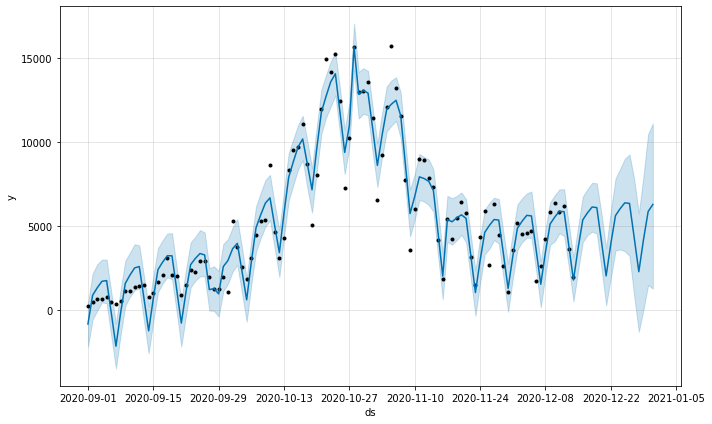

In [10]:
fcst = m.predict(future)
fig = m.plot(fcst)

Our prediction looks OK on the plot. Let's do some cross-validation.

In [11]:
df_cv = cross_validation(m, horizon = '20 days')
df_cv.head()

INFO:prophet:Making 3 forecasts with cutoffs between 2020-11-04 00:00:00 and 2020-11-24 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]


Initial log joint probability = -159.539
Iteration  1. Log joint probability =    58.5375. Improved by 218.076.
Iteration  2. Log joint probability =    90.9728. Improved by 32.4353.
Iteration  3. Log joint probability =    108.357. Improved by 17.3847.
Iteration  4. Log joint probability =    138.862. Improved by 30.5048.
Iteration  5. Log joint probability =    145.275. Improved by 6.41264.
Iteration  6. Log joint probability =    147.202. Improved by 1.92728.
Iteration  7. Log joint probability =     148.56. Improved by 1.35746.
Iteration  8. Log joint probability =    148.972. Improved by 0.411905.
Iteration  9. Log joint probability =    149.057. Improved by 0.0855624.
Iteration 10. Log joint probability =    149.406. Improved by 0.348569.
Iteration 11. Log joint probability =    149.602. Improved by 0.196268.
Iteration 12. Log joint probability =    149.755. Improved by 0.153513.
Iteration 13. Log joint probability =    149.832. Improved by 0.0768103.
Iteration 14. Log joint pro


Initial log joint probability = -181.413
Iteration  1. Log joint probability =    52.8084. Improved by 234.222.
Iteration  2. Log joint probability =    88.8341. Improved by 36.0257.
Iteration  3. Log joint probability =    91.5939. Improved by 2.75985.
Iteration  4. Log joint probability =     103.33. Improved by 11.7358.
Iteration  5. Log joint probability =    144.149. Improved by 40.819.
Iteration  6. Log joint probability =    154.513. Improved by 10.3643.
Iteration  7. Log joint probability =    163.429. Improved by 8.91597.
Iteration  8. Log joint probability =    167.187. Improved by 3.75762.
Iteration  9. Log joint probability =    169.341. Improved by 2.15452.
Iteration 10. Log joint probability =    170.497. Improved by 1.15603.
Iteration 11. Log joint probability =    171.506. Improved by 1.009.
Iteration 12. Log joint probability =    173.429. Improved by 1.92307.
Iteration 13. Log joint probability =    173.501. Improved by 0.0714799.
Iteration 14. Log joint probability 

ds          yhat    yhat_lower    yhat_upper      y     cutoff
0 2020-11-05  11121.339520  10045.431228  12134.923983  15731 2020-11-04
1 2020-11-06  11603.381062  10394.166008  13010.647791  13229 2020-11-04
2 2020-11-07  11764.779192  10185.012559  13428.394562  11552 2020-11-04
3 2020-11-08   9641.131773   7435.101725  11972.491510   7723 2020-11-04
4 2020-11-09   6741.283943   3515.589916  10094.231980   3608 2020-11-04

In [12]:
df_p = performance_metrics(df_cv)
df_p

horizon           mse         rmse          mae      mape     mdape  \
0   2 days  6.158538e+06  2481.640154  2143.790640  0.376320  0.387268   
1   3 days  2.252593e+06  1500.864200  1281.011223  0.285332  0.266922   
2   4 days  2.700868e+06  1643.431709  1441.316585  0.253887  0.253425   
3   5 days  3.403846e+06  1844.951397  1672.829561  0.413209  0.313055   
4   6 days  4.394456e+06  2096.295747  1851.947522  0.790999  0.492369   
5   7 days  4.800610e+06  2191.029469  1747.778161  0.723292  0.230237   
6   8 days  6.043226e+06  2458.297321  1723.772789  0.371395  0.084975   
7   9 days  6.579565e+06  2565.066257  2081.614092  0.469384  0.520683   
8  10 days  7.894677e+06  2809.746844  2691.199698  0.594264  0.667385   
9  11 days  1.132674e+07  3365.522662  3318.395081  0.672297  0.679728   
10 12 days  1.044808e+07  3232.348317  3041.596529  1.040476  0.897942   
11 13 days  1.381275e+07  3716.550160  3174.528278  1.225414  1.154090   
12 14 days  2.114483e+07  4598.350973  4011.337113  1.052191  0.728663   
13 15 days  2.289314e+07  4784.678083  4168.486238  0.914471  0.833770   
14 16 days  2.429851e+07  4929.352219  4313.160875  1.197106  0.951675   
15 17 days  2.638626e+07  5136.755571  4732.258650  1.280275  1.211580   
16 18 days  2.974912e+07  5454.275433  5187.454033  1.061791  1.210000   
17 19 days  2.884159e+07  5370.436633  4996.889123  1.317823  1.222430   
18 20 days  2.833053e+07  5322.643328  4617.820872  1.675940  1.291911   

       smape  coverage  
0   0.365833  0.333333  
1   0.279248  0.666667  
2   0.270062  0.666667  
3   0.408708  0.833333  
4   0.672689  0.833333  
5   0.754811  0.666667  
6   0.633107  0.666667  
7   0.716237  0.666667  
8   0.840673  0.500000  
9   0.842911  0.333333  
10  0.976574  0.666667  
11  1.021417  0.666667  
12  0.994015  0.500000  
13  1.096515  0.666667  
14  1.305866  0.666667  
15  1.460974  0.666667  
16  1.465258  0.500000  
17  1.437129  0.666667  
18  1.345951  1.000000

The prediction looks good enough on 4 days scale.

/home/nikolai/dataviz/venv/lib/python3.7/site-packages/prophet/plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/home/nikolai/dataviz/venv/lib/python3.7/site-packages/prophet/plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


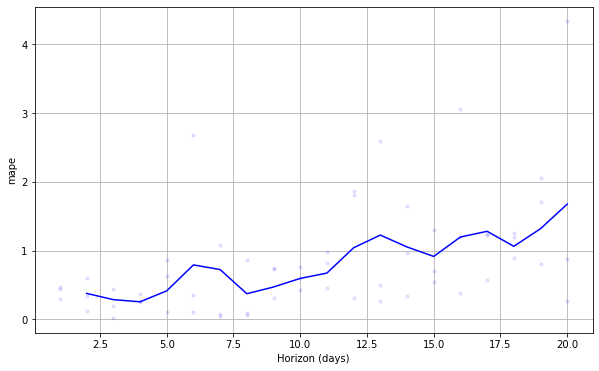

In [13]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

MAPE starts looking worse since 6th and 9th days. 